# Predicting the SPY
---

- [0. Data Processing](#data_processing)
- [1. Neural Network](#neural_network)
- [2. 1D Convolution Neural Network](#cnn)
- [3. LSTM](#ltsm)
- [4. 2D Conv of close timeseries](#CNN_noncolor)
- [5. 2D Conv of candlesticks](#CNN_candlestick)
- [6. 2D Conv of candlesticks with highs lows](#CNN_candlestick_hl)
- [7. 2D Conv of candlesticks with volume input](#CNN_candlestick_volume)


The models are fitted to a target variable defined as `True` if the stock see a 0.5% increase in the next 30minutes. Loss metric used was the `binary_crossentropy`. Models were trained on data spanning xxx to xxx, with the xxx to xxx period being used as an out of time test sample. The models achieve the following GINIs:
- Neural Net: 0.251
- Conv 1D Neural Net: 0.36
- LSTM: 0.32
- candlestick chart with volume: 0.37
  
A very simple simulation was done where £100 worth of the SPY was bought if the model's output probability was 90th percentile of its prediction range. The bought stock is then sold at the 30min mark and the profit calculated. The top model produced a total profit of £17 on the test sample. This equates to a 17% profit in a quarter, or 68% annualised profit.

| Model      | Train Profit | Test Profit     |
| :---        |    :----:   |          ---: |
| **Neural Net**      |   £1.88     | -£2.16   |
| **1D CNN**   | -£8.36        | £4.09      |
| **LSTM**   | -£13.20        | none      |
| **2D CNN fitted to candlesticks**   | £62.47        | £14.50      |
| **2D CNN fitted to candlesticks plus volume vector**  | £11.63        | £17.55      |

<a id='data_processing'></a>
## 0. Data Processing

The data is 5min intervals.

The target variable for this will be binary. Does the SPY go up or down in the next 30min. Will ingest the last 2 hours of data as input.


In [3]:
import pandas as pd
import numpy as np
import os
from matplotlib import pyplot as plt
from StockPredictionTools import plot_roc_curve, gini

In [4]:
file_loc = 'SPY_5min_2022-01-03T09.00.00_2022-03-25T14.10.00.csv'
df = pd.read_csv(os.path.join('data',file_loc),parse_dates=['datetime'])
df['date'] = df['datetime'].dt.date
df.head()

,datetime,volume,volume_weighted,open,close,high,low,timestamp,no_transactions,date
0,2022-01-03 09:00:00,9426.0,476.6581,476.38,476.56,476.92,476.38,1641200400000,115,2022-01-03
1,2022-01-03 09:05:00,1778.0,476.4585,476.48,476.44,476.49,476.44,1641200700000,37,2022-01-03
2,2022-01-03 09:10:00,9767.0,476.7624,476.62,476.83,476.87,476.58,1641201000000,80,2022-01-03
3,2022-01-03 09:15:00,1743.0,476.7269,476.84,476.53,476.84,476.53,1641201300000,44,2022-01-03
4,2022-01-03 09:20:00,1037.0,476.7011,476.65,476.82,476.82,476.62,1641201600000,21,2022-01-03


In [5]:
df.datetime.agg(['max','min'])

max   2022-03-25 14:10:00
min   2022-01-03 09:00:00
Name: datetime, dtype: datetime64[ns]

In [6]:
df.shape

(10965, 10)

In [7]:
df['time-delta'] = df['datetime'].diff().dt.seconds
for col in ['close']:
    df[f'{col}_diff'] = df[col].pct_change()
df.head()

,datetime,volume,volume_weighted,open,close,high,low,timestamp,no_transactions,date,time-delta,close_diff
0,2022-01-03 09:00:00,9426.0,476.6581,476.38,476.56,476.92,476.38,1641200400000,115,2022-01-03,NaN,NaN
1,2022-01-03 09:05:00,1778.0,476.4585,476.48,476.44,476.49,476.44,1641200700000,37,2022-01-03,300.0,-0.000252
2,2022-01-03 09:10:00,9767.0,476.7624,476.62,476.83,476.87,476.58,1641201000000,80,2022-01-03,300.0,0.000819
3,2022-01-03 09:15:00,1743.0,476.7269,476.84,476.53,476.84,476.53,1641201300000,44,2022-01-03,300.0,-0.000629
4,2022-01-03 09:20:00,1037.0,476.7011,476.65,476.82,476.82,476.62,1641201600000,21,2022-01-03,300.0,0.000609


In [8]:
# min_max = df.groupby('date')['close'].agg(['min','max']).shift(1).reset_index().rename(columns={'min':'previous_day_min',
#                                                                                                 'max':'previous_day_max'})
# df = df.merge(min_max,on='date')
# df['previous_day_max_ratio'] = df['close']/df['previous_day_max']
# df['previous_day_min_ratio'] = df['close']/df['previous_day_min']

<AxesSubplot:xlabel='datetime'>

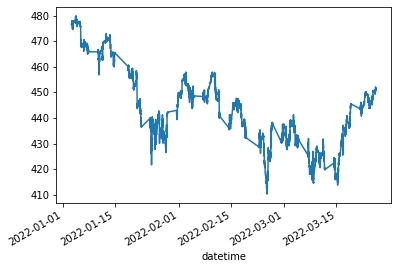

In [9]:
df.set_index('datetime')['close'].plot()

In [10]:
# Window of data we're working with
N = df.shape[0]
print(f'{N} ticks found')

# 2 hour lookback period
LOOKBACK = 2*(60/5)

# Growth requirement
GROWTH_LIMIT = 0.005

# outcome period 30min
HORIZON = 6

X = list()
y = list()
growth = list()

t =1
finish = False
counter = 0
while finish is False:
    
    counter+=1
    print(f'Counter:{counter}',end='\r')
    
    # check we have enough lookback data
    if t<22:
        t+=1
        continue
    
    # check we don't have enough data left then end the cycle
    if (N - t)<5:
        finish = True
        t+=1
        continue
        
    lookback_data = df.loc[t-20:t,['volume','close','open','high','low']].values
    lookback_data = lookback_data/lookback_data[-1]
    outcome_data = df.loc[t+1:t+6,'close_diff'].sum()>GROWTH_LIMIT
    growth_data = df.loc[t+1:t+6,'close_diff'].sum()
    
    X.append(lookback_data)
    y.append(outcome_data)
    growth.append(growth_data)
    
    t+=1

10965 ticks found


In [11]:
y = np.array(y).reshape(-1,1)
y.shape

(10939, 1)

In [12]:
growth = np.array(growth).reshape(-1,1)
growth.shape

(10939, 1)

In [13]:
X = np.stack(X)
X.shape

(10939, 21, 5)

In [14]:
X_train = X[:6000]
X_test = X[6000:]

y_train = y[:6000]
y_test = y[6000:]

growth_train = growth[:6000]
growth_test = growth[6000:]

with open('./data/X_train_2.npy','wb') as f:
    np.save(f,X_train)
    
with open('./data/X_test_2.npy','wb') as f:
    np.save(f,X_test)
    
with open('./data/y_train_2.npy','wb') as f:
    np.save(f,y_train)
    
with open('./data/y_test_2.npy','wb') as f:
    np.save(f,X_test)

<a id='neural_network'></a>
## 1.0 Neural Network

In [15]:
import tensorflow as tf
from tensorflow import keras

X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
y_train = y_train.astype('float32')
y_test = y_test.astype('float32')

# with open('./data/X_train_2.npy','rb') as f:
#     X_train = np.load(f).astype('float32')
    
# with open('./data/X_test_2.npy','rb') as f:
#     X_test = np.load(f).astype('float32')
    
# with open('./data/y_train_2.npy','rb') as f:
#     y_train = np.load(f).astype('float32')

# with open('./data/y_test_2.npy','rb') as f:
#     y_test = np.load(f).astype('float32')

In [16]:
X_train.shape

(6000, 21, 5)

In [17]:
y_train.shape

(6000, 1)

In [16]:
X_test.shape

(4939, 21, 5)

In [17]:
y_test.shape

(4939, 1)

In [18]:
model = keras.Sequential([
    keras.layers.Flatten(input_shape=(X_train.shape[1],X_train.shape[2])),
    #keras.layers.Dense(21,activation='relu'),
    keras.layers.Dense(20,activation='sigmoid'),
    keras.layers.Dense(1,activation='sigmoid')
])

In [19]:
metrics = [
    tf.metrics.AUC(name='auc')
]

model.compile(optimizer=keras.optimizers.Adam(1e-4),loss='binary_crossentropy',metrics=metrics)

In [20]:
callbacks = [keras.callbacks.EarlyStopping(patience=5,restore_best_weights=True)]

In [21]:
history = model.fit(X_train,y_train,batch_size=50,epochs=120,verbose=2,validation_data=(X_test,y_test))

Epoch 1/120
120/120 - 1s - loss: 0.5317 - auc: 0.4324 - val_loss: 0.3747 - val_auc: 0.4323 - 917ms/epoch - 8ms/step
Epoch 2/120
120/120 - 0s - loss: 0.3018 - auc: 0.4065 - val_loss: 0.2666 - val_auc: 0.4369 - 186ms/epoch - 2ms/step
Epoch 3/120
120/120 - 0s - loss: 0.2327 - auc: 0.4212 - val_loss: 0.2287 - val_auc: 0.4496 - 200ms/epoch - 2ms/step
Epoch 4/120
120/120 - 0s - loss: 0.2032 - auc: 0.4240 - val_loss: 0.2103 - val_auc: 0.4566 - 187ms/epoch - 2ms/step
Epoch 5/120
120/120 - 0s - loss: 0.1872 - auc: 0.4296 - val_loss: 0.1995 - val_auc: 0.4600 - 190ms/epoch - 2ms/step
Epoch 6/120
120/120 - 0s - loss: 0.1768 - auc: 0.4293 - val_loss: 0.1918 - val_auc: 0.4651 - 196ms/epoch - 2ms/step
Epoch 7/120
120/120 - 0s - loss: 0.1692 - auc: 0.4501 - val_loss: 0.1868 - val_auc: 0.4724 - 168ms/epoch - 1ms/step
Epoch 8/120
120/120 - 0s - loss: 0.1634 - auc: 0.4586 - val_loss: 0.1827 - val_auc: 0.4798 - 163ms/epoch - 1ms/step
Epoch 9/120
120/120 - 0s - loss: 0.1588 - auc: 0.4622 - val_loss: 0.1798

120/120 - 0s - loss: 0.1311 - auc: 0.6519 - val_loss: 0.1565 - val_auc: 0.6342 - 184ms/epoch - 2ms/step
Epoch 72/120
120/120 - 0s - loss: 0.1311 - auc: 0.6516 - val_loss: 0.1565 - val_auc: 0.6331 - 210ms/epoch - 2ms/step
Epoch 73/120
120/120 - 0s - loss: 0.1311 - auc: 0.6525 - val_loss: 0.1564 - val_auc: 0.6324 - 180ms/epoch - 1ms/step
Epoch 74/120
120/120 - 0s - loss: 0.1310 - auc: 0.6536 - val_loss: 0.1562 - val_auc: 0.6332 - 177ms/epoch - 1ms/step
Epoch 75/120
120/120 - 0s - loss: 0.1309 - auc: 0.6580 - val_loss: 0.1564 - val_auc: 0.6342 - 166ms/epoch - 1ms/step
Epoch 76/120
120/120 - 0s - loss: 0.1309 - auc: 0.6539 - val_loss: 0.1563 - val_auc: 0.6327 - 198ms/epoch - 2ms/step
Epoch 77/120
120/120 - 0s - loss: 0.1309 - auc: 0.6531 - val_loss: 0.1562 - val_auc: 0.6343 - 175ms/epoch - 1ms/step
Epoch 78/120
120/120 - 0s - loss: 0.1310 - auc: 0.6537 - val_loss: 0.1565 - val_auc: 0.6351 - 186ms/epoch - 2ms/step
Epoch 79/120
120/120 - 0s - loss: 0.1308 - auc: 0.6577 - val_loss: 0.1563 - v

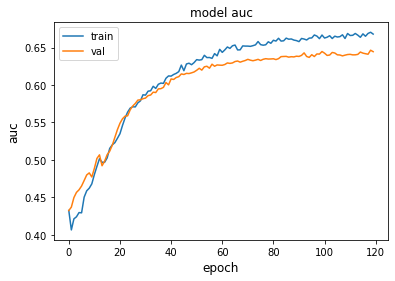

In [22]:
from matplotlib import pyplot as plt
metric = 'auc'
plt.figure()
plt.plot(history.history[metric])
plt.plot(history.history['val_'+metric])
plt.title('model '+metric)
plt.ylabel(metric,fontsize='large')
plt.xlabel('epoch',fontsize='large')
plt.legend(['train','val'],loc='best')
plt.show()

188/188 [==============================] - 0s 656us/step


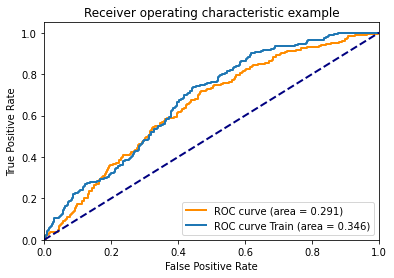

In [23]:
plot_roc_curve(X_train,y_train,X_test,y_test,model)

In [24]:
growth_train

array([[0.00089999],
       [0.00027221],
       [0.00020936],
       ...,
       [0.00069533],
       [0.00042494],
       [0.00015844]])

In [25]:
input_series = X
train_predictions = model.predict(X_train)
test_predictions = model.predict(X_test)

# Cut the distribution up into percentiles
percentiles = np.percentile(train_predictions,[90])

# if in the top 10 percentiles then put a bet on of £100
bet_amount = np.where(train_predictions>percentiles[0],100,0)
results = bet_amount*growth_train
print(f'Train Results is:{results.sum()}')

155/155 [==============================] - 0s 602us/step
Train Results is:-1.8794190089594611


In [ ]:
-1.8794190089594611,-2.167887119960243

In [26]:
# Cut the distribution up into percentiles
percentiles = np.percentile(train_predictions,[90])

# if in the top 10 percentiles then put a bet on of £100
bet_amount = np.where(test_predictions>percentiles[0],100,0)
results = bet_amount*growth_test
print(f'Test Results is:{results.sum()}')

Test Results is:-2.167887119960243


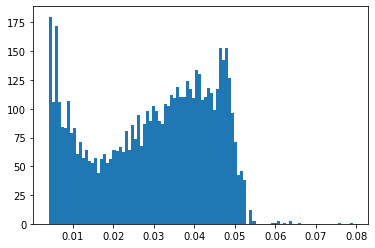

In [27]:
plt.hist(train_predictions,bins=100)
plt.show()

<a id='cnn'></a>
## 2.0 1D Convolutional NN

In [27]:
model = keras.Sequential([
    keras.layers.Conv1D(36,2,
                        activation='sigmoid',
                        input_shape=(X_train.shape[1],X_train.shape[2]),padding="valid",groups=1,
                        kernel_regularizer=tf.keras.regularizers.l2(l=.05)),
    #keras.layers.Conv1D(3,3,activation='relu'),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPooling1D(2),
    #keras.layers.Conv1D(6,2,activation='relu'),
    #keras.layers.BatchNormalization(),
    #keras.layers.MaxPooling1D(2),    
    keras.layers.Flatten(),
    keras.layers.Dense(10,activation='sigmoid'),
    keras.layers.Dense(1,activation='sigmoid')
])

In [28]:
metrics = [
    tf.metrics.AUC(name='auc')
]

#odel.compile(optimizer=keras.optimizers.Adam(1e-4),loss='binary_crossentropy',metrics=metrics)
model.compile(optimizer=keras.optimizers.Adam(1e-4),loss='binary_crossentropy',metrics=metrics)

In [29]:
callbacks = [keras.callbacks.EarlyStopping(patience=500,restore_best_weights=True)]

In [30]:
history = model.fit(X_train,y_train,batch_size=50,epochs=200,verbose=2,validation_data=(X_test,y_test))

Epoch 1/200
120/120 - 1s - loss: 0.8177 - auc: 0.5315 - val_loss: 0.7394 - val_auc: 0.5360 - 1s/epoch - 9ms/step
Epoch 2/200
120/120 - 0s - loss: 0.6721 - auc: 0.5288 - val_loss: 0.6277 - val_auc: 0.5854 - 291ms/epoch - 2ms/step
Epoch 3/200
120/120 - 0s - loss: 0.5725 - auc: 0.5922 - val_loss: 0.5516 - val_auc: 0.5825 - 306ms/epoch - 3ms/step
Epoch 4/200
120/120 - 0s - loss: 0.5021 - auc: 0.6230 - val_loss: 0.4892 - val_auc: 0.5821 - 294ms/epoch - 2ms/step
Epoch 5/200
120/120 - 0s - loss: 0.4484 - auc: 0.6154 - val_loss: 0.4401 - val_auc: 0.5878 - 295ms/epoch - 2ms/step
Epoch 6/200
120/120 - 0s - loss: 0.4050 - auc: 0.6201 - val_loss: 0.4005 - val_auc: 0.5952 - 286ms/epoch - 2ms/step
Epoch 7/200
120/120 - 0s - loss: 0.3683 - auc: 0.6383 - val_loss: 0.3673 - val_auc: 0.5886 - 297ms/epoch - 2ms/step
Epoch 8/200
120/120 - 0s - loss: 0.3369 - auc: 0.6459 - val_loss: 0.3388 - val_auc: 0.5923 - 280ms/epoch - 2ms/step
Epoch 9/200
120/120 - 0s - loss: 0.3098 - auc: 0.6489 - val_loss: 0.3141 - 

Epoch 72/200
120/120 - 0s - loss: 0.1327 - auc: 0.6582 - val_loss: 0.1561 - val_auc: 0.6546 - 309ms/epoch - 3ms/step
Epoch 73/200
120/120 - 0s - loss: 0.1326 - auc: 0.6539 - val_loss: 0.1555 - val_auc: 0.6568 - 324ms/epoch - 3ms/step
Epoch 74/200
120/120 - 0s - loss: 0.1329 - auc: 0.6438 - val_loss: 0.1559 - val_auc: 0.6523 - 317ms/epoch - 3ms/step
Epoch 75/200
120/120 - 0s - loss: 0.1322 - auc: 0.6570 - val_loss: 0.1553 - val_auc: 0.6556 - 318ms/epoch - 3ms/step
Epoch 76/200
120/120 - 0s - loss: 0.1321 - auc: 0.6661 - val_loss: 0.1565 - val_auc: 0.6591 - 315ms/epoch - 3ms/step
Epoch 77/200
120/120 - 0s - loss: 0.1322 - auc: 0.6641 - val_loss: 0.1551 - val_auc: 0.6557 - 301ms/epoch - 3ms/step
Epoch 78/200
120/120 - 0s - loss: 0.1325 - auc: 0.6480 - val_loss: 0.1560 - val_auc: 0.6577 - 310ms/epoch - 3ms/step
Epoch 79/200
120/120 - 0s - loss: 0.1322 - auc: 0.6587 - val_loss: 0.1570 - val_auc: 0.6544 - 318ms/epoch - 3ms/step
Epoch 80/200
120/120 - 0s - loss: 0.1323 - auc: 0.6588 - val_los

Epoch 142/200
120/120 - 0s - loss: 0.1312 - auc: 0.6696 - val_loss: 0.1546 - val_auc: 0.6661 - 305ms/epoch - 3ms/step
Epoch 143/200
120/120 - 0s - loss: 0.1307 - auc: 0.6812 - val_loss: 0.1549 - val_auc: 0.6639 - 313ms/epoch - 3ms/step
Epoch 144/200
120/120 - 0s - loss: 0.1309 - auc: 0.6771 - val_loss: 0.1546 - val_auc: 0.6663 - 329ms/epoch - 3ms/step
Epoch 145/200
120/120 - 0s - loss: 0.1313 - auc: 0.6641 - val_loss: 0.1547 - val_auc: 0.6673 - 313ms/epoch - 3ms/step
Epoch 146/200
120/120 - 0s - loss: 0.1307 - auc: 0.6772 - val_loss: 0.1544 - val_auc: 0.6616 - 313ms/epoch - 3ms/step
Epoch 147/200
120/120 - 0s - loss: 0.1307 - auc: 0.6773 - val_loss: 0.1556 - val_auc: 0.6661 - 305ms/epoch - 3ms/step
Epoch 148/200
120/120 - 0s - loss: 0.1312 - auc: 0.6704 - val_loss: 0.1554 - val_auc: 0.6665 - 312ms/epoch - 3ms/step
Epoch 149/200
120/120 - 0s - loss: 0.1309 - auc: 0.6721 - val_loss: 0.1550 - val_auc: 0.6610 - 375ms/epoch - 3ms/step
Epoch 150/200
120/120 - 0s - loss: 0.1313 - auc: 0.6694 

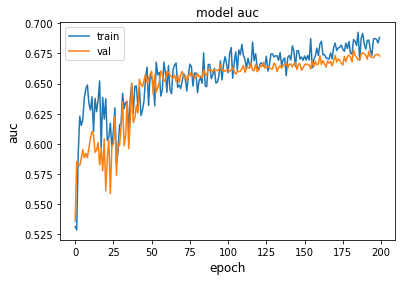

In [31]:
from matplotlib import pyplot as plt
metric = 'auc'
plt.figure()
plt.plot(history.history[metric])
plt.plot(history.history['val_'+metric])
plt.title('model '+metric)
plt.ylabel(metric,fontsize='large')
plt.xlabel('epoch',fontsize='large')
plt.legend(['train','val'],loc='best')
plt.show()

188/188 [==============================] - 0s 1ms/step


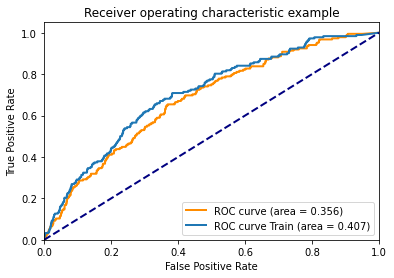

In [32]:
plot_roc_curve(X_train,y_train,X_test,y_test,model)

In [33]:
input_series = X
train_predictions = model.predict(X_train)
test_predictions = model.predict(X_test)

# Cut the distribution up into percentiles
percentiles = np.percentile(train_predictions,[90])

# if in the top 10 percentiles then put a bet on of £100
bet_amount = np.where(train_predictions>percentiles[0],100,0)
results = bet_amount*growth_train
print(f'Results is:{results.sum()}')

155/155 [==============================] - 0s 1ms/step
Results is:-8.360555389481405


In [34]:
# Cut the distribution up into percentiles
percentiles = np.percentile(train_predictions,[90])

# if in the top 10 percentiles then put a bet on of £100
bet_amount = np.where(test_predictions>percentiles[0],100,0)
results = bet_amount*growth_test
print(f'Test Results is:{results.sum()}')

Test Results is:4.0936382094406305


Tops out at 0.35....

<a id='ltsm'></a>
## 3.0 LTSM
Not even sure this is right..

In [60]:
from tensorflow.keras.layers import LSTM
from tensorflow import keras

lookback = 20
model = keras.Sequential([
    keras.layers.LSTM(20,input_shape=(21,5)),
    keras.layers.Dense(5),
    keras.layers.Dense(1,activation='sigmoid')
])

In [61]:
import tensorflow as tf

metrics = [tf.metrics.AUC(name='auc')]

model.compile(optimizer=keras.optimizers.Adam(1e-4),loss='binary_crossentropy',metrics=metrics)

callbacks = [keras.callbacks.EarlyStopping(patience=500,restore_best_weights=True)]

history = model.fit(X_train,y_train,batch_size=50,epochs=100,verbose=2,validation_data=(X_test,y_test))

Epoch 1/100
120/120 - 2s - loss: 0.6319 - auc: 0.4702 - val_loss: 0.4982 - val_auc: 0.3829 - 2s/epoch - 19ms/step
Epoch 2/100
120/120 - 1s - loss: 0.3853 - auc: 0.4149 - val_loss: 0.2987 - val_auc: 0.4364 - 630ms/epoch - 5ms/step
Epoch 3/100
120/120 - 1s - loss: 0.2330 - auc: 0.4290 - val_loss: 0.2039 - val_auc: 0.4555 - 608ms/epoch - 5ms/step
Epoch 4/100
120/120 - 1s - loss: 0.1696 - auc: 0.4467 - val_loss: 0.1742 - val_auc: 0.4608 - 592ms/epoch - 5ms/step
Epoch 5/100
120/120 - 1s - loss: 0.1504 - auc: 0.4264 - val_loss: 0.1673 - val_auc: 0.4523 - 615ms/epoch - 5ms/step
Epoch 6/100
120/120 - 1s - loss: 0.1445 - auc: 0.4308 - val_loss: 0.1652 - val_auc: 0.4767 - 615ms/epoch - 5ms/step
Epoch 7/100
120/120 - 1s - loss: 0.1420 - auc: 0.4294 - val_loss: 0.1642 - val_auc: 0.4635 - 663ms/epoch - 6ms/step
Epoch 8/100
120/120 - 1s - loss: 0.1406 - auc: 0.4649 - val_loss: 0.1636 - val_auc: 0.4875 - 632ms/epoch - 5ms/step
Epoch 9/100
120/120 - 1s - loss: 0.1396 - auc: 0.5002 - val_loss: 0.1629 -

Epoch 72/100
120/120 - 1s - loss: 0.1317 - auc: 0.6439 - val_loss: 0.1554 - val_auc: 0.6535 - 586ms/epoch - 5ms/step
Epoch 73/100
120/120 - 1s - loss: 0.1318 - auc: 0.6352 - val_loss: 0.1561 - val_auc: 0.6541 - 587ms/epoch - 5ms/step
Epoch 74/100
120/120 - 1s - loss: 0.1316 - auc: 0.6407 - val_loss: 0.1555 - val_auc: 0.6559 - 589ms/epoch - 5ms/step
Epoch 75/100
120/120 - 1s - loss: 0.1316 - auc: 0.6377 - val_loss: 0.1547 - val_auc: 0.6535 - 587ms/epoch - 5ms/step
Epoch 76/100
120/120 - 1s - loss: 0.1317 - auc: 0.6368 - val_loss: 0.1545 - val_auc: 0.6563 - 587ms/epoch - 5ms/step
Epoch 77/100
120/120 - 1s - loss: 0.1316 - auc: 0.6432 - val_loss: 0.1550 - val_auc: 0.6591 - 584ms/epoch - 5ms/step
Epoch 78/100
120/120 - 1s - loss: 0.1315 - auc: 0.6440 - val_loss: 0.1554 - val_auc: 0.6565 - 585ms/epoch - 5ms/step
Epoch 79/100
120/120 - 1s - loss: 0.1315 - auc: 0.6376 - val_loss: 0.1554 - val_auc: 0.6561 - 587ms/epoch - 5ms/step
Epoch 80/100
120/120 - 1s - loss: 0.1314 - auc: 0.6477 - val_los

In [62]:
callbacks = [keras.callbacks.EarlyStopping(patience=500,restore_best_weights=True)]

In [63]:
history = model.fit(X_train,y_train,batch_size=50,epochs=100,verbose=2,validation_data=(X_test,y_test))

Epoch 1/100
120/120 - 1s - loss: 0.1308 - auc: 0.6553 - val_loss: 0.1549 - val_auc: 0.6660 - 622ms/epoch - 5ms/step
Epoch 2/100
120/120 - 1s - loss: 0.1306 - auc: 0.6613 - val_loss: 0.1545 - val_auc: 0.6719 - 600ms/epoch - 5ms/step
Epoch 3/100
120/120 - 1s - loss: 0.1304 - auc: 0.6653 - val_loss: 0.1542 - val_auc: 0.6701 - 626ms/epoch - 5ms/step
Epoch 4/100
120/120 - 1s - loss: 0.1301 - auc: 0.6828 - val_loss: 0.1560 - val_auc: 0.6703 - 640ms/epoch - 5ms/step
Epoch 5/100
120/120 - 1s - loss: 0.1305 - auc: 0.6606 - val_loss: 0.1539 - val_auc: 0.6659 - 640ms/epoch - 5ms/step
Epoch 6/100
120/120 - 1s - loss: 0.1304 - auc: 0.6669 - val_loss: 0.1548 - val_auc: 0.6662 - 612ms/epoch - 5ms/step
Epoch 7/100
120/120 - 1s - loss: 0.1301 - auc: 0.6702 - val_loss: 0.1543 - val_auc: 0.6707 - 588ms/epoch - 5ms/step
Epoch 8/100
120/120 - 1s - loss: 0.1302 - auc: 0.6649 - val_loss: 0.1537 - val_auc: 0.6641 - 594ms/epoch - 5ms/step
Epoch 9/100
120/120 - 1s - loss: 0.1301 - auc: 0.6740 - val_loss: 0.1540

120/120 - 1s - loss: 0.1272 - auc: 0.7121 - val_loss: 0.1564 - val_auc: 0.6595 - 589ms/epoch - 5ms/step
Epoch 72/100
120/120 - 1s - loss: 0.1275 - auc: 0.7124 - val_loss: 0.1551 - val_auc: 0.6568 - 610ms/epoch - 5ms/step
Epoch 73/100
120/120 - 1s - loss: 0.1274 - auc: 0.7094 - val_loss: 0.1569 - val_auc: 0.6573 - 628ms/epoch - 5ms/step
Epoch 74/100
120/120 - 1s - loss: 0.1272 - auc: 0.7182 - val_loss: 0.1555 - val_auc: 0.6575 - 637ms/epoch - 5ms/step
Epoch 75/100
120/120 - 1s - loss: 0.1272 - auc: 0.7125 - val_loss: 0.1554 - val_auc: 0.6521 - 619ms/epoch - 5ms/step
Epoch 76/100
120/120 - 1s - loss: 0.1271 - auc: 0.7218 - val_loss: 0.1554 - val_auc: 0.6527 - 601ms/epoch - 5ms/step
Epoch 77/100
120/120 - 1s - loss: 0.1271 - auc: 0.7185 - val_loss: 0.1554 - val_auc: 0.6599 - 593ms/epoch - 5ms/step
Epoch 78/100
120/120 - 1s - loss: 0.1269 - auc: 0.7243 - val_loss: 0.1560 - val_auc: 0.6571 - 635ms/epoch - 5ms/step
Epoch 79/100
120/120 - 1s - loss: 0.1273 - auc: 0.7105 - val_loss: 0.1555 - v

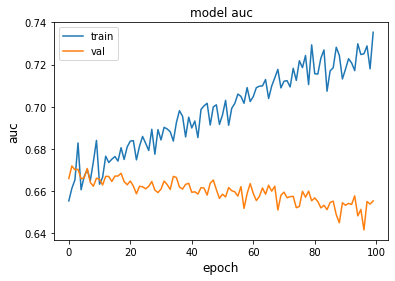

In [64]:
from matplotlib import pyplot as plt
metric = 'auc'
plt.figure()
plt.plot(history.history[metric])
plt.plot(history.history['val_'+metric])
plt.title('model '+metric)
plt.ylabel(metric,fontsize='large')
plt.xlabel('epoch',fontsize='large')
plt.legend(['train','val'],loc='best')
plt.show()

188/188 [==============================] - 0s 2ms/step


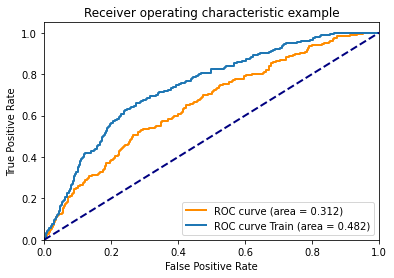

In [65]:
plot_roc_curve(X_train,y_train,X_test,y_test,model)

In [66]:
input_series = X
train_predictions = model.predict(X_train)
test_predictions = model.predict(X_test)

# Cut the distribution up into percentiles
percentiles = np.percentile(train_predictions,[90])

# if in the top 10 percentiles then put a bet on of £100
bet_amount = np.where(train_predictions>percentiles[0],100,0)
results = bet_amount*growth_train
print(f'Results is:{results.sum()}')

155/155 [==============================] - 0s 2ms/step
Results is:13.198485954922422


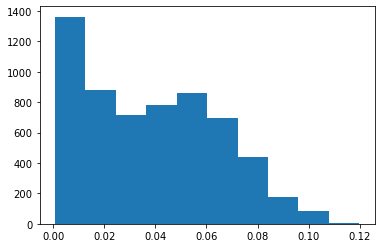

In [67]:
plt.hist(train_predictions)
plt.show()

<a id='CNN_noncolor'></a>
## 4.0 Conv2D non-color image (i.e. close only)
The image is essentialy the plot of the highs, lows, close, and open. Need to do some manipulation here.

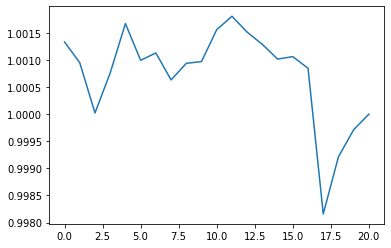

In [40]:
plt.plot(X_train[-1,:,1])
plt.show()

In [41]:
levels = np.arange(0.996,1.001,0.0001)
levels = [-np.inf]+levels.tolist()+[np.inf]
n_levels = len(levels)
labels = np.arange(n_levels-1)

Y = pd.cut(X_train[0,:,1],levels,labels=labels[::-1])

y_resolution = len(levels)
X = np.arange(0,len(X_train[0,:,1]))

blank = np.zeros( (n_levels,21))
for n,(x,y) in enumerate(zip(X,Y)):
    blank[y,x] = X_train[0,:,1][n]

In [42]:
def convert_time_series_img(series,lower_bound,upper_bound,resolution):
    
    series = series.ravel()
    levels = np.arange(lower_bound,upper_bound,resolution)
    levels = [-np.inf]+levels.tolist()+[np.inf]
    n_levels = len(levels)
    labels = np.arange(n_levels-1)
    Y = pd.cut(series,levels,labels=labels[::-1])
    
    y_resolution = len(levels)
    X = np.arange(0,len(series))
    
    blank = np.zeros( (n_levels,21))
    for n,(x,y) in enumerate(zip(X,Y)):
        #blank[y,x] = series[n]
        blank[y,x] = 255
        
    return blank

In [43]:
def plot_time_series(series):
    np_img = convert_time_series_img(series,0.994,1.006,0.0001)
    fig, axes = plt.subplots(figsize=(10,5))
    axes.imshow(np_img)
    plt.show()

In [46]:
convert_time_series_img(X_train[0,:,1],0.994,1.006,0.0001).shape

(123, 21)

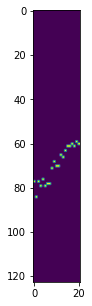

In [44]:
plot_time_series(X_train[0,:,1])

In [76]:
import numpy as np
from PIL import Image

imgs = [convert_time_series_img(X_train[x,:,1],0.98,1.02,0.0001) for x in range(len(X_train))]
imgs = [Image.fromarray(img) for img in imgs]
# duration is the number of milliseconds between frames; this is 40 frames per second
imgs[0].save("array.gif", save_all=True, append_images=imgs[1:], duration=50, loop=0)

Hoooooo-rah!!!! Looks like its working.

![SegmentLocal](array.gif "segment")

In [77]:
img_train = np.stack([convert_time_series_img(X_train[x,:,1],0.99,1.01,0.0001).reshape(203,21,1) for x in range(len(X_train))])
img_test = np.stack([convert_time_series_img(X_test[x,:,1],0.99,1.01,0.0001).reshape(203,21,1) for x in range(len(X_test))])

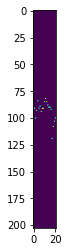

In [78]:
plt.imshow(img_train[-1])

In [79]:
model = keras.Sequential(
    [
        keras.Input(shape=(203, 21, 1)),
        keras.layers.Conv2D(32, kernel_size=(3, 3), activation="relu"),
        keras.layers.MaxPooling2D(pool_size=(3, 2)),
        keras.layers.Conv2D(64, kernel_size=(3, 3), activation="relu"),
        keras.layers.MaxPooling2D(pool_size=(3, 2)),
        keras.layers.Conv2D(32, kernel_size=(3, 3), activation="relu"),
        keras.layers.Flatten(),
        keras.layers.Dropout(0.9),
        #layers.Dense(200, activation="sigmoid"),
        #layers.Dropout(0.9),
        #layers.Dense(20, activation="sigmoid"),
        keras.layers.Dense(1, activation="sigmoid")
    ]
)

model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 201, 19, 32)       320       
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 67, 9, 32)        0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 65, 7, 64)         18496     
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 21, 3, 64)        0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 19, 1, 32)         18464     
                                                                 
 flatten_3 (Flatten)         (None, 608)              

In [80]:
batch_size = 200
epochs = 30

optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)

model.compile(loss="binary_crossentropy", optimizer=optimizer, metrics=[tf.metrics.AUC(name='auc')])
callbacks = [keras.callbacks.EarlyStopping(patience=10,restore_best_weights=True)]
history = model.fit(img_train, y_train, batch_size=batch_size, epochs=epochs, verbose=1,validation_data=(img_test,y_test))

Epoch 1/30
30/30 [==============================] - 7s 211ms/step - loss: 4.7274 - auc: 0.5165 - val_loss: 0.3743 - val_auc: 0.4943
Epoch 2/30
30/30 [==============================] - 6s 203ms/step - loss: 1.5362 - auc: 0.5132 - val_loss: 0.2893 - val_auc: 0.4995
Epoch 3/30
30/30 [==============================] - 6s 190ms/step - loss: 1.1243 - auc: 0.4943 - val_loss: 0.2253 - val_auc: 0.4775
Epoch 4/30
30/30 [==============================] - 6s 189ms/step - loss: 0.8589 - auc: 0.4736 - val_loss: 0.2120 - val_auc: 0.4703
Epoch 5/30
30/30 [==============================] - 6s 189ms/step - loss: 0.7274 - auc: 0.4740 - val_loss: 0.2035 - val_auc: 0.4794
Epoch 6/30
30/30 [==============================] - 6s 194ms/step - loss: 0.6296 - auc: 0.4927 - val_loss: 0.1996 - val_auc: 0.4819
Epoch 7/30
30/30 [==============================] - 6s 192ms/step - loss: 0.5944 - auc: 0.4786 - val_loss: 0.1957 - val_auc: 0.4801
Epoch 8/30
30/30 [==============================] - 6s 192ms/step - loss: 0.

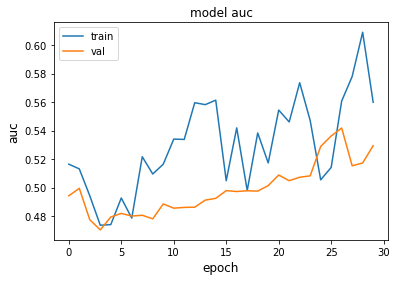

In [81]:
from matplotlib import pyplot as plt
metric = 'auc'
plt.figure()
plt.plot(history.history[metric])
plt.plot(history.history['val_'+metric])
plt.title('model '+metric)
plt.ylabel(metric,fontsize='large')
plt.xlabel('epoch',fontsize='large')
plt.legend(['train','val'],loc='best')
plt.show()

188/188 [==============================] - 2s 9ms/step


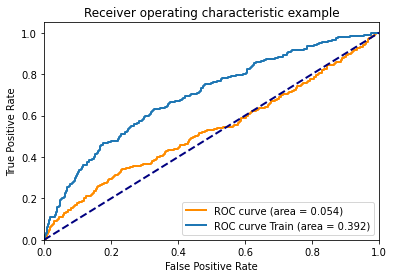

In [82]:
plot_roc_curve(img_train,y_train,img_test,y_test,model)

In [83]:
input_series = X
train_predictions = model.predict(img_train)
test_predictions = model.predict(img_test)

# Cut the distribution up into percentiles
percentiles = np.percentile(train_predictions,[90])

# if in the top 10 percentiles then put a bet on of £100
bet_amount = np.where(train_predictions>percentiles[0],100,0)
results = bet_amount*growth_train
print(f'Results is:{results.sum()}')

155/155 [==============================] - 1s 9ms/step
Results is:9.953793706755054


In [84]:
# Cut the distribution up into percentiles
percentiles = np.percentile(train_predictions,[90])

# if in the top 10 percentiles then put a bet on of £100
bet_amount = np.where(test_predictions>percentiles[0],100,0)
results = bet_amount*growth_test
print(f'Test Results is:{results.sum()}')

Test Results is:11.482582701004317


The probability distribution looks nice!!!

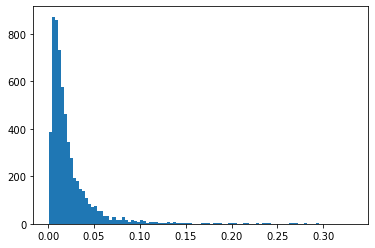

In [85]:
plt.hist(train_predictions,bins=100)
plt.show()

In [87]:
for n,v in enumerate(train_predictions):
    if v>0.3:
        print(n)

3022
3745
5515


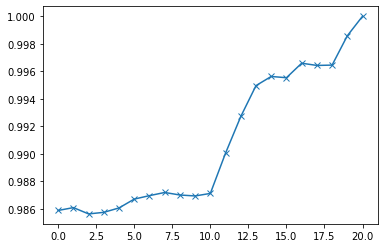

In [97]:
plt.plot(X_train[3022,:,1],marker='x')

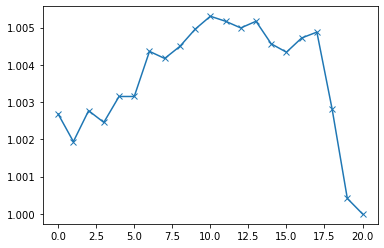

In [99]:
plt.plot(X_train[3745,:,1],marker='x')

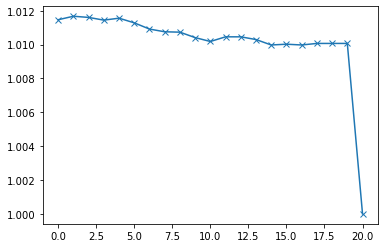

In [100]:
plt.plot(X_train[5515,:,1],marker='x')

<a id='CNN_candlestick'></a>
## 5.0 Conv2D with color (still no volume)

In [68]:
def convert_time_series_img(series,lower_bound,upper_bound,resolution):
    
    volume_series = series[:,0].ravel()
    close_series = series[:,1].ravel()
    open_series = series[:,2].ravel()
    high_series = series[:,3].ravel()
    low_series = series[:,4].ravel()

    levels = np.arange(lower_bound,upper_bound,resolution)
    levels = [-np.inf]+levels.tolist()+[np.inf]
    n_levels = len(levels)
    labels = np.arange(n_levels-1)

    #Y_volume = pd.cut(volume_series,levels,labels=labels[::-1])
    Y_close = pd.cut(close_series,levels,labels=labels[::-1])
    Y_open = pd.cut(open_series,levels,labels=labels[::-1])
    Y_high = pd.cut(high_series,levels,labels=labels[::-1])
    Y_low = pd.cut(low_series,levels,labels=labels[::-1])

    blank = np.full( (n_levels,21,3),0)
    X = np.arange(0,len(close_series))
    for x,c,o,h,l in zip(X,Y_close,Y_open,Y_high,Y_low):
        if o>=c:
            for y in range(c,o):
                blank[y,x,0] = 60
                blank[y,x,1] = 240
                blank[y,x,2] = 60
        else:
            for y in range(o,c):
                blank[y,x,0] = 255
                blank[y,x,1] = 25
                blank[y,x,2] = 25
        
    return blank

def plot_time_series(series):
    np_img = convert_time_series_img(series,0.994,1.006,0.0001)
    fig, axes = plt.subplots(figsize=(10,5))
    axes.imshow(np_img)
    plt.show()

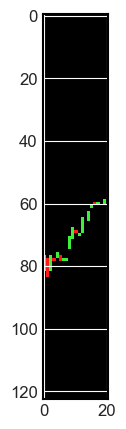

In [69]:
plot_time_series(X_train[0,:,:])

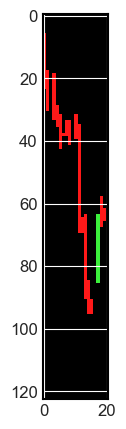

In [70]:
plot_time_series(X_train[1200,:,:])

Just checking that the color of the candles looks right - appears to be...

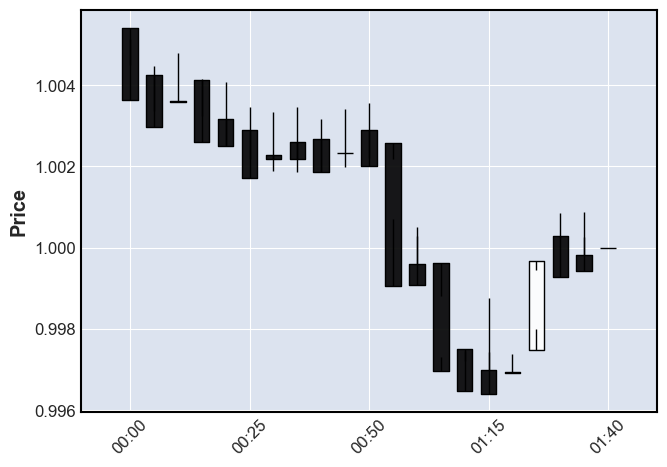

In [71]:
import mplfinance as mpf
intervals = pd.DataFrame(X_train[1200,:,:],columns=['volume','close','open','high','low'])
intervals.index = pd.date_range('2021-06-01',periods=len(intervals.index),freq='5min')
mpf.plot(intervals,type='candle')

Creating a pretty gif so i can show off.

In [72]:
import numpy as np
from PIL import Image

imgs = [convert_time_series_img(X_train[x,:,:],0.99,1.01,0.0001).astype(np.uint8) for x in range(len(X_train))]
imgs = [Image.fromarray(img) for img in imgs]
# duration is the number of milliseconds between frames; this is 40 frames per second
imgs[0].save("array_color.gif", save_all=True, append_images=imgs[1:], duration=50, loop=0)

In [73]:
img_train = np.stack([convert_time_series_img(X_train[x,:,:],0.99,1.01,0.0001) for x in range(len(X_train))])
img_test = np.stack([convert_time_series_img(X_test[x,:,:],0.99,1.01,0.0001) for x in range(len(X_test))])

In [74]:
model = keras.Sequential(
    [
        keras.Input(shape=(203, 21, 3)),
        keras.layers.Conv2D(32, kernel_size=(3, 3), activation="relu"),
        keras.layers.MaxPooling2D(pool_size=(3, 2)),
        keras.layers.Conv2D(64, kernel_size=(3, 3), activation="relu"),
        keras.layers.MaxPooling2D(pool_size=(3, 2)),
        keras.layers.Conv2D(32, kernel_size=(3, 3), activation="relu"),
        keras.layers.Flatten(),
        keras.layers.Dropout(0.9),
        #layers.Dense(200, activation="sigmoid"),
        #layers.Dropout(0.9),
        #layers.Dense(20, activation="sigmoid"),
        keras.layers.Dense(1, activation="sigmoid")
    ]
)

model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 201, 19, 32)       896       
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 67, 9, 32)        0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 65, 7, 64)         18496     
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 21, 3, 64)        0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 19, 1, 32)         18464     
                                                                 
 flatten_2 (Flatten)         (None, 608)              

In [83]:
batch_size = 200
epochs = 20

optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)

model.compile(loss="binary_crossentropy", optimizer=optimizer, metrics=[tf.metrics.AUC(name='auc')])
callbacks = [keras.callbacks.EarlyStopping(patience=5,restore_best_weights=True)]
history = model.fit(img_train, y_train, batch_size=batch_size, epochs=epochs, verbose=1,validation_data=(img_test,y_test))

Epoch 1/20
30/30 [==============================] - 8s 250ms/step - loss: 0.1703 - auc: 0.6431 - val_loss: 0.1679 - val_auc: 0.6163
Epoch 2/20
30/30 [==============================] - 7s 244ms/step - loss: 0.1595 - auc: 0.6531 - val_loss: 0.1694 - val_auc: 0.6186
Epoch 3/20
30/30 [==============================] - 7s 237ms/step - loss: 0.1536 - auc: 0.6642 - val_loss: 0.1761 - val_auc: 0.6167
Epoch 4/20
30/30 [==============================] - 7s 238ms/step - loss: 0.1514 - auc: 0.6743 - val_loss: 0.1788 - val_auc: 0.6164
Epoch 5/20
30/30 [==============================] - 7s 236ms/step - loss: 0.1490 - auc: 0.6805 - val_loss: 0.1666 - val_auc: 0.6296
Epoch 6/20
30/30 [==============================] - 7s 241ms/step - loss: 0.1480 - auc: 0.6825 - val_loss: 0.1738 - val_auc: 0.6016
Epoch 7/20
30/30 [==============================] - 8s 256ms/step - loss: 0.1465 - auc: 0.6810 - val_loss: 0.1636 - val_auc: 0.6302
Epoch 8/20
30/30 [==============================] - 7s 244ms/step - loss: 0.

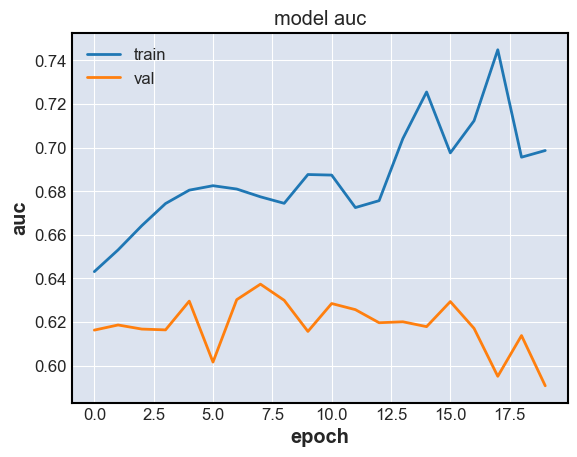

In [84]:
from matplotlib import pyplot as plt
metric = 'auc'
plt.figure()
plt.plot(history.history[metric])
plt.plot(history.history['val_'+metric])
plt.title('model '+metric)
plt.ylabel(metric,fontsize='large')
plt.xlabel('epoch',fontsize='large')
plt.legend(['train','val'],loc='best')
plt.show()

188/188 [==============================] - 2s 12ms/step


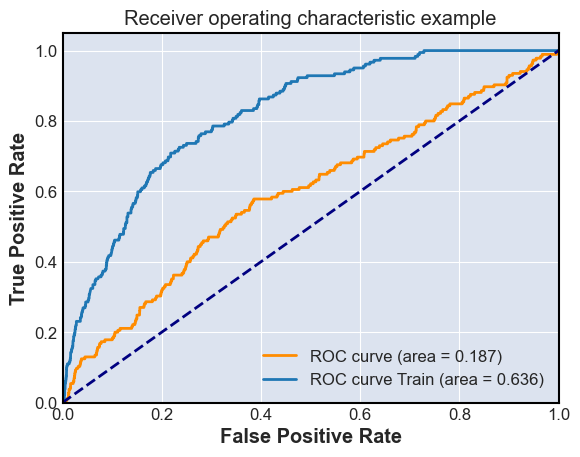

In [85]:
plot_roc_curve(img_train,y_train,img_test,y_test,model)

In [86]:
input_series = X
train_predictions = model.predict(img_train)
test_predictions = model.predict(img_test)

# Cut the distribution up into percentiles
percentiles = np.percentile(train_predictions,[90])

# if in the top 10 percentiles then put a bet on of £100
bet_amount = np.where(train_predictions>percentiles[0],100,0)
results = bet_amount*growth_train
print(f'Results is:{results.sum()}')

155/155 [==============================] - 2s 12ms/step
Results is:29.50398665886871


In [87]:
# Cut the distribution up into percentiles
percentiles = np.percentile(train_predictions,[90])

# if in the top 10 percentiles then put a bet on of £100
bet_amount = np.where(test_predictions>percentiles[0],100,0)
results = bet_amount*growth_test
print(f'Test Results is:{results.sum()}')

Test Results is:5.790924973119361


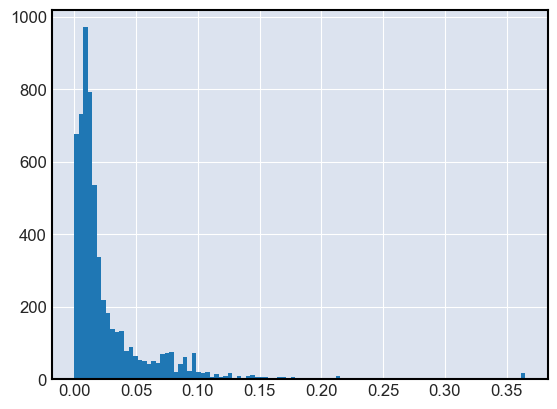

In [88]:
plt.hist(train_predictions,bins=100)
plt.show()

###### running a simulation

<a id='CNN_candlestick_hl'></a>
## 6.0 Conv2D with color with highs and lows (still no volume)

In [18]:
def convert_time_series_img(series,lower_bound,upper_bound,resolution):
    
    volume_series = series[:,0].ravel()
    close_series = series[:,1].ravel()
    open_series = series[:,2].ravel()
    high_series = series[:,3].ravel()
    low_series = series[:,4].ravel()

    levels = np.arange(lower_bound,upper_bound,resolution)
    levels = [-np.inf]+levels.tolist()+[np.inf]
    n_levels = len(levels)
    labels = np.arange(n_levels-1)

    #Y_volume = pd.cut(volume_series,levels,labels=labels[::-1])
    Y_close = pd.cut(close_series,levels,labels=labels[::-1])
    Y_open = pd.cut(open_series,levels,labels=labels[::-1])
    Y_high = pd.cut(high_series,levels,labels=labels[::-1])
    Y_low = pd.cut(low_series,levels,labels=labels[::-1])

    blank = np.full( (n_levels,21,3),0)
    X = np.arange(0,len(close_series))
    for x,c,o,h,l in zip(X,Y_close,Y_open,Y_high,Y_low):
        if o>=c:
            for y in range(c,o):
                # plotting the open close candle
                blank[y,x,0] = 60
                blank[y,x,1] = 240
                blank[y,x,2] = 60
            
            if h>o:
                for n,y in enumerate(range(o,h)):
                    # plotting the high candle
                    if n==0:
                        pass
                    else:
                        blank[y,x,0] = 255
                        blank[y,x,1] = 100
                        blank[y,x,2] = 255
                        
            if l<c:
                for n,y in enumerate(range(l,c)):
                    # plotting the high candle
                    if n==0:
                        pass
                    else:
                        blank[y,x,0] = 100
                        blank[y,x,1] = 255
                        blank[y,x,2] = 100
                        
                
        else:
            for y in range(o,c):
                blank[y,x,0] = 255
                blank[y,x,1] = 25
                blank[y,x,2] = 25
                
            if h>c:
                for n,y in enumerate(range(c,h)):
                    # plotting the high candle
                    if n==0:
                        pass
                    else:
                        blank[y,x,0] = 255
                        blank[y,x,1] = 100
                        blank[y,x,2] = 255
                        
            if l<o:
                for n,y in enumerate(range(l,o)):
                    # plotting the high candle
                    if n==0:
                        pass
                    else:
                        blank[y,x,0] = 100
                        blank[y,x,1] = 255
                        blank[y,x,2] = 100
        
    return blank

def plot_time_series(series):
    np_img = convert_time_series_img(series,0.99,1.01,0.0001)
    fig, axes = plt.subplots(figsize=(10,5))
    axes.imshow(np_img)
    plt.show()

In [90]:
import numpy as np
from PIL import Image

imgs = [convert_time_series_img(X_train[x,:,:],0.99,1.01,0.0001).astype(np.uint8) for x in range(len(X_train))]
imgs = [Image.fromarray(img) for img in imgs]
# duration is the number of milliseconds between frames; this is 40 frames per second
imgs[0].save("array_color.gif", save_all=True, append_images=imgs[1:], duration=50, loop=0)

In [91]:
img_train = np.stack([convert_time_series_img(X_train[x,:,:],0.99,1.01,0.0001) for x in range(len(X_train))])
img_test = np.stack([convert_time_series_img(X_test[x,:,:],0.99,1.01,0.0001) for x in range(len(X_test))])

In [92]:
model = keras.Sequential(
    [
        keras.Input(shape=(203, 21, 3)),
        keras.layers.Conv2D(32, kernel_size=(3, 3), activation="relu"),
        keras.layers.MaxPooling2D(pool_size=(3, 2)),
        keras.layers.Conv2D(32, kernel_size=(3, 3), activation="relu"),
        keras.layers.MaxPooling2D(pool_size=(3, 2)),
        keras.layers.Conv2D(64, kernel_size=(3, 3), activation="relu"),
        keras.layers.Flatten(),
        keras.layers.Dropout(0.9),
        #layers.Dense(200, activation="sigmoid"),
        #layers.Dropout(0.9),
        #layers.Dense(20, activation="sigmoid"),
        keras.layers.Dense(1, activation="sigmoid")
    ]
)

model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_33 (Conv2D)          (None, 201, 19, 32)       896       
                                                                 
 max_pooling2d_22 (MaxPoolin  (None, 67, 9, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_34 (Conv2D)          (None, 65, 7, 32)         9248      
                                                                 
 max_pooling2d_23 (MaxPoolin  (None, 21, 3, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_35 (Conv2D)          (None, 19, 1, 64)         18496     
                                                                 
 flatten_11 (Flatten)        (None, 1216)             

In [93]:
batch_size = 200
epochs = 20

optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)

model.compile(loss="binary_crossentropy", optimizer=optimizer, metrics=[tf.metrics.AUC(name='auc')])
callbacks = [keras.callbacks.EarlyStopping(patience=5,restore_best_weights=True)]
history = model.fit(img_train, y_train, batch_size=batch_size, epochs=epochs, verbose=1,validation_data=(img_test,y_test))

Epoch 1/20
30/30 [==============================] - 8s 245ms/step - loss: 2.8991 - auc: 0.4792 - val_loss: 0.3224 - val_auc: 0.5055
Epoch 2/20
30/30 [==============================] - 6s 213ms/step - loss: 0.3485 - auc: 0.5092 - val_loss: 0.2165 - val_auc: 0.4598
Epoch 3/20
30/30 [==============================] - 6s 213ms/step - loss: 0.2429 - auc: 0.5335 - val_loss: 0.2096 - val_auc: 0.4814
Epoch 4/20
30/30 [==============================] - 6s 213ms/step - loss: 0.2081 - auc: 0.5590 - val_loss: 0.1931 - val_auc: 0.5051
Epoch 5/20
30/30 [==============================] - 6s 209ms/step - loss: 0.1773 - auc: 0.6072 - val_loss: 0.1868 - val_auc: 0.5075
Epoch 6/20
30/30 [==============================] - 6s 208ms/step - loss: 0.1724 - auc: 0.6043 - val_loss: 0.1836 - val_auc: 0.5157
Epoch 7/20
30/30 [==============================] - 6s 207ms/step - loss: 0.1657 - auc: 0.5872 - val_loss: 0.1728 - val_auc: 0.5313
Epoch 8/20
30/30 [==============================] - 6s 207ms/step - loss: 0.

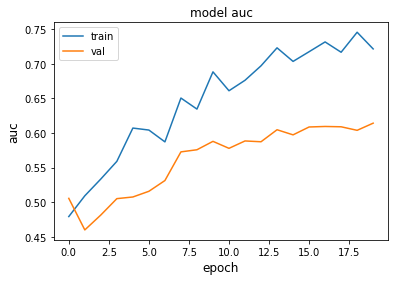

In [94]:
from matplotlib import pyplot as plt
metric = 'auc'
plt.figure()
plt.plot(history.history[metric])
plt.plot(history.history['val_'+metric])
plt.title('model '+metric)
plt.ylabel(metric,fontsize='large')
plt.xlabel('epoch',fontsize='large')
plt.legend(['train','val'],loc='best')
plt.show()

188/188 [==============================] - 2s 9ms/step


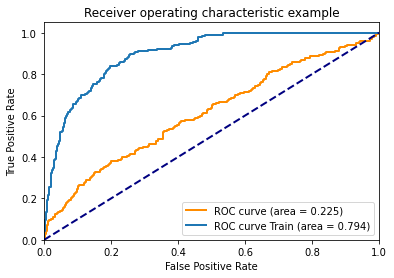

In [95]:
plot_roc_curve(img_train,y_train,img_test,y_test,model)

In [96]:
input_series = X
train_predictions = model.predict(img_train)
test_predictions = model.predict(img_test)

# Cut the distribution up into percentiles
percentiles = np.percentile(train_predictions,[90])

# if in the top 10 percentiles then put a bet on of £100
bet_amount = np.where(train_predictions>percentiles[0],100,0)
results = bet_amount*growth_train
print(f'Results is:{results.sum()}')

155/155 [==============================] - 1s 9ms/step
Results is:62.472592209983254


In [97]:
# Cut the distribution up into percentiles
percentiles = np.percentile(train_predictions,[90])

# if in the top 10 percentiles then put a bet on of £100
bet_amount = np.where(test_predictions>percentiles[0],100,0)
results = bet_amount*growth_test
print(f'Test Results is:{results.sum()}')

Test Results is:14.503626612130752


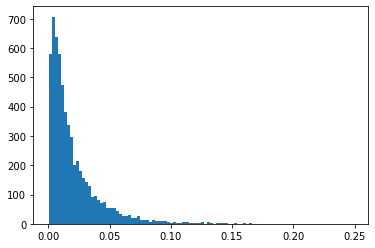

In [98]:
plt.hist(train_predictions,bins=100)
plt.show()

<a id='CNN_candlestick_volume'></a>
## 7.0 Conv2D with color with highs and lows and Volume

Here the model is of the same architecture, albeit the volume is concatenated onto the output of the convolution encoding layers. This means volume is simply a time series.

Other features can be added in this way, such as RSI or moving averages.

In [1]:
import tensorflow as tf
from tensorflow import keras

import pandas as pd
import numpy as np
import os
from matplotlib import pyplot as plt
from StockPredictionTools import plot_roc_curve, gini

In [2]:
file_loc = 'SPY_5min_2022-01-03T09.00.00_2022-03-25T14.10.00.csv'
df = pd.read_csv(os.path.join('data',file_loc),parse_dates=['datetime'])
df['date'] = df['datetime'].dt.date
df['time-delta'] = df['datetime'].diff().dt.seconds
for col in ['close']:
    df[f'{col}_diff'] = df[col].pct_change()

# Window of data we're working with
N = df.shape[0]
print(f'{N} ticks found')

# 2 hour lookback period
LOOKBACK = 2*(60/5)

# Growth requirement
GROWTH_LIMIT = 0.005

# outcome period 30min
HORIZON = 6

X = list()
y = list()
growth = list()

t =1
finish = False
counter = 0
while finish is False:
    
    counter+=1
    print(f'Counter:{counter}',end='\r')
    
    # check we have enough lookback data
    if t<22:
        t+=1
        continue
    
    # check we don't have enough data left then end the cycle
    if (N - t)<5:
        finish = True
        t+=1
        continue
        
    lookback_data = df.loc[t-20:t,['volume','close','open','high','low']].values
    lookback_data = lookback_data/lookback_data[-1]
    outcome_data = df.loc[t+1:t+6,'close_diff'].sum()>GROWTH_LIMIT
    growth_data = df.loc[t+1:t+6,'close_diff'].sum()
    
    X.append(lookback_data)
    y.append(outcome_data)
    growth.append(growth_data)
    
    t+=1
    
y = np.array(y).reshape(-1,1)
growth = np.array(growth).reshape(-1,1)
X = np.stack(X)

X_train = X[:6000].astype('float32')
X_test = X[6000:].astype('float32')

y_train = y[:6000].astype('float32')
y_test = y[6000:].astype('float32')

growth_train = growth[:6000].astype('float32')
growth_test = growth[6000:].astype('float32')

10965 ticks found


In [15]:
def convert_time_series_img(series,lower_bound,upper_bound,resolution):
    
    volume_series = series[:,0].ravel()
    close_series = series[:,1].ravel()
    open_series = series[:,2].ravel()
    high_series = series[:,3].ravel()
    low_series = series[:,4].ravel()

    levels = np.arange(lower_bound,upper_bound,resolution)
    levels = [-np.inf]+levels.tolist()+[np.inf]
    n_levels = len(levels)
    labels = np.arange(n_levels-1)

    #Y_volume = pd.cut(volume_series,levels,labels=labels[::-1])
    Y_close = pd.cut(close_series,levels,labels=labels[::-1])
    Y_open = pd.cut(open_series,levels,labels=labels[::-1])
    Y_high = pd.cut(high_series,levels,labels=labels[::-1])
    Y_low = pd.cut(low_series,levels,labels=labels[::-1])

    blank = np.full( (n_levels,21,3),0)
    X = np.arange(0,len(close_series))
    for x,c,o,h,l in zip(X,Y_close,Y_open,Y_high,Y_low):
        if o>=c:
            for y in range(c,o):
                # plotting the open close candle
                blank[y,x,0] = 60
                blank[y,x,1] = 240
                blank[y,x,2] = 60
            
            if h>o:
                for n,y in enumerate(range(o,h)):
                    # plotting the high candle
                    if n==0:
                        pass
                    else:
                        blank[y,x,0] = 255
                        blank[y,x,1] = 100
                        blank[y,x,2] = 255
                        
            if l<c:
                for n,y in enumerate(range(l,c)):
                    # plotting the high candle
                    if n==0:
                        pass
                    else:
                        blank[y,x,0] = 100
                        blank[y,x,1] = 255
                        blank[y,x,2] = 100
                        
                
        else:
            for y in range(o,c):
                blank[y,x,0] = 255
                blank[y,x,1] = 25
                blank[y,x,2] = 25
                
            if h>c:
                for n,y in enumerate(range(c,h)):
                    # plotting the high candle
                    if n==0:
                        pass
                    else:
                        blank[y,x,0] = 255
                        blank[y,x,1] = 100
                        blank[y,x,2] = 255
                        
            if l<o:
                for n,y in enumerate(range(l,o)):
                    # plotting the high candle
                    if n==0:
                        pass
                    else:
                        blank[y,x,0] = 100
                        blank[y,x,1] = 255
                        blank[y,x,2] = 100
        
    return blank

def plot_time_series(series):
    np_img = convert_time_series_img(series,0.99,1.01,0.0001)
    fig, axes = plt.subplots(figsize=(10,5))
    axes.imshow(np_img)
    plt.show()

In [16]:
img_train = np.stack([convert_time_series_img(X_train[x,:,:],0.99,1.01,0.0001) for x in range(len(X_train))]).astype('float32')
img_test = np.stack([convert_time_series_img(X_test[x,:,:],0.99,1.01,0.0001) for x in range(len(X_test))]).astype('float32')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


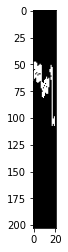

In [17]:
plt.imshow(img_train[50,:,:])

In [18]:
volume_train = X_train[:,:,0]
volume_test = X_test[:,:,0]

In [19]:
class StonkModel(tf.keras.Model):
    
    def __init__(self):
        super().__init__()
        # activate all the layers
        self.conv0 = keras.layers.Conv2D(32, kernel_size=(3, 3), activation="relu")
        self.maxpool2D_0 = keras.layers.MaxPooling2D(pool_size=(3, 2))
        self.conv1 = keras.layers.Conv2D(64, kernel_size=(3, 3), activation="relu")
        self.maxpool2D_1 = keras.layers.MaxPooling2D(pool_size=(3, 2))
        self.conv2 =  keras.layers.Conv2D(32, kernel_size=(3, 3), activation="relu")
        self.flatten = keras.layers.Flatten()
        self.dropout = keras.layers.Dropout(0.9)
        self.dense = keras.layers.Dense(1, activation="sigmoid")
        
        self.concat =  tf.keras.layers.Concatenate()
        
        

    def call(self, inputs, training=False):
        
        x,v = inputs[0],inputs[1]
        
        # Put the chart through the cnn
        x = self.conv0(x)
        x = self.maxpool2D_0(x)
        x = self.conv1(x)
        x = self.maxpool2D_1(x)
        x = self.conv2(x)
        x = self.flatten(x)
        if training:
            x = self.dropout(x, training=training)
            
        # concatenate with the volume info
        x = self.concat([x,v])
        
        return self.dense(x)

In [36]:
model = StonkModel()
_ = model([img_train,volume_train])

In [37]:
keras.utils.plot_model(model, "my_first_model.png")

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model/model_to_dot to work.


In [38]:
batch_size = 200
epochs = 7

optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)

model.compile(loss="binary_crossentropy", optimizer=optimizer, metrics=[tf.metrics.AUC(name='auc')])
callbacks = [keras.callbacks.EarlyStopping(patience=5,restore_best_weights=True)]
history = model.fit([img_train,volume_train],y_train,
                    batch_size=batch_size, 
                    epochs=epochs, 
                    verbose=1,
                    validation_data=([img_test,volume_test],y_test))

Epoch 1/7
30/30 [==============================] - 7s 218ms/step - loss: 2.8768 - auc: 0.5286 - val_loss: 0.2542 - val_auc: 0.5895
Epoch 2/7
30/30 [==============================] - 7s 222ms/step - loss: 0.5265 - auc: 0.6035 - val_loss: 0.2035 - val_auc: 0.6139
Epoch 3/7
30/30 [==============================] - 6s 213ms/step - loss: 0.3641 - auc: 0.6350 - val_loss: 0.1865 - val_auc: 0.6343
Epoch 4/7
30/30 [==============================] - 6s 204ms/step - loss: 0.2860 - auc: 0.6372 - val_loss: 0.1733 - val_auc: 0.6591
Epoch 5/7
30/30 [==============================] - 6s 203ms/step - loss: 0.2302 - auc: 0.6673 - val_loss: 0.1677 - val_auc: 0.6727
Epoch 6/7
30/30 [==============================] - 6s 204ms/step - loss: 0.2136 - auc: 0.6833 - val_loss: 0.1673 - val_auc: 0.6724
Epoch 7/7
30/30 [==============================] - 6s 203ms/step - loss: 0.1999 - auc: 0.7039 - val_loss: 0.1684 - val_auc: 0.6734


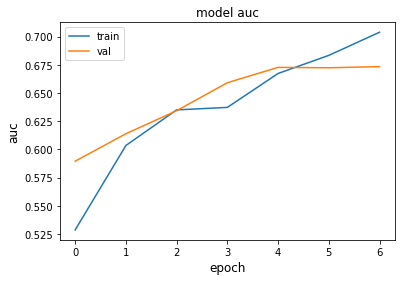

In [39]:
from matplotlib import pyplot as plt
metric = 'auc'
plt.figure()
plt.plot(history.history[metric])
plt.plot(history.history['val_'+metric])
plt.title('model '+metric)
plt.ylabel(metric,fontsize='large')
plt.xlabel('epoch',fontsize='large')
plt.legend(['train','val'],loc='best')
plt.show()

188/188 [==============================] - 2s 9ms/step


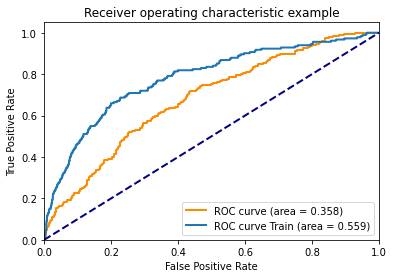

In [40]:
plot_roc_curve([img_train,volume_train],y_train,[img_test,volume_test],y_test,model)

In [41]:
input_series = X
train_predictions = model.predict([img_train,volume_train])
test_predictions = model.predict([img_test,volume_test])

# Cut the distribution up into percentiles
percentiles = np.percentile(train_predictions,[90])

# if in the top 10 percentiles then put a bet on of £100
bet_amount = np.where(train_predictions>percentiles[0],100,0)
results = bet_amount*growth_train
print(f'Results is:{results.sum()}')

155/155 [==============================] - 1s 9ms/step
Results is:26.29195938925477


In [42]:
# Cut the distribution up into percentiles
percentiles = np.percentile(train_predictions,[90])

# if in the top 10 percentiles then put a bet on of £100
bet_amount = np.where(test_predictions>percentiles[0],100,0)
results = bet_amount*growth_test
print(f'Test Results is:{results.sum()}')

Test Results is:14.999145746361364


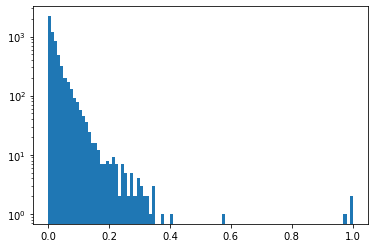

In [43]:
plt.hist(train_predictions,bins=100)
plt.yscale('log')
plt.show()

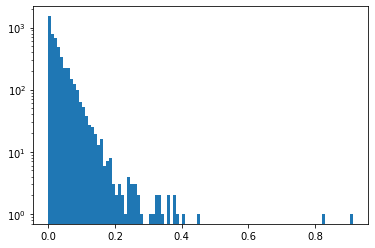

In [44]:
plt.hist(test_predictions,bins=100)
plt.yscale('log')
plt.show()

<AxesSubplot:xlabel='prediction', ylabel='results'>

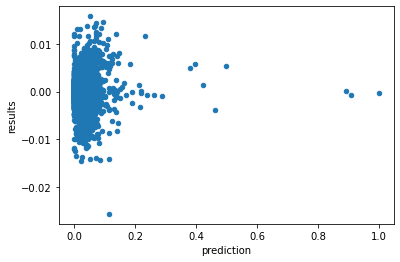

In [156]:
results = pd.DataFrame({'prediction':train_predictions.ravel(),'results':growth_train.ravel()})
results.plot.scatter(x='prediction',y='results')
plt.xscale('log')

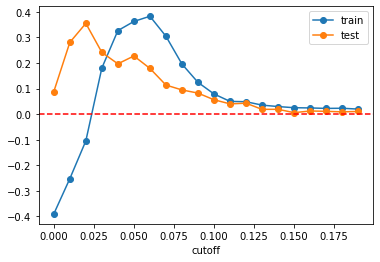

In [172]:
results = pd.DataFrame({'prediction':train_predictions.ravel(),'results':growth_train.ravel()})
profit = list()
for i in np.arange(0,0.2,0.01):
    profit.append({'cutoff':i,'profit_perc':results[results.prediction>=i].results.sum()})
axes = pd.DataFrame.from_records(profit).plot(x='cutoff',y='profit_perc',marker='o',label='train')

profit_test = list()
results_test = pd.DataFrame({'prediction':test_predictions.ravel(),'results':growth_test.ravel()})
for i in np.arange(0,0.2,0.01):
    profit_test.append({'cutoff':i,'profit_perc':results_test[results_test.prediction>=i].results.sum()})
profit_test_df = pd.DataFrame.from_records(profit_test)
profit_test_df.plot(x='cutoff',y='profit_perc',marker='o',label='test',ax=axes)
axes.axhline(0,ls='--',c='r')
plt.show()

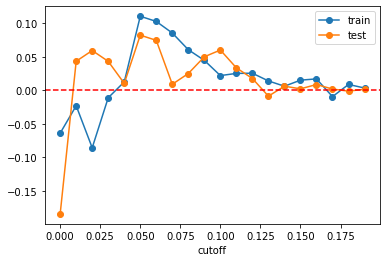

In [232]:
results = pd.DataFrame({'prediction':train_predictions.ravel(),'results':growth_train.ravel()})
profit = list()
for i in np.arange(0,0.2,0.01):
    profit.append({'cutoff':i,'profit_perc':results[results.prediction>=i].sample(frac=0.3).results.sum()})
axes = pd.DataFrame.from_records(profit).plot(x='cutoff',y='profit_perc',marker='o',label='train')

profit_test = list()
results_test = pd.DataFrame({'prediction':test_predictions.ravel(),'results':growth_test.ravel()})
for i in np.arange(0,0.2,0.01):
    profit_test.append({'cutoff':i,'profit_perc':results_test[results_test.prediction>=i].sample(frac=0.3).results.sum()})
profit_test_df = pd.DataFrame.from_records(profit_test)
profit_test_df.plot(x='cutoff',y='profit_perc',marker='o',label='test',ax=axes)
axes.axhline(0,ls='--',c='r')
plt.show()

In [216]:
# More refined simulation
import tqdm
from collections import defaultdict
portfolio = 1000
countdown_timer = 0
no_intervals = len(img_test)
results = []
probabilities = list()

# Realistically this will be more like 0.00003
spread_cost = 0.0005

records = list()

for n in tqdm.tqdm(range(no_intervals)):
    
    interval_data = [np.expand_dims(img_test[n,:,:,:],axis=0),np.expand_dims(volume_test[n],axis=0)]
    prediction = model.predict(interval_data,verbose=0)
    probabilities.append(prediction.ravel()[0])
    if countdown_timer>0:
        countdown_timer = countdown_timer-1
        results.append(results[-1])
        continue
    
    results.append(portfolio)
    if (prediction>0.05)&(portfolio>0):
        # buy and hold for 30min
        print(f'Bought at iter {n}, result is:{growth_test[n][0]:0.3%}')
        portfolio = portfolio*(1+growth_test[n][0] - spread_cost) 
        countdown_timer = 5
        
        records.append({'prediction':prediction.ravel()[0],'results':growth_test[n][0]})

  0%|                                                                                 | 6/4920 [00:00<02:56, 27.87it/s]

Bought at iter 2, result is:0.271%


  0%|▏                                                                               | 12/4920 [00:00<03:00, 27.26it/s]

Bought at iter 8, result is:0.023%


  0%|▎                                                                               | 21/4920 [00:00<03:03, 26.73it/s]

Bought at iter 18, result is:-0.031%


  2%|█▋                                                                             | 105/4920 [00:03<02:57, 27.13it/s]

Bought at iter 100, result is:0.034%


  2%|█▉                                                                             | 117/4920 [00:04<02:55, 27.35it/s]

Bought at iter 112, result is:-0.204%


  3%|██                                                                             | 129/4920 [00:04<02:53, 27.62it/s]

Bought at iter 124, result is:-0.090%


  3%|██▎                                                                            | 141/4920 [00:05<02:49, 28.12it/s]

Bought at iter 135, result is:-0.174%
Bought at iter 141, result is:0.204%


  4%|███                                                                            | 189/4920 [00:06<02:52, 27.49it/s]

Bought at iter 185, result is:-0.204%


  4%|███▏                                                                           | 198/4920 [00:07<02:50, 27.68it/s]

Bought at iter 193, result is:-0.306%
Bought at iter 199, result is:0.053%


  4%|███▎                                                                           | 210/4920 [00:07<02:48, 27.88it/s]

Bought at iter 206, result is:-0.020%


  6%|█████                                                                          | 312/4920 [00:11<02:48, 27.27it/s]

Bought at iter 308, result is:0.087%


  7%|█████▏                                                                         | 324/4920 [00:11<02:50, 26.91it/s]

Bought at iter 318, result is:0.161%


  7%|█████▍                                                                         | 336/4920 [00:12<02:48, 27.18it/s]

Bought at iter 331, result is:-0.272%


  7%|█████▌                                                                         | 345/4920 [00:12<02:49, 26.91it/s]

Bought at iter 339, result is:0.198%


  8%|█████▉                                                                         | 372/4920 [00:13<02:49, 26.87it/s]

Bought at iter 367, result is:0.251%


  8%|██████▏                                                                        | 387/4920 [00:14<02:43, 27.71it/s]

Bought at iter 380, result is:0.107%


  8%|██████▎                                                                        | 393/4920 [00:14<02:43, 27.72it/s]

Bought at iter 387, result is:-0.703%


  8%|██████▍                                                                        | 399/4920 [00:14<02:45, 27.31it/s]

Bought at iter 395, result is:-0.077%


  9%|███████▏                                                                       | 450/4920 [00:16<02:52, 25.98it/s]

Bought at iter 447, result is:0.173%


 10%|███████▌                                                                       | 468/4920 [00:17<02:42, 27.33it/s]

Bought at iter 463, result is:0.491%


 10%|███████▉                                                                       | 492/4920 [00:17<02:42, 27.24it/s]

Bought at iter 486, result is:-0.129%


 10%|████████                                                                       | 501/4920 [00:18<02:45, 26.76it/s]

Bought at iter 495, result is:-0.069%


 10%|████████▎                                                                      | 516/4920 [00:18<02:46, 26.43it/s]

Bought at iter 512, result is:0.524%


 11%|████████▍                                                                      | 525/4920 [00:19<02:45, 26.64it/s]

Bought at iter 521, result is:-0.213%


 11%|████████▋                                                                      | 540/4920 [00:19<02:38, 27.65it/s]

Bought at iter 535, result is:-0.170%


 11%|█████████                                                                      | 564/4920 [00:20<02:44, 26.51it/s]

Bought at iter 559, result is:-0.494%


 12%|█████████▏                                                                     | 570/4920 [00:20<02:44, 26.52it/s]

Bought at iter 565, result is:0.010%


 12%|█████████▏                                                                     | 576/4920 [00:21<02:39, 27.30it/s]

Bought at iter 572, result is:0.637%


 12%|█████████▎                                                                     | 582/4920 [00:21<02:44, 26.44it/s]

Bought at iter 578, result is:0.168%


 12%|█████████▍                                                                     | 591/4920 [00:21<02:46, 25.95it/s]

Bought at iter 587, result is:0.205%


 14%|██████████▊                                                                    | 675/4920 [00:24<02:35, 27.34it/s]

Bought at iter 669, result is:0.039%


 14%|███████████▏                                                                   | 693/4920 [00:25<02:33, 27.60it/s]

Bought at iter 687, result is:-0.136%


 14%|███████████▍                                                                   | 711/4920 [00:26<02:31, 27.74it/s]

Bought at iter 707, result is:-0.469%


 15%|███████████▌                                                                   | 717/4920 [00:26<02:37, 26.73it/s]

Bought at iter 713, result is:-0.191%


 15%|███████████▋                                                                   | 729/4920 [00:26<03:29, 20.02it/s]

Bought at iter 723, result is:0.024%


 15%|███████████▊                                                                   | 735/4920 [00:27<03:08, 22.24it/s]

Bought at iter 731, result is:0.307%


 15%|████████████▏                                                                  | 756/4920 [00:27<02:35, 26.82it/s]

Bought at iter 750, result is:0.104%


 16%|████████████▍                                                                  | 771/4920 [00:28<02:38, 26.17it/s]

Bought at iter 766, result is:-0.259%


 16%|████████████▍                                                                  | 777/4920 [00:28<02:34, 26.79it/s]

Bought at iter 773, result is:-0.303%


 16%|████████████▌                                                                  | 786/4920 [00:29<02:30, 27.51it/s]

Bought at iter 780, result is:0.000%


 17%|█████████████▍                                                                 | 834/4920 [00:30<02:26, 27.89it/s]

Bought at iter 829, result is:0.061%


 17%|█████████████▋                                                                 | 852/4920 [00:31<02:23, 28.26it/s]

Bought at iter 845, result is:0.090%


 17%|█████████████▊                                                                 | 858/4920 [00:31<02:23, 28.40it/s]

Bought at iter 853, result is:-0.240%


 18%|█████████████▊                                                                 | 864/4920 [00:31<02:23, 28.24it/s]

Bought at iter 859, result is:0.315%


 18%|█████████████▉                                                                 | 870/4920 [00:32<02:24, 27.95it/s]

Bought at iter 865, result is:-0.313%


 18%|██████████████                                                                 | 876/4920 [00:32<02:27, 27.40it/s]

Bought at iter 871, result is:0.129%


 18%|██████████████▏                                                                | 882/4920 [00:32<02:33, 26.33it/s]

Bought at iter 877, result is:-0.155%


 18%|██████████████▎                                                                | 888/4920 [00:32<02:32, 26.38it/s]

Bought at iter 883, result is:0.266%


 18%|██████████████▍                                                                | 897/4920 [00:33<02:30, 26.69it/s]

Bought at iter 892, result is:0.639%


 18%|██████████████▍                                                                | 903/4920 [00:33<02:29, 26.95it/s]

Bought at iter 898, result is:0.563%


 18%|██████████████▌                                                                | 909/4920 [00:33<02:31, 26.43it/s]

Bought at iter 904, result is:-0.107%


 19%|██████████████▋                                                                | 915/4920 [00:33<02:29, 26.79it/s]

Bought at iter 910, result is:0.596%


 19%|██████████████▉                                                                | 927/4920 [00:34<02:26, 27.20it/s]

Bought at iter 921, result is:-0.104%


 19%|██████████████▉                                                                | 933/4920 [00:34<02:26, 27.25it/s]

Bought at iter 929, result is:0.376%


 19%|███████████████▏                                                               | 942/4920 [00:34<02:27, 26.97it/s]

Bought at iter 936, result is:0.025%


 19%|███████████████▏                                                               | 948/4920 [00:35<02:26, 27.13it/s]

Bought at iter 944, result is:-0.126%


 19%|███████████████▎                                                               | 954/4920 [00:35<02:28, 26.67it/s]

Bought at iter 950, result is:1.236%


 20%|███████████████▍                                                               | 960/4920 [00:35<02:27, 26.86it/s]

Bought at iter 956, result is:0.216%


 20%|███████████████▌                                                               | 969/4920 [00:35<02:25, 27.23it/s]

Bought at iter 964, result is:0.392%


 20%|███████████████▋                                                               | 975/4920 [00:36<02:23, 27.46it/s]

Bought at iter 971, result is:-0.484%


 21%|████████████████▏                                                             | 1020/4920 [00:37<02:19, 27.86it/s]

Bought at iter 1016, result is:-0.960%


 21%|████████████████▎                                                             | 1029/4920 [00:37<02:19, 27.82it/s]

Bought at iter 1024, result is:0.163%


 21%|████████████████▍                                                             | 1035/4920 [00:38<02:19, 27.77it/s]

Bought at iter 1031, result is:0.339%


 21%|████████████████▋                                                             | 1053/4920 [00:38<02:22, 27.20it/s]

Bought at iter 1050, result is:0.092%


 22%|████████████████▉                                                             | 1068/4920 [00:39<02:18, 27.77it/s]

Bought at iter 1063, result is:0.458%


 22%|█████████████████                                                             | 1074/4920 [00:39<02:18, 27.78it/s]

Bought at iter 1069, result is:0.592%


 22%|█████████████████▏                                                            | 1083/4920 [00:39<02:17, 28.00it/s]

Bought at iter 1077, result is:-0.267%


 22%|█████████████████▎                                                            | 1089/4920 [00:40<02:20, 27.34it/s]

Bought at iter 1083, result is:-0.046%


 22%|█████████████████▎                                                            | 1095/4920 [00:40<02:18, 27.54it/s]

Bought at iter 1089, result is:0.144%


 22%|█████████████████▍                                                            | 1101/4920 [00:40<02:18, 27.61it/s]

Bought at iter 1097, result is:0.514%


 22%|█████████████████▌                                                            | 1107/4920 [00:40<02:20, 27.17it/s]

Bought at iter 1103, result is:0.483%


 23%|█████████████████▋                                                            | 1116/4920 [00:41<02:19, 27.36it/s]

Bought at iter 1111, result is:0.227%


 23%|██████████████████                                                            | 1140/4920 [00:41<02:15, 27.98it/s]

Bought at iter 1135, result is:0.035%


 25%|███████████████████▎                                                          | 1218/4920 [00:44<02:11, 28.05it/s]

Bought at iter 1212, result is:-0.062%


 26%|███████████████████▉                                                          | 1257/4920 [00:46<02:12, 27.71it/s]

Bought at iter 1252, result is:-0.014%


 26%|████████████████████                                                          | 1266/4920 [00:46<02:14, 27.17it/s]

Bought at iter 1260, result is:-0.146%


 26%|████████████████████▎                                                         | 1284/4920 [00:47<02:12, 27.49it/s]

Bought at iter 1279, result is:-0.129%
Bought at iter 1285, result is:0.459%


 26%|████████████████████▌                                                         | 1296/4920 [00:47<02:12, 27.28it/s]

Bought at iter 1291, result is:0.225%


 27%|████████████████████▊                                                         | 1314/4920 [00:48<02:08, 28.02it/s]

Bought at iter 1309, result is:-0.418%


 27%|█████████████████████▏                                                        | 1338/4920 [00:49<02:06, 28.33it/s]

Bought at iter 1332, result is:-0.268%


 27%|█████████████████████▎                                                        | 1344/4920 [00:49<02:06, 28.31it/s]

Bought at iter 1340, result is:-0.120%


 28%|█████████████████████▍                                                        | 1353/4920 [00:49<02:06, 28.22it/s]

Bought at iter 1348, result is:0.462%


 28%|█████████████████████▌                                                        | 1359/4920 [00:50<02:19, 25.61it/s]

Bought at iter 1354, result is:0.163%


 29%|██████████████████████▍                                                       | 1413/4920 [00:52<02:17, 25.52it/s]

Bought at iter 1408, result is:-0.264%


 29%|██████████████████████▉                                                       | 1446/4920 [00:53<02:09, 26.74it/s]

Bought at iter 1443, result is:0.141%


 30%|███████████████████████                                                       | 1455/4920 [00:53<02:06, 27.37it/s]

Bought at iter 1452, result is:0.540%


 30%|███████████████████████▎                                                      | 1470/4920 [00:54<02:05, 27.55it/s]

Bought at iter 1464, result is:0.221%


 30%|███████████████████████▍                                                      | 1476/4920 [00:54<02:10, 26.32it/s]

Bought at iter 1470, result is:-0.349%


 30%|███████████████████████▍                                                      | 1482/4920 [00:54<02:09, 26.53it/s]

Bought at iter 1476, result is:-0.121%


 30%|███████████████████████▌                                                      | 1488/4920 [00:55<02:16, 25.08it/s]

Bought at iter 1484, result is:0.315%


 30%|███████████████████████▊                                                      | 1500/4920 [00:55<02:12, 25.76it/s]

Bought at iter 1494, result is:-0.457%


 31%|███████████████████████▉                                                      | 1506/4920 [00:55<02:12, 25.83it/s]

Bought at iter 1502, result is:0.292%


 31%|████████████████████████                                                      | 1515/4920 [00:56<02:16, 24.90it/s]

Bought at iter 1510, result is:-0.461%


 31%|████████████████████████▎                                                     | 1536/4920 [00:56<02:02, 27.57it/s]

Bought at iter 1531, result is:0.154%


 32%|████████████████████████▌                                                     | 1551/4920 [00:57<02:29, 22.59it/s]

Bought at iter 1545, result is:0.788%


 33%|█████████████████████████▍                                                    | 1605/4920 [00:59<01:58, 27.93it/s]

Bought at iter 1601, result is:0.313%


 33%|█████████████████████████▌                                                    | 1614/4920 [00:59<01:58, 27.81it/s]

Bought at iter 1610, result is:-0.286%


 33%|██████████████████████████                                                    | 1641/4920 [01:00<01:59, 27.55it/s]

Bought at iter 1637, result is:0.104%


 33%|██████████████████████████                                                    | 1647/4920 [01:01<01:56, 28.20it/s]

Bought at iter 1643, result is:-0.299%


 34%|██████████████████████████▏                                                   | 1653/4920 [01:01<01:58, 27.56it/s]

Bought at iter 1649, result is:0.130%


 34%|██████████████████████████▍                                                   | 1665/4920 [01:01<01:58, 27.40it/s]

Bought at iter 1659, result is:0.472%


 34%|██████████████████████████▍                                                   | 1668/4920 [01:01<01:59, 27.15it/s]

Bought at iter 1665, result is:-0.393%


 34%|██████████████████████████▌                                                   | 1677/4920 [01:02<01:57, 27.55it/s]

Bought at iter 1672, result is:0.036%


 34%|██████████████████████████▋                                                   | 1683/4920 [01:02<02:34, 20.92it/s]

Bought at iter 1679, result is:0.387%


 34%|██████████████████████████▊                                                   | 1689/4920 [01:02<02:13, 24.23it/s]

Bought at iter 1685, result is:-0.139%


 37%|█████████████████████████████                                                 | 1833/4920 [01:08<01:52, 27.49it/s]

Bought at iter 1827, result is:-0.048%


 37%|█████████████████████████████▏                                                | 1842/4920 [01:08<02:02, 25.21it/s]

Bought at iter 1838, result is:0.068%


 38%|█████████████████████████████▎                                                | 1851/4920 [01:08<01:53, 26.93it/s]

Bought at iter 1846, result is:-0.256%


 38%|█████████████████████████████▍                                                | 1857/4920 [01:09<01:50, 27.75it/s]

Bought at iter 1852, result is:-0.150%


 38%|█████████████████████████████▌                                                | 1863/4920 [01:09<01:48, 28.19it/s]

Bought at iter 1858, result is:-0.467%


 38%|█████████████████████████████▋                                                | 1869/4920 [01:09<01:54, 26.69it/s]

Bought at iter 1865, result is:-0.273%


 38%|█████████████████████████████▊                                                | 1878/4920 [01:09<01:59, 25.55it/s]

Bought at iter 1874, result is:0.100%


 38%|██████████████████████████████                                                | 1893/4920 [01:10<01:53, 26.75it/s]

Bought at iter 1888, result is:-0.091%


 39%|██████████████████████████████▎                                               | 1914/4920 [01:11<01:48, 27.77it/s]

Bought at iter 1908, result is:-0.415%
Bought at iter 1914, result is:-0.460%


 39%|██████████████████████████████▌                                               | 1926/4920 [01:11<01:46, 28.17it/s]

Bought at iter 1920, result is:-0.201%


 39%|██████████████████████████████▋                                               | 1932/4920 [01:11<01:49, 27.31it/s]

Bought at iter 1926, result is:0.402%


 40%|███████████████████████████████▎                                              | 1977/4920 [01:13<01:47, 27.25it/s]

Bought at iter 1971, result is:-0.878%


 40%|███████████████████████████████▍                                              | 1983/4920 [01:13<01:46, 27.45it/s]

Bought at iter 1977, result is:0.776%


 41%|████████████████████████████████▏                                             | 2028/4920 [01:15<01:44, 27.72it/s]

Bought at iter 2024, result is:0.030%


 41%|████████████████████████████████▎                                             | 2037/4920 [01:15<01:42, 28.20it/s]

Bought at iter 2032, result is:-0.354%


 42%|████████████████████████████████▍                                             | 2046/4920 [01:16<01:44, 27.47it/s]

Bought at iter 2042, result is:-0.373%


 42%|████████████████████████████████▌                                             | 2052/4920 [01:16<01:44, 27.48it/s]

Bought at iter 2048, result is:-0.213%


 42%|████████████████████████████████▋                                             | 2061/4920 [01:16<01:44, 27.35it/s]

Bought at iter 2057, result is:-0.326%


 42%|████████████████████████████████▊                                             | 2073/4920 [01:16<01:46, 26.79it/s]

Bought at iter 2069, result is:0.026%


 42%|█████████████████████████████████                                             | 2082/4920 [01:17<01:44, 27.05it/s]

Bought at iter 2076, result is:-0.098%


 42%|█████████████████████████████████▏                                            | 2091/4920 [01:17<01:44, 27.01it/s]

Bought at iter 2086, result is:-0.217%


 43%|█████████████████████████████████▎                                            | 2103/4920 [01:18<01:49, 25.81it/s]

Bought at iter 2097, result is:0.171%


 43%|█████████████████████████████████▋                                            | 2124/4920 [01:18<01:41, 27.42it/s]

Bought at iter 2119, result is:0.368%


 44%|██████████████████████████████████▌                                           | 2181/4920 [01:20<01:41, 27.03it/s]

Bought at iter 2175, result is:0.146%


 45%|██████████████████████████████████▋                                           | 2190/4920 [01:21<01:39, 27.37it/s]

Bought at iter 2186, result is:-0.237%


 45%|██████████████████████████████████▉                                           | 2202/4920 [01:21<01:35, 28.32it/s]

Bought at iter 2196, result is:0.186%


 45%|███████████████████████████████████                                           | 2211/4920 [01:22<01:35, 28.29it/s]

Bought at iter 2204, result is:0.397%


 45%|███████████████████████████████████▏                                          | 2217/4920 [01:22<01:35, 28.19it/s]

Bought at iter 2212, result is:-0.093%
Bought at iter 2218, result is:0.286%


 45%|███████████████████████████████████▍                                          | 2232/4920 [01:22<01:36, 27.82it/s]

Bought at iter 2226, result is:0.258%


 45%|███████████████████████████████████▍                                          | 2238/4920 [01:23<01:36, 27.84it/s]

Bought at iter 2232, result is:-0.661%


 46%|███████████████████████████████████▌                                          | 2244/4920 [01:23<01:35, 27.94it/s]

Bought at iter 2239, result is:-0.413%


 46%|███████████████████████████████████▋                                          | 2250/4920 [01:23<01:36, 27.69it/s]

Bought at iter 2245, result is:-0.120%
Bought at iter 2251, result is:0.195%


 46%|███████████████████████████████████▉                                          | 2265/4920 [01:24<01:34, 28.12it/s]

Bought at iter 2259, result is:-0.233%


 46%|████████████████████████████████████                                          | 2271/4920 [01:24<01:34, 28.11it/s]

Bought at iter 2266, result is:-0.243%


 46%|████████████████████████████████████                                          | 2277/4920 [01:24<01:34, 27.95it/s]

Bought at iter 2272, result is:0.029%


 47%|████████████████████████████████████▌                                         | 2307/4920 [01:25<01:32, 28.40it/s]

Bought at iter 2302, result is:0.132%


 47%|████████████████████████████████████▋                                         | 2313/4920 [01:25<01:31, 28.36it/s]

Bought at iter 2308, result is:-0.554%


 48%|█████████████████████████████████████▍                                        | 2364/4920 [01:27<01:30, 28.19it/s]

Bought at iter 2360, result is:0.003%


 49%|██████████████████████████████████████                                        | 2403/4920 [01:28<01:29, 28.13it/s]

Bought at iter 2398, result is:-0.545%


 49%|██████████████████████████████████████▏                                       | 2412/4920 [01:29<01:29, 28.09it/s]

Bought at iter 2408, result is:-0.328%


 49%|██████████████████████████████████████▎                                       | 2418/4920 [01:29<01:29, 28.02it/s]

Bought at iter 2414, result is:0.227%


 49%|██████████████████████████████████████▌                                       | 2430/4920 [01:29<01:29, 27.95it/s]

Bought at iter 2426, result is:-0.526%


 50%|██████████████████████████████████████▋                                       | 2439/4920 [01:30<01:29, 27.77it/s]

Bought at iter 2435, result is:-0.336%


 50%|██████████████████████████████████████▊                                       | 2448/4920 [01:30<01:28, 27.97it/s]

Bought at iter 2442, result is:-0.379%
Bought at iter 2448, result is:0.267%


 50%|███████████████████████████████████████                                       | 2460/4920 [01:30<01:28, 27.69it/s]

Bought at iter 2454, result is:1.082%


 50%|███████████████████████████████████████                                       | 2466/4920 [01:31<01:27, 28.20it/s]

Bought at iter 2460, result is:0.667%


 50%|███████████████████████████████████████▏                                      | 2475/4920 [01:31<01:26, 28.25it/s]

Bought at iter 2469, result is:-1.134%
Bought at iter 2475, result is:-0.619%


 51%|███████████████████████████████████████▍                                      | 2487/4920 [01:31<01:26, 28.12it/s]

Bought at iter 2481, result is:0.370%


 51%|███████████████████████████████████████▌                                      | 2493/4920 [01:32<01:25, 28.47it/s]

Bought at iter 2488, result is:0.191%


 51%|███████████████████████████████████████▋                                      | 2502/4920 [01:32<01:29, 26.89it/s]

Bought at iter 2497, result is:-0.661%


 51%|███████████████████████████████████████▊                                      | 2508/4920 [01:32<01:32, 26.13it/s]

Bought at iter 2503, result is:-0.303%


 52%|████████████████████████████████████████▊                                     | 2571/4920 [01:35<01:28, 26.41it/s]

Bought at iter 2566, result is:0.054%


 52%|████████████████████████████████████████▉                                     | 2580/4920 [01:35<01:28, 26.31it/s]

Bought at iter 2574, result is:0.173%


 53%|█████████████████████████████████████████▎                                    | 2604/4920 [01:36<01:28, 26.28it/s]

Bought at iter 2600, result is:0.203%


 53%|█████████████████████████████████████████▍                                    | 2610/4920 [01:36<01:27, 26.33it/s]

Bought at iter 2606, result is:-0.273%


 53%|█████████████████████████████████████████▍                                    | 2616/4920 [01:36<01:27, 26.30it/s]

Bought at iter 2613, result is:-0.178%


 53%|█████████████████████████████████████████▌                                    | 2625/4920 [01:37<01:45, 21.84it/s]

Bought at iter 2620, result is:0.331%


 53%|█████████████████████████████████████████▋                                    | 2631/4920 [01:37<01:35, 23.92it/s]

Bought at iter 2627, result is:0.139%


 54%|█████████████████████████████████████████▊                                    | 2640/4920 [01:37<01:28, 25.72it/s]

Bought at iter 2634, result is:0.001%


 54%|█████████████████████████████████████████▉                                    | 2646/4920 [01:38<01:28, 25.59it/s]

Bought at iter 2642, result is:0.157%


 54%|██████████████████████████████████████████▏                                   | 2658/4920 [01:38<01:26, 26.28it/s]

Bought at iter 2652, result is:0.217%


 55%|██████████████████████████████████████████▋                                   | 2694/4920 [01:39<01:23, 26.71it/s]

Bought at iter 2690, result is:-0.457%


 56%|███████████████████████████████████████████▊                                  | 2760/4920 [01:42<01:24, 25.65it/s]

Bought at iter 2754, result is:0.090%


 56%|███████████████████████████████████████████▉                                  | 2769/4920 [01:42<01:22, 25.94it/s]

Bought at iter 2765, result is:-0.210%


 57%|████████████████████████████████████████████                                  | 2781/4920 [01:43<01:19, 26.86it/s]

Bought at iter 2776, result is:-0.092%


 57%|████████████████████████████████████████████▎                                 | 2793/4920 [01:43<01:16, 27.68it/s]

Bought at iter 2789, result is:-0.040%


 57%|████████████████████████████████████████████▍                                 | 2805/4920 [01:44<01:16, 27.51it/s]

Bought at iter 2801, result is:-0.002%


 57%|████████████████████████████████████████████▋                                 | 2817/4920 [01:44<01:18, 26.87it/s]

Bought at iter 2811, result is:0.441%


 57%|████████████████████████████████████████████▊                                 | 2823/4920 [01:44<01:16, 27.29it/s]

Bought at iter 2818, result is:-0.327%


 58%|████████████████████████████████████████████▉                                 | 2835/4920 [01:45<01:17, 26.74it/s]

Bought at iter 2832, result is:0.128%


 58%|█████████████████████████████████████████████▍                                | 2865/4920 [01:46<01:17, 26.37it/s]

Bought at iter 2861, result is:0.211%


 58%|█████████████████████████████████████████████▌                                | 2874/4920 [01:46<01:16, 26.89it/s]

Bought at iter 2868, result is:0.325%


 59%|█████████████████████████████████████████████▋                                | 2880/4920 [01:46<01:14, 27.24it/s]

Bought at iter 2876, result is:0.033%


 59%|█████████████████████████████████████████████▊                                | 2889/4920 [01:47<01:15, 26.93it/s]

Bought at iter 2885, result is:0.184%


 60%|███████████████████████████████████████████████                               | 2970/4920 [01:50<01:08, 28.38it/s]

Bought at iter 2964, result is:0.131%


 60%|███████████████████████████████████████████████▏                              | 2976/4920 [01:50<01:08, 28.21it/s]

Bought at iter 2972, result is:0.012%


 61%|███████████████████████████████████████████████▎                              | 2982/4920 [01:50<01:09, 27.97it/s]

Bought at iter 2978, result is:-0.309%


 61%|███████████████████████████████████████████████▎                              | 2988/4920 [01:50<01:08, 28.26it/s]

Bought at iter 2984, result is:-0.063%


 61%|███████████████████████████████████████████████▍                              | 2994/4920 [01:50<01:08, 28.04it/s]

Bought at iter 2990, result is:-0.149%


 61%|███████████████████████████████████████████████▌                              | 3003/4920 [01:51<01:08, 28.12it/s]

Bought at iter 2997, result is:-0.233%


 61%|███████████████████████████████████████████████▋                              | 3009/4920 [01:51<01:08, 28.01it/s]

Bought at iter 3003, result is:-0.606%


 61%|███████████████████████████████████████████████▊                              | 3015/4920 [01:51<01:07, 28.32it/s]

Bought at iter 3010, result is:0.061%


 61%|███████████████████████████████████████████████▉                              | 3021/4920 [01:51<01:07, 28.07it/s]

Bought at iter 3016, result is:-0.134%


 62%|████████████████████████████████████████████████                              | 3030/4920 [01:52<01:07, 28.09it/s]

Bought at iter 3026, result is:0.014%


 62%|████████████████████████████████████████████████▏                             | 3039/4920 [01:52<01:06, 28.22it/s]

Bought at iter 3033, result is:-0.125%


 62%|████████████████████████████████████████████████▌                             | 3060/4920 [01:53<01:05, 28.26it/s]

Bought at iter 3054, result is:-0.049%


 62%|████████████████████████████████████████████████▌                             | 3066/4920 [01:53<01:05, 28.10it/s]

Bought at iter 3062, result is:-0.331%


 63%|████████████████████████████████████████████████▊                             | 3078/4920 [01:53<01:05, 28.29it/s]

Bought at iter 3074, result is:-0.189%


 64%|█████████████████████████████████████████████████▋                            | 3132/4920 [01:55<01:07, 26.31it/s]

Bought at iter 3128, result is:-0.300%


 64%|█████████████████████████████████████████████████▉                            | 3153/4920 [01:56<01:08, 25.75it/s]

Bought at iter 3147, result is:0.043%


 64%|██████████████████████████████████████████████████▎                           | 3171/4920 [01:57<01:05, 26.78it/s]

Bought at iter 3168, result is:-0.268%


 65%|██████████████████████████████████████████████████▍                           | 3180/4920 [01:57<01:04, 27.10it/s]

Bought at iter 3175, result is:-0.012%


 65%|██████████████████████████████████████████████████▌                           | 3186/4920 [01:57<01:03, 27.27it/s]

Bought at iter 3181, result is:0.105%


 65%|██████████████████████████████████████████████████▋                           | 3198/4920 [01:58<01:03, 27.10it/s]

Bought at iter 3194, result is:0.619%


 65%|██████████████████████████████████████████████████▉                           | 3210/4920 [01:58<01:03, 27.03it/s]

Bought at iter 3204, result is:0.360%


 65%|██████████████████████████████████████████████████▉                           | 3216/4920 [01:59<01:04, 26.52it/s]

Bought at iter 3210, result is:-0.483%


 66%|███████████████████████████████████████████████████▏                          | 3231/4920 [01:59<01:05, 25.70it/s]

Bought at iter 3225, result is:0.108%


 66%|███████████████████████████████████████████████████▍                          | 3246/4920 [02:00<01:04, 26.09it/s]

Bought at iter 3241, result is:-0.117%


 66%|███████████████████████████████████████████████████▋                          | 3261/4920 [02:00<01:01, 26.89it/s]

Bought at iter 3256, result is:0.281%


 67%|███████████████████████████████████████████████████▉                          | 3273/4920 [02:01<01:00, 27.22it/s]

Bought at iter 3269, result is:0.290%


 68%|████████████████████████████████████████████████████▋                         | 3324/4920 [02:03<00:59, 27.04it/s]

Bought at iter 3320, result is:-0.356%


 68%|████████████████████████████████████████████████████▉                         | 3336/4920 [02:03<00:59, 26.42it/s]

Bought at iter 3330, result is:0.181%


 68%|█████████████████████████████████████████████████████                         | 3345/4920 [02:03<00:58, 26.76it/s]

Bought at iter 3341, result is:0.248%


 68%|█████████████████████████████████████████████████████▎                        | 3366/4920 [02:04<00:55, 28.00it/s]

Bought at iter 3361, result is:-0.036%


 69%|█████████████████████████████████████████████████████▍                        | 3372/4920 [02:04<00:55, 27.72it/s]

Bought at iter 3367, result is:0.457%


 69%|█████████████████████████████████████████████████████▌                        | 3378/4920 [02:05<00:55, 27.75it/s]

Bought at iter 3373, result is:0.000%


 69%|█████████████████████████████████████████████████████▋                        | 3387/4920 [02:05<00:56, 27.27it/s]

Bought at iter 3381, result is:-0.271%


 69%|█████████████████████████████████████████████████████▊                        | 3396/4920 [02:05<00:55, 27.57it/s]

Bought at iter 3390, result is:0.326%


 69%|█████████████████████████████████████████████████████▉                        | 3399/4920 [02:05<00:55, 27.35it/s]

Bought at iter 3396, result is:0.007%


 69%|██████████████████████████████████████████████████████                        | 3411/4920 [02:06<00:55, 27.02it/s]

Bought at iter 3405, result is:0.321%


 70%|██████████████████████████████████████████████████████▏                       | 3420/4920 [02:06<00:54, 27.45it/s]

Bought at iter 3414, result is:0.367%


 70%|██████████████████████████████████████████████████████▎                       | 3429/4920 [02:07<00:54, 27.53it/s]

Bought at iter 3423, result is:-0.255%


 70%|██████████████████████████████████████████████████████▌                       | 3444/4920 [02:07<00:53, 27.42it/s]

Bought at iter 3439, result is:0.090%


 70%|██████████████████████████████████████████████████████▊                       | 3456/4920 [02:07<00:54, 27.08it/s]

Bought at iter 3450, result is:0.271%


 70%|██████████████████████████████████████████████████████▉                       | 3462/4920 [02:08<00:53, 27.30it/s]

Bought at iter 3457, result is:-0.042%


 71%|███████████████████████████████████████████████████████                       | 3471/4920 [02:08<00:53, 26.90it/s]

Bought at iter 3466, result is:0.136%


 71%|███████████████████████████████████████████████████████▋                      | 3516/4920 [02:10<00:52, 26.82it/s]

Bought at iter 3511, result is:0.231%


 72%|████████████████████████████████████████████████████████▏                     | 3546/4920 [02:11<00:49, 27.57it/s]

Bought at iter 3540, result is:-0.016%


 72%|████████████████████████████████████████████████████████▌                     | 3564/4920 [02:12<00:57, 23.74it/s]

Bought at iter 3559, result is:-0.155%


 73%|████████████████████████████████████████████████████████▊                     | 3582/4920 [02:12<00:50, 26.66it/s]

Bought at iter 3578, result is:-0.236%


 73%|████████████████████████████████████████████████████████▉                     | 3588/4920 [02:13<00:49, 26.66it/s]

Bought at iter 3585, result is:0.123%


 73%|█████████████████████████████████████████████████████████                     | 3597/4920 [02:13<00:48, 27.42it/s]

Bought at iter 3591, result is:0.065%


 74%|█████████████████████████████████████████████████████████▍                    | 3621/4920 [02:14<00:46, 28.09it/s]

Bought at iter 3616, result is:-0.195%


 74%|█████████████████████████████████████████████████████████▋                    | 3636/4920 [02:14<00:45, 28.14it/s]

Bought at iter 3631, result is:-0.824%


 74%|█████████████████████████████████████████████████████████▋                    | 3642/4920 [02:14<00:45, 28.36it/s]

Bought at iter 3637, result is:1.216%


 74%|█████████████████████████████████████████████████████████▊                    | 3648/4920 [02:15<00:45, 28.20it/s]

Bought at iter 3643, result is:0.380%


 74%|█████████████████████████████████████████████████████████▉                    | 3657/4920 [02:15<00:44, 28.27it/s]

Bought at iter 3651, result is:0.667%
Bought at iter 3657, result is:0.406%


 76%|███████████████████████████████████████████████████████████▏                  | 3732/4920 [02:18<00:41, 28.29it/s]

Bought at iter 3727, result is:0.175%


 76%|███████████████████████████████████████████████████████████▌                  | 3756/4920 [02:19<00:41, 28.22it/s]

Bought at iter 3751, result is:-0.182%


 77%|███████████████████████████████████████████████████████████▊                  | 3774/4920 [02:19<00:40, 28.37it/s]

Bought at iter 3770, result is:0.545%


 77%|███████████████████████████████████████████████████████████▉                  | 3783/4920 [02:19<00:40, 27.89it/s]

Bought at iter 3779, result is:-0.574%


 77%|████████████████████████████████████████████████████████████                  | 3792/4920 [02:20<00:40, 27.89it/s]

Bought at iter 3785, result is:0.387%


 77%|████████████████████████████████████████████████████████████▎                 | 3807/4920 [02:20<00:41, 27.11it/s]

Bought at iter 3803, result is:0.053%


 78%|████████████████████████████████████████████████████████████▌                 | 3822/4920 [02:21<00:39, 27.45it/s]

Bought at iter 3818, result is:0.162%


 78%|█████████████████████████████████████████████████████████████                 | 3849/4920 [02:22<00:38, 27.85it/s]

Bought at iter 3843, result is:-0.054%


 80%|██████████████████████████████████████████████████████████████▍               | 3939/4920 [02:25<00:35, 27.98it/s]

Bought at iter 3933, result is:0.158%


 80%|██████████████████████████████████████████████████████████████▌               | 3948/4920 [02:26<00:36, 26.27it/s]

Bought at iter 3943, result is:0.073%


 81%|██████████████████████████████████████████████████████████████▊               | 3963/4920 [02:26<00:36, 26.31it/s]

Bought at iter 3958, result is:0.552%


 81%|██████████████████████████████████████████████████████████████▉               | 3969/4920 [02:26<00:37, 25.05it/s]

Bought at iter 3964, result is:0.196%


 81%|███████████████████████████████████████████████████████████████▎              | 3990/4920 [02:27<00:36, 25.68it/s]

Bought at iter 3986, result is:-0.076%


 81%|███████████████████████████████████████████████████████████████▍              | 3999/4920 [02:27<00:35, 26.09it/s]

Bought at iter 3994, result is:0.165%


 82%|████████████████████████████████████████████████████████████████              | 4038/4920 [02:29<00:32, 26.82it/s]

Bought at iter 4034, result is:0.220%


 83%|████████████████████████████████████████████████████████████████▊             | 4092/4920 [02:31<00:29, 27.76it/s]

Bought at iter 4087, result is:0.054%


 83%|████████████████████████████████████████████████████████████████▉             | 4098/4920 [02:31<00:29, 27.79it/s]

Bought at iter 4094, result is:-0.119%


 84%|█████████████████████████████████████████████████████████████████▋            | 4140/4920 [02:33<00:28, 27.62it/s]

Bought at iter 4134, result is:-0.088%


 85%|█████████████████████████████████████████████████████████████████▉            | 4158/4920 [02:33<00:27, 27.56it/s]

Bought at iter 4153, result is:-0.602%


 85%|██████████████████████████████████████████████████████████████████▍           | 4194/4920 [02:35<00:26, 27.03it/s]

Bought at iter 4188, result is:-0.464%


 85%|██████████████████████████████████████████████████████████████████▋           | 4203/4920 [02:35<00:25, 27.74it/s]

Bought at iter 4197, result is:0.318%


 86%|██████████████████████████████████████████████████████████████████▊           | 4215/4920 [02:35<00:26, 26.84it/s]

Bought at iter 4210, result is:-0.070%


 86%|██████████████████████████████████████████████████████████████████▉           | 4221/4920 [02:36<00:26, 26.19it/s]

Bought at iter 4218, result is:0.300%


 86%|███████████████████████████████████████████████████████████████████           | 4233/4920 [02:36<00:26, 25.61it/s]

Bought at iter 4229, result is:0.099%


 88%|████████████████████████████████████████████████████████████████████▋         | 4332/4920 [02:40<00:21, 27.75it/s]

Bought at iter 4326, result is:-0.045%


 88%|████████████████████████████████████████████████████████████████████▉         | 4350/4920 [02:40<00:20, 27.90it/s]

Bought at iter 4345, result is:0.173%


 89%|█████████████████████████████████████████████████████████████████████         | 4359/4920 [02:41<00:20, 28.04it/s]

Bought at iter 4352, result is:0.205%
Bought at iter 4358, result is:0.038%


 89%|█████████████████████████████████████████████████████████████████████▎        | 4371/4920 [02:41<00:19, 27.75it/s]

Bought at iter 4367, result is:-0.156%


 89%|█████████████████████████████████████████████████████████████████████▍        | 4380/4920 [02:41<00:19, 27.80it/s]

Bought at iter 4375, result is:-0.123%


 91%|██████████████████████████████████████████████████████████████████████▉       | 4476/4920 [02:45<00:15, 27.84it/s]

Bought at iter 4470, result is:-0.122%


 92%|███████████████████████████████████████████████████████████████████████▌      | 4512/4920 [02:46<00:14, 27.58it/s]

Bought at iter 4507, result is:-0.007%


 92%|███████████████████████████████████████████████████████████████████████▋      | 4518/4920 [02:47<00:14, 27.43it/s]

Bought at iter 4513, result is:-0.002%


 92%|███████████████████████████████████████████████████████████████████████▉      | 4539/4920 [02:47<00:13, 28.46it/s]

Bought at iter 4535, result is:-0.183%


 94%|█████████████████████████████████████████████████████████████████████████     | 4605/4920 [02:50<00:11, 27.24it/s]

Bought at iter 4601, result is:0.094%


 94%|█████████████████████████████████████████████████████████████████████████▏    | 4614/4920 [02:50<00:11, 27.56it/s]

Bought at iter 4610, result is:-0.358%


 95%|██████████████████████████████████████████████████████████████████████████    | 4674/4920 [02:52<00:08, 28.14it/s]

Bought at iter 4668, result is:0.049%


 96%|██████████████████████████████████████████████████████████████████████████▋   | 4710/4920 [02:54<00:07, 28.68it/s]

Bought at iter 4704, result is:-0.056%


 96%|██████████████████████████████████████████████████████████████████████████▊   | 4719/4920 [02:54<00:07, 28.56it/s]

Bought at iter 4715, result is:0.054%


 96%|███████████████████████████████████████████████████████████████████████████   | 4731/4920 [02:54<00:07, 26.66it/s]

Bought at iter 4727, result is:0.356%


 98%|████████████████████████████████████████████████████████████████████████████  | 4800/4920 [02:57<00:04, 28.01it/s]

Bought at iter 4795, result is:0.112%


 98%|████████████████████████████████████████████████████████████████████████████▏ | 4809/4920 [02:57<00:03, 28.04it/s]

Bought at iter 4803, result is:0.064%


 99%|████████████████████████████████████████████████████████████████████████████▉ | 4851/4920 [02:59<00:02, 27.86it/s]

Bought at iter 4847, result is:-0.020%


 99%|█████████████████████████████████████████████████████████████████████████████▌| 4890/4920 [03:00<00:01, 27.24it/s]

Bought at iter 4884, result is:0.175%


100%|██████████████████████████████████████████████████████████████████████████████| 4920/4920 [03:01<00:00, 27.09it/s]

Bought at iter 4916, result is:0.134%


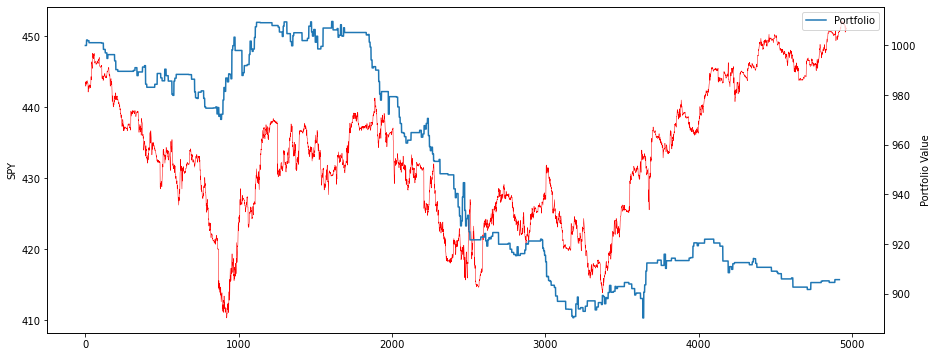

In [217]:
fig,axes = plt.subplots(1,1,figsize=[15,6])

file_loc = 'SPY_5min_2022-01-03T09.00.00_2022-03-25T14.10.00.csv'
df = pd.read_csv(os.path.join('data',file_loc),parse_dates=['datetime'])
df[6000:]['close'].reset_index(drop=True).plot(ax=axes,c='red',label='SPY movements',lw=0.5)

axes2 = axes.twinx()
axes2.plot(results,label='portfolio value')
# axes.set_xlabel('iteration')
# axes.set_ylabel('portfolio')
# axes[1].plot(probabilities,c='orange',lw=0.2)
# axes[1].set_xlabel('iteration')
# axes[1].set_ylabel('Probability of 0.5% growth in next 30min')
axes.set_ylabel('SPY')
axes2.set_ylabel('Portfolio Value')
plt.legend(['Portfolio','SPY'])
plt.show()

In [218]:
# More refined simulation
import tqdm
from collections import defaultdict
portfolio = 1000
countdown_timer = 0
no_intervals = len(img_test)
results = []
probabilities = list()

# Realistically this will be more like 0.00003
spread_cost = 0.00003

records = list()

for n in tqdm.tqdm(range(no_intervals)):
    
    interval_data = [np.expand_dims(img_test[n,:,:,:],axis=0),np.expand_dims(volume_test[n],axis=0)]
    prediction = model.predict(interval_data,verbose=0)
    probabilities.append(prediction.ravel()[0])
    if countdown_timer>0:
        countdown_timer = countdown_timer-1
        results.append(results[-1])
        continue
    
    results.append(portfolio)
    if (prediction>0.05)&(portfolio>0):
        # buy and hold for 30min
        print(f'Bought at iter {n}, result is:{growth_test[n][0]:0.3%}')
        portfolio = portfolio*(1+growth_test[n][0] - spread_cost) 
        countdown_timer = 5
        
        records.append({'prediction':prediction.ravel()[0],'results':growth_test[n][0]})

  0%|                                                                                 | 6/4920 [00:00<02:52, 28.42it/s]

Bought at iter 2, result is:0.271%


  0%|▏                                                                               | 12/4920 [00:00<02:54, 28.20it/s]

Bought at iter 8, result is:0.023%


  0%|▎                                                                               | 21/4920 [00:00<02:59, 27.22it/s]

Bought at iter 18, result is:-0.031%


  2%|█▋                                                                             | 105/4920 [00:03<03:05, 25.94it/s]

Bought at iter 100, result is:0.034%


  2%|█▉                                                                             | 117/4920 [00:04<03:00, 26.63it/s]

Bought at iter 112, result is:-0.204%


  3%|██                                                                             | 129/4920 [00:04<02:55, 27.30it/s]

Bought at iter 124, result is:-0.090%


  3%|██▎                                                                            | 141/4920 [00:05<03:03, 26.07it/s]

Bought at iter 135, result is:-0.174%


  3%|██▎                                                                            | 144/4920 [00:05<03:05, 25.79it/s]

Bought at iter 141, result is:0.204%


  4%|███                                                                            | 189/4920 [00:07<02:55, 26.98it/s]

Bought at iter 185, result is:-0.204%


  4%|███▏                                                                           | 198/4920 [00:07<02:55, 26.91it/s]

Bought at iter 193, result is:-0.306%


  4%|███▎                                                                           | 204/4920 [00:07<02:56, 26.73it/s]

Bought at iter 199, result is:0.053%


  4%|███▎                                                                           | 210/4920 [00:07<02:58, 26.39it/s]

Bought at iter 206, result is:-0.020%


  6%|█████                                                                          | 312/4920 [00:11<02:47, 27.52it/s]

Bought at iter 308, result is:0.087%


  7%|█████▏                                                                         | 324/4920 [00:12<02:51, 26.87it/s]

Bought at iter 318, result is:0.161%


  7%|█████▍                                                                         | 336/4920 [00:12<02:46, 27.52it/s]

Bought at iter 331, result is:-0.272%


  7%|█████▍                                                                         | 342/4920 [00:12<02:45, 27.66it/s]

Bought at iter 339, result is:0.198%


  8%|█████▉                                                                         | 372/4920 [00:13<02:47, 27.12it/s]

Bought at iter 367, result is:0.251%


  8%|██████▏                                                                        | 384/4920 [00:14<02:44, 27.63it/s]

Bought at iter 380, result is:0.107%


  8%|██████▎                                                                        | 393/4920 [00:14<02:47, 27.08it/s]

Bought at iter 387, result is:-0.703%


  8%|██████▍                                                                        | 399/4920 [00:14<02:51, 26.40it/s]

Bought at iter 395, result is:-0.077%


  9%|███████▏                                                                       | 450/4920 [00:17<03:28, 21.43it/s]

Bought at iter 447, result is:0.173%


 10%|███████▌                                                                       | 468/4920 [00:17<02:44, 27.05it/s]

Bought at iter 463, result is:0.491%


 10%|███████▉                                                                       | 492/4920 [00:18<02:37, 28.08it/s]

Bought at iter 486, result is:-0.129%


 10%|████████                                                                       | 501/4920 [00:18<02:36, 28.24it/s]

Bought at iter 495, result is:-0.069%


 10%|████████▎                                                                      | 516/4920 [00:19<02:35, 28.31it/s]

Bought at iter 512, result is:0.524%


 11%|████████▍                                                                      | 525/4920 [00:19<02:35, 28.21it/s]

Bought at iter 521, result is:-0.213%


 11%|████████▋                                                                      | 540/4920 [00:20<02:33, 28.49it/s]

Bought at iter 535, result is:-0.170%


 11%|█████████                                                                      | 564/4920 [00:21<02:40, 27.08it/s]

Bought at iter 559, result is:-0.494%


 12%|█████████▏                                                                     | 570/4920 [00:21<02:43, 26.66it/s]

Bought at iter 565, result is:0.010%


 12%|█████████▏                                                                     | 576/4920 [00:21<02:39, 27.17it/s]

Bought at iter 572, result is:0.637%


 12%|█████████▎                                                                     | 582/4920 [00:21<02:37, 27.61it/s]

Bought at iter 578, result is:0.168%


 12%|█████████▍                                                                     | 591/4920 [00:22<02:37, 27.48it/s]

Bought at iter 587, result is:0.205%


 14%|██████████▊                                                                    | 672/4920 [00:25<02:35, 27.27it/s]

Bought at iter 669, result is:0.039%


 14%|███████████▏                                                                   | 693/4920 [00:25<02:34, 27.34it/s]

Bought at iter 687, result is:-0.136%


 14%|███████████▍                                                                   | 711/4920 [00:26<02:33, 27.48it/s]

Bought at iter 707, result is:-0.469%


 15%|███████████▌                                                                   | 717/4920 [00:26<02:32, 27.62it/s]

Bought at iter 713, result is:-0.191%


 15%|███████████▋                                                                   | 729/4920 [00:27<02:30, 27.79it/s]

Bought at iter 723, result is:0.024%


 15%|███████████▊                                                                   | 735/4920 [00:27<02:33, 27.29it/s]

Bought at iter 731, result is:0.307%


 15%|████████████▏                                                                  | 756/4920 [00:28<02:33, 27.05it/s]

Bought at iter 750, result is:0.104%


 16%|████████████▍                                                                  | 771/4920 [00:28<02:34, 26.81it/s]

Bought at iter 766, result is:-0.259%


 16%|████████████▍                                                                  | 777/4920 [00:28<02:31, 27.38it/s]

Bought at iter 773, result is:-0.303%


 16%|████████████▌                                                                  | 786/4920 [00:29<02:30, 27.39it/s]

Bought at iter 780, result is:0.000%


 17%|█████████████▍                                                                 | 834/4920 [00:31<02:33, 26.64it/s]

Bought at iter 829, result is:0.061%


 17%|█████████████▋                                                                 | 849/4920 [00:31<02:25, 27.89it/s]

Bought at iter 845, result is:0.090%


 17%|█████████████▊                                                                 | 858/4920 [00:31<02:26, 27.67it/s]

Bought at iter 853, result is:-0.240%
Bought at iter 859, result is:0.315%


 18%|█████████████▉                                                                 | 870/4920 [00:32<02:29, 27.03it/s]

Bought at iter 865, result is:-0.313%


 18%|██████████████                                                                 | 876/4920 [00:32<02:29, 27.01it/s]

Bought at iter 871, result is:0.129%


 18%|██████████████▏                                                                | 882/4920 [00:32<02:30, 26.83it/s]

Bought at iter 877, result is:-0.155%


 18%|██████████████▎                                                                | 888/4920 [00:32<02:27, 27.42it/s]

Bought at iter 883, result is:0.266%


 18%|██████████████▍                                                                | 897/4920 [00:33<02:29, 26.93it/s]

Bought at iter 892, result is:0.639%


 18%|██████████████▍                                                                | 903/4920 [00:33<02:34, 25.92it/s]

Bought at iter 898, result is:0.563%


 18%|██████████████▌                                                                | 909/4920 [00:33<02:37, 25.47it/s]

Bought at iter 904, result is:-0.107%


 19%|██████████████▋                                                                | 915/4920 [00:34<02:32, 26.25it/s]

Bought at iter 910, result is:0.596%


 19%|██████████████▉                                                                | 927/4920 [00:34<02:33, 25.98it/s]

Bought at iter 921, result is:-0.104%


 19%|██████████████▉                                                                | 933/4920 [00:34<02:30, 26.49it/s]

Bought at iter 929, result is:0.376%


 19%|███████████████▏                                                               | 942/4920 [00:35<02:30, 26.40it/s]

Bought at iter 936, result is:0.025%


 19%|███████████████▏                                                               | 948/4920 [00:35<02:29, 26.64it/s]

Bought at iter 944, result is:-0.126%


 19%|███████████████▎                                                               | 954/4920 [00:35<02:31, 26.24it/s]

Bought at iter 950, result is:1.236%


 20%|███████████████▍                                                               | 960/4920 [00:35<02:29, 26.50it/s]

Bought at iter 956, result is:0.216%


 20%|███████████████▌                                                               | 969/4920 [00:36<02:26, 26.89it/s]

Bought at iter 964, result is:0.392%


 20%|███████████████▋                                                               | 975/4920 [00:36<02:31, 26.04it/s]

Bought at iter 971, result is:-0.484%


 21%|████████████████▏                                                             | 1020/4920 [00:38<02:30, 25.93it/s]

Bought at iter 1016, result is:-0.960%


 21%|████████████████▎                                                             | 1029/4920 [00:38<02:30, 25.78it/s]

Bought at iter 1024, result is:0.163%


 21%|████████████████▍                                                             | 1035/4920 [00:38<02:28, 26.18it/s]

Bought at iter 1031, result is:0.339%


 21%|████████████████▋                                                             | 1056/4920 [00:39<02:26, 26.37it/s]

Bought at iter 1050, result is:0.092%


 22%|████████████████▉                                                             | 1068/4920 [00:39<02:26, 26.26it/s]

Bought at iter 1063, result is:0.458%


 22%|█████████████████                                                             | 1074/4920 [00:40<02:23, 26.85it/s]

Bought at iter 1069, result is:0.592%


 22%|█████████████████▏                                                            | 1083/4920 [00:40<02:22, 26.88it/s]

Bought at iter 1077, result is:-0.267%


 22%|█████████████████▎                                                            | 1089/4920 [00:40<02:18, 27.62it/s]

Bought at iter 1083, result is:-0.046%
Bought at iter 1089, result is:0.144%


 22%|█████████████████▍                                                            | 1101/4920 [00:41<02:20, 27.24it/s]

Bought at iter 1097, result is:0.514%


 22%|█████████████████▌                                                            | 1107/4920 [00:41<02:16, 27.86it/s]

Bought at iter 1103, result is:0.483%


 23%|█████████████████▋                                                            | 1116/4920 [00:41<02:16, 27.94it/s]

Bought at iter 1111, result is:0.227%


 23%|██████████████████                                                            | 1140/4920 [00:42<02:14, 28.07it/s]

Bought at iter 1135, result is:0.035%


 25%|███████████████████▎                                                          | 1215/4920 [00:45<02:18, 26.69it/s]

Bought at iter 1212, result is:-0.062%


 26%|███████████████████▉                                                          | 1257/4920 [00:46<02:17, 26.64it/s]

Bought at iter 1252, result is:-0.014%


 26%|████████████████████                                                          | 1266/4920 [00:47<02:13, 27.47it/s]

Bought at iter 1260, result is:-0.146%


 26%|████████████████████▎                                                         | 1284/4920 [00:47<02:16, 26.54it/s]

Bought at iter 1279, result is:-0.129%


 26%|████████████████████▍                                                         | 1290/4920 [00:48<02:14, 26.97it/s]

Bought at iter 1285, result is:0.459%


 26%|████████████████████▌                                                         | 1296/4920 [00:48<02:15, 26.67it/s]

Bought at iter 1291, result is:0.225%


 27%|████████████████████▊                                                         | 1314/4920 [00:48<02:15, 26.65it/s]

Bought at iter 1309, result is:-0.418%


 27%|█████████████████████▏                                                        | 1338/4920 [00:49<02:15, 26.43it/s]

Bought at iter 1332, result is:-0.268%


 27%|█████████████████████▎                                                        | 1344/4920 [00:50<02:11, 27.29it/s]

Bought at iter 1340, result is:-0.120%


 28%|█████████████████████▍                                                        | 1353/4920 [00:50<02:08, 27.77it/s]

Bought at iter 1348, result is:0.462%
Bought at iter 1354, result is:0.163%


 29%|██████████████████████▍                                                       | 1413/4920 [00:52<02:10, 26.84it/s]

Bought at iter 1408, result is:-0.264%


 29%|██████████████████████▉                                                       | 1449/4920 [00:54<02:03, 28.04it/s]

Bought at iter 1443, result is:0.141%


 30%|███████████████████████                                                       | 1458/4920 [00:54<02:03, 28.06it/s]

Bought at iter 1452, result is:0.540%


 30%|███████████████████████▎                                                      | 1470/4920 [00:54<02:01, 28.31it/s]

Bought at iter 1464, result is:0.221%


 30%|███████████████████████▍                                                      | 1476/4920 [00:54<02:08, 26.76it/s]

Bought at iter 1470, result is:-0.349%


 30%|███████████████████████▍                                                      | 1482/4920 [00:55<02:04, 27.72it/s]

Bought at iter 1476, result is:-0.121%


 30%|███████████████████████▋                                                      | 1491/4920 [00:55<02:02, 28.10it/s]

Bought at iter 1484, result is:0.315%


 30%|███████████████████████▊                                                      | 1500/4920 [00:55<02:02, 27.99it/s]

Bought at iter 1494, result is:-0.457%


 31%|███████████████████████▉                                                      | 1506/4920 [00:56<02:01, 28.04it/s]

Bought at iter 1502, result is:0.292%


 31%|████████████████████████                                                      | 1515/4920 [00:56<02:01, 28.02it/s]

Bought at iter 1510, result is:-0.461%


 31%|████████████████████████▎                                                     | 1536/4920 [00:57<01:58, 28.59it/s]

Bought at iter 1531, result is:0.154%


 32%|████████████████████████▌                                                     | 1551/4920 [00:57<01:59, 28.31it/s]

Bought at iter 1545, result is:0.788%


 33%|█████████████████████████▍                                                    | 1605/4920 [00:59<01:56, 28.35it/s]

Bought at iter 1601, result is:0.313%


 33%|█████████████████████████▋                                                    | 1617/4920 [00:59<01:56, 28.27it/s]

Bought at iter 1610, result is:-0.286%


 33%|██████████████████████████                                                    | 1641/4920 [01:00<01:56, 28.15it/s]

Bought at iter 1637, result is:0.104%


 33%|██████████████████████████                                                    | 1647/4920 [01:01<01:56, 28.16it/s]

Bought at iter 1643, result is:-0.299%


 34%|██████████████████████████▏                                                   | 1653/4920 [01:01<01:54, 28.43it/s]

Bought at iter 1649, result is:0.130%


 34%|██████████████████████████▍                                                   | 1665/4920 [01:01<01:56, 28.05it/s]

Bought at iter 1659, result is:0.472%
Bought at iter 1665, result is:-0.393%


 34%|██████████████████████████▌                                                   | 1677/4920 [01:02<01:57, 27.61it/s]

Bought at iter 1672, result is:0.036%


 34%|██████████████████████████▋                                                   | 1683/4920 [01:02<01:56, 27.77it/s]

Bought at iter 1679, result is:0.387%


 34%|██████████████████████████▊                                                   | 1689/4920 [01:02<02:00, 26.90it/s]

Bought at iter 1685, result is:-0.139%


 37%|█████████████████████████████                                                 | 1830/4920 [01:07<01:57, 26.40it/s]

Bought at iter 1827, result is:-0.048%


 37%|█████████████████████████████▏                                                | 1842/4920 [01:08<01:56, 26.33it/s]

Bought at iter 1838, result is:0.068%


 38%|█████████████████████████████▎                                                | 1851/4920 [01:08<01:55, 26.54it/s]

Bought at iter 1846, result is:-0.256%


 38%|█████████████████████████████▍                                                | 1857/4920 [01:08<01:55, 26.53it/s]

Bought at iter 1852, result is:-0.150%
Bought at iter 1858, result is:-0.467%


 38%|█████████████████████████████▋                                                | 1869/4920 [01:09<01:53, 26.86it/s]

Bought at iter 1865, result is:-0.273%


 38%|█████████████████████████████▊                                                | 1878/4920 [01:09<01:51, 27.17it/s]

Bought at iter 1874, result is:0.100%


 38%|██████████████████████████████                                                | 1893/4920 [01:10<01:49, 27.66it/s]

Bought at iter 1888, result is:-0.091%


 39%|██████████████████████████████▎                                               | 1914/4920 [01:10<01:49, 27.57it/s]

Bought at iter 1908, result is:-0.415%


 39%|██████████████████████████████▍                                               | 1920/4920 [01:11<01:48, 27.71it/s]

Bought at iter 1914, result is:-0.460%


 39%|██████████████████████████████▌                                               | 1926/4920 [01:11<01:47, 27.88it/s]

Bought at iter 1920, result is:-0.201%
Bought at iter 1926, result is:0.402%


 40%|███████████████████████████████▎                                              | 1977/4920 [01:13<01:48, 27.23it/s]

Bought at iter 1971, result is:-0.878%


 40%|███████████████████████████████▍                                              | 1980/4920 [01:13<01:49, 26.82it/s]

Bought at iter 1977, result is:0.776%


 41%|████████████████████████████████▏                                             | 2028/4920 [01:15<01:45, 27.54it/s]

Bought at iter 2024, result is:0.030%


 41%|████████████████████████████████▎                                             | 2037/4920 [01:15<01:44, 27.63it/s]

Bought at iter 2032, result is:-0.354%


 42%|████████████████████████████████▍                                             | 2046/4920 [01:15<01:45, 27.34it/s]

Bought at iter 2042, result is:-0.373%


 42%|████████████████████████████████▌                                             | 2052/4920 [01:15<01:44, 27.55it/s]

Bought at iter 2048, result is:-0.213%


 42%|████████████████████████████████▋                                             | 2061/4920 [01:16<01:45, 27.08it/s]

Bought at iter 2057, result is:-0.326%


 42%|████████████████████████████████▊                                             | 2073/4920 [01:16<01:49, 26.03it/s]

Bought at iter 2069, result is:0.026%


 42%|████████████████████████████████▉                                             | 2079/4920 [01:16<01:49, 26.01it/s]

Bought at iter 2076, result is:-0.098%


 42%|█████████████████████████████████▏                                            | 2091/4920 [01:17<01:49, 25.78it/s]

Bought at iter 2086, result is:-0.217%


 43%|█████████████████████████████████▎                                            | 2103/4920 [01:17<01:48, 26.06it/s]

Bought at iter 2097, result is:0.171%


 43%|█████████████████████████████████▋                                            | 2124/4920 [01:18<01:44, 26.71it/s]

Bought at iter 2119, result is:0.368%


 44%|██████████████████████████████████▌                                           | 2181/4920 [01:20<01:43, 26.58it/s]

Bought at iter 2175, result is:0.146%


 45%|██████████████████████████████████▋                                           | 2190/4920 [01:21<01:45, 25.78it/s]

Bought at iter 2186, result is:-0.237%


 45%|██████████████████████████████████▉                                           | 2202/4920 [01:21<01:42, 26.48it/s]

Bought at iter 2196, result is:0.186%


 45%|███████████████████████████████████                                           | 2208/4920 [01:21<01:39, 27.23it/s]

Bought at iter 2204, result is:0.397%


 45%|███████████████████████████████████▏                                          | 2217/4920 [01:22<01:39, 27.18it/s]

Bought at iter 2212, result is:-0.093%


 45%|███████████████████████████████████▏                                          | 2223/4920 [01:22<01:39, 27.18it/s]

Bought at iter 2218, result is:0.286%


 45%|███████████████████████████████████▍                                          | 2232/4920 [01:22<01:38, 27.42it/s]

Bought at iter 2226, result is:0.258%


 45%|███████████████████████████████████▍                                          | 2238/4920 [01:22<01:38, 27.14it/s]

Bought at iter 2232, result is:-0.661%


 46%|███████████████████████████████████▌                                          | 2244/4920 [01:23<01:36, 27.65it/s]

Bought at iter 2239, result is:-0.413%


 46%|███████████████████████████████████▋                                          | 2250/4920 [01:23<01:37, 27.26it/s]

Bought at iter 2245, result is:-0.120%


 46%|███████████████████████████████████▊                                          | 2256/4920 [01:23<01:39, 26.72it/s]

Bought at iter 2251, result is:0.195%


 46%|███████████████████████████████████▉                                          | 2265/4920 [01:23<01:40, 26.31it/s]

Bought at iter 2259, result is:-0.233%


 46%|████████████████████████████████████                                          | 2271/4920 [01:24<01:40, 26.45it/s]

Bought at iter 2266, result is:-0.243%


 46%|████████████████████████████████████                                          | 2277/4920 [01:24<01:40, 26.38it/s]

Bought at iter 2272, result is:0.029%


 47%|████████████████████████████████████▌                                         | 2307/4920 [01:25<01:39, 26.33it/s]

Bought at iter 2302, result is:0.132%


 47%|████████████████████████████████████▋                                         | 2313/4920 [01:25<01:36, 27.00it/s]

Bought at iter 2308, result is:-0.554%


 48%|█████████████████████████████████████▍                                        | 2364/4920 [01:27<01:35, 26.88it/s]

Bought at iter 2360, result is:0.003%


 49%|██████████████████████████████████████                                        | 2403/4920 [01:29<01:30, 27.81it/s]

Bought at iter 2398, result is:-0.545%


 49%|██████████████████████████████████████▏                                       | 2412/4920 [01:29<01:30, 27.86it/s]

Bought at iter 2408, result is:-0.328%


 49%|██████████████████████████████████████▎                                       | 2418/4920 [01:29<01:28, 28.14it/s]

Bought at iter 2414, result is:0.227%


 49%|██████████████████████████████████████▌                                       | 2430/4920 [01:30<01:29, 27.68it/s]

Bought at iter 2426, result is:-0.526%


 50%|██████████████████████████████████████▋                                       | 2439/4920 [01:30<01:28, 27.92it/s]

Bought at iter 2435, result is:-0.336%


 50%|██████████████████████████████████████▊                                       | 2448/4920 [01:30<01:28, 28.08it/s]

Bought at iter 2442, result is:-0.379%


 50%|██████████████████████████████████████▉                                       | 2454/4920 [01:31<01:27, 28.10it/s]

Bought at iter 2448, result is:0.267%


 50%|███████████████████████████████████████                                       | 2460/4920 [01:31<01:29, 27.50it/s]

Bought at iter 2454, result is:1.082%


 50%|███████████████████████████████████████                                       | 2466/4920 [01:31<01:28, 27.74it/s]

Bought at iter 2460, result is:0.667%


 50%|███████████████████████████████████████▏                                      | 2475/4920 [01:31<01:27, 27.96it/s]

Bought at iter 2469, result is:-1.134%
Bought at iter 2475, result is:-0.619%


 51%|███████████████████████████████████████▍                                      | 2487/4920 [01:32<01:26, 28.05it/s]

Bought at iter 2481, result is:0.370%


 51%|███████████████████████████████████████▌                                      | 2493/4920 [01:32<01:26, 27.98it/s]

Bought at iter 2488, result is:0.191%


 51%|███████████████████████████████████████▋                                      | 2502/4920 [01:32<01:26, 28.04it/s]

Bought at iter 2497, result is:-0.661%


 51%|███████████████████████████████████████▊                                      | 2508/4920 [01:33<01:25, 28.30it/s]

Bought at iter 2503, result is:-0.303%


 52%|████████████████████████████████████████▊                                     | 2571/4920 [01:35<01:26, 27.00it/s]

Bought at iter 2566, result is:0.054%


 52%|████████████████████████████████████████▉                                     | 2580/4920 [01:35<01:24, 27.59it/s]

Bought at iter 2574, result is:0.173%


 53%|█████████████████████████████████████████▎                                    | 2604/4920 [01:36<01:29, 25.86it/s]

Bought at iter 2600, result is:0.203%


 53%|█████████████████████████████████████████▍                                    | 2610/4920 [01:36<01:28, 25.96it/s]

Bought at iter 2606, result is:-0.273%


 53%|█████████████████████████████████████████▌                                    | 2619/4920 [01:37<01:25, 26.86it/s]

Bought at iter 2613, result is:-0.178%


 53%|█████████████████████████████████████████▌                                    | 2625/4920 [01:37<01:24, 27.14it/s]

Bought at iter 2620, result is:0.331%


 53%|█████████████████████████████████████████▋                                    | 2631/4920 [01:37<01:25, 26.82it/s]

Bought at iter 2627, result is:0.139%


 54%|█████████████████████████████████████████▊                                    | 2640/4920 [01:37<01:26, 26.22it/s]

Bought at iter 2634, result is:0.001%


 54%|█████████████████████████████████████████▉                                    | 2646/4920 [01:38<01:26, 26.43it/s]

Bought at iter 2642, result is:0.157%


 54%|██████████████████████████████████████████▏                                   | 2658/4920 [01:38<01:26, 26.20it/s]

Bought at iter 2652, result is:0.217%


 55%|██████████████████████████████████████████▋                                   | 2694/4920 [01:39<01:23, 26.71it/s]

Bought at iter 2690, result is:-0.457%


 56%|███████████████████████████████████████████▊                                  | 2760/4920 [01:42<01:17, 27.70it/s]

Bought at iter 2754, result is:0.090%


 56%|███████████████████████████████████████████▉                                  | 2769/4920 [01:42<01:17, 27.86it/s]

Bought at iter 2765, result is:-0.210%


 57%|████████████████████████████████████████████                                  | 2781/4920 [01:43<01:18, 27.42it/s]

Bought at iter 2776, result is:-0.092%


 57%|████████████████████████████████████████████▎                                 | 2793/4920 [01:43<01:17, 27.57it/s]

Bought at iter 2789, result is:-0.040%


 57%|████████████████████████████████████████████▍                                 | 2805/4920 [01:44<01:16, 27.74it/s]

Bought at iter 2801, result is:-0.002%


 57%|████████████████████████████████████████████▋                                 | 2817/4920 [01:44<01:16, 27.42it/s]

Bought at iter 2811, result is:0.441%


 57%|████████████████████████████████████████████▊                                 | 2823/4920 [01:44<01:16, 27.35it/s]

Bought at iter 2818, result is:-0.327%


 58%|████████████████████████████████████████████▉                                 | 2838/4920 [01:45<01:14, 27.89it/s]

Bought at iter 2832, result is:0.128%


 58%|█████████████████████████████████████████████▍                                | 2865/4920 [01:46<01:15, 27.10it/s]

Bought at iter 2861, result is:0.211%


 58%|█████████████████████████████████████████████▌                                | 2874/4920 [01:46<01:14, 27.51it/s]

Bought at iter 2868, result is:0.325%


 59%|█████████████████████████████████████████████▋                                | 2880/4920 [01:46<01:14, 27.56it/s]

Bought at iter 2876, result is:0.033%


 59%|█████████████████████████████████████████████▊                                | 2889/4920 [01:47<01:13, 27.72it/s]

Bought at iter 2885, result is:0.184%


 60%|███████████████████████████████████████████████                               | 2970/4920 [01:50<01:15, 25.97it/s]

Bought at iter 2964, result is:0.131%


 60%|███████████████████████████████████████████████▏                              | 2976/4920 [01:50<01:13, 26.45it/s]

Bought at iter 2972, result is:0.012%


 61%|███████████████████████████████████████████████▎                              | 2982/4920 [01:50<01:12, 26.70it/s]

Bought at iter 2978, result is:-0.309%


 61%|███████████████████████████████████████████████▎                              | 2988/4920 [01:50<01:13, 26.44it/s]

Bought at iter 2984, result is:-0.063%


 61%|███████████████████████████████████████████████▍                              | 2994/4920 [01:51<01:13, 26.18it/s]

Bought at iter 2990, result is:-0.149%


 61%|███████████████████████████████████████████████▌                              | 3003/4920 [01:51<01:11, 26.66it/s]

Bought at iter 2997, result is:-0.233%


 61%|███████████████████████████████████████████████▋                              | 3009/4920 [01:51<01:10, 27.16it/s]

Bought at iter 3003, result is:-0.606%


 61%|███████████████████████████████████████████████▊                              | 3015/4920 [01:51<01:10, 27.08it/s]

Bought at iter 3010, result is:0.061%


 61%|███████████████████████████████████████████████▉                              | 3021/4920 [01:51<01:09, 27.16it/s]

Bought at iter 3016, result is:-0.134%


 62%|████████████████████████████████████████████████                              | 3033/4920 [01:52<01:08, 27.73it/s]

Bought at iter 3026, result is:0.014%


 62%|████████████████████████████████████████████████▏                             | 3039/4920 [01:52<01:08, 27.62it/s]

Bought at iter 3033, result is:-0.125%


 62%|████████████████████████████████████████████████▌                             | 3060/4920 [01:53<01:06, 27.93it/s]

Bought at iter 3054, result is:-0.049%


 62%|████████████████████████████████████████████████▌                             | 3066/4920 [01:53<01:07, 27.62it/s]

Bought at iter 3062, result is:-0.331%


 63%|████████████████████████████████████████████████▊                             | 3078/4920 [01:54<01:06, 27.90it/s]

Bought at iter 3074, result is:-0.189%


 64%|█████████████████████████████████████████████████▋                            | 3132/4920 [01:56<01:05, 27.16it/s]

Bought at iter 3128, result is:-0.300%


 64%|█████████████████████████████████████████████████▉                            | 3153/4920 [01:56<01:07, 26.28it/s]

Bought at iter 3147, result is:0.043%


 65%|██████████████████████████████████████████████████▎                           | 3174/4920 [01:57<01:04, 26.96it/s]

Bought at iter 3168, result is:-0.268%


 65%|██████████████████████████████████████████████████▍                           | 3180/4920 [01:57<01:05, 26.61it/s]

Bought at iter 3175, result is:-0.012%


 65%|██████████████████████████████████████████████████▌                           | 3186/4920 [01:58<01:06, 25.93it/s]

Bought at iter 3181, result is:0.105%


 65%|██████████████████████████████████████████████████▋                           | 3198/4920 [01:58<01:06, 25.76it/s]

Bought at iter 3194, result is:0.619%


 65%|██████████████████████████████████████████████████▉                           | 3210/4920 [01:59<01:05, 26.25it/s]

Bought at iter 3204, result is:0.360%


 65%|██████████████████████████████████████████████████▉                           | 3213/4920 [01:59<01:04, 26.32it/s]

Bought at iter 3210, result is:-0.483%


 66%|███████████████████████████████████████████████████▏                          | 3231/4920 [01:59<01:04, 26.18it/s]

Bought at iter 3225, result is:0.108%


 66%|███████████████████████████████████████████████████▍                          | 3246/4920 [02:00<01:04, 25.94it/s]

Bought at iter 3241, result is:-0.117%


 66%|███████████████████████████████████████████████████▋                          | 3258/4920 [02:01<01:33, 17.80it/s]

Bought at iter 3256, result is:0.281%


 67%|███████████████████████████████████████████████████▉                          | 3273/4920 [02:01<01:05, 24.96it/s]

Bought at iter 3269, result is:0.290%


 68%|████████████████████████████████████████████████████▋                         | 3324/4920 [02:03<00:58, 27.36it/s]

Bought at iter 3320, result is:-0.356%


 68%|████████████████████████████████████████████████████▉                         | 3336/4920 [02:03<00:58, 27.28it/s]

Bought at iter 3330, result is:0.181%


 68%|█████████████████████████████████████████████████████                         | 3345/4920 [02:04<00:58, 27.01it/s]

Bought at iter 3341, result is:0.248%


 68%|█████████████████████████████████████████████████████▎                        | 3366/4920 [02:04<00:57, 27.12it/s]

Bought at iter 3361, result is:-0.036%


 69%|█████████████████████████████████████████████████████▍                        | 3372/4920 [02:05<00:56, 27.63it/s]

Bought at iter 3367, result is:0.457%
Bought at iter 3373, result is:0.000%


 69%|█████████████████████████████████████████████████████▋                        | 3387/4920 [02:05<00:57, 26.68it/s]

Bought at iter 3381, result is:-0.271%


 69%|█████████████████████████████████████████████████████▊                        | 3396/4920 [02:06<00:57, 26.63it/s]

Bought at iter 3390, result is:0.326%


 69%|█████████████████████████████████████████████████████▉                        | 3402/4920 [02:06<00:55, 27.42it/s]

Bought at iter 3396, result is:0.007%


 69%|██████████████████████████████████████████████████████                        | 3411/4920 [02:06<00:54, 27.52it/s]

Bought at iter 3405, result is:0.321%


 70%|██████████████████████████████████████████████████████▏                       | 3420/4920 [02:06<00:54, 27.68it/s]

Bought at iter 3414, result is:0.367%


 70%|██████████████████████████████████████████████████████▎                       | 3429/4920 [02:07<00:53, 27.93it/s]

Bought at iter 3423, result is:-0.255%


 70%|██████████████████████████████████████████████████████▌                       | 3444/4920 [02:07<00:53, 27.65it/s]

Bought at iter 3439, result is:0.090%


 70%|██████████████████████████████████████████████████████▊                       | 3456/4920 [02:08<00:53, 27.51it/s]

Bought at iter 3450, result is:0.271%


 70%|██████████████████████████████████████████████████████▉                       | 3462/4920 [02:08<00:52, 27.81it/s]

Bought at iter 3457, result is:-0.042%


 71%|███████████████████████████████████████████████████████                       | 3471/4920 [02:08<00:52, 27.62it/s]

Bought at iter 3466, result is:0.136%


 71%|███████████████████████████████████████████████████████▋                      | 3516/4920 [02:10<00:52, 26.61it/s]

Bought at iter 3511, result is:0.231%


 72%|████████████████████████████████████████████████████████▏                     | 3546/4920 [02:11<00:49, 27.55it/s]

Bought at iter 3540, result is:-0.016%


 72%|████████████████████████████████████████████████████████▌                     | 3564/4920 [02:12<00:49, 27.16it/s]

Bought at iter 3559, result is:-0.155%


 73%|████████████████████████████████████████████████████████▊                     | 3582/4920 [02:12<00:48, 27.43it/s]

Bought at iter 3578, result is:-0.236%


 73%|████████████████████████████████████████████████████████▉                     | 3588/4920 [02:13<00:49, 27.00it/s]

Bought at iter 3585, result is:0.123%


 73%|█████████████████████████████████████████████████████████                     | 3597/4920 [02:13<00:48, 27.03it/s]

Bought at iter 3591, result is:0.065%


 74%|█████████████████████████████████████████████████████████▍                    | 3621/4920 [02:14<00:46, 27.69it/s]

Bought at iter 3616, result is:-0.195%


 74%|█████████████████████████████████████████████████████████▋                    | 3636/4920 [02:14<00:45, 27.92it/s]

Bought at iter 3631, result is:-0.824%


 74%|█████████████████████████████████████████████████████████▋                    | 3642/4920 [02:15<00:47, 26.76it/s]

Bought at iter 3637, result is:1.216%


 74%|█████████████████████████████████████████████████████████▊                    | 3648/4920 [02:15<00:48, 26.46it/s]

Bought at iter 3643, result is:0.380%


 74%|█████████████████████████████████████████████████████████▉                    | 3657/4920 [02:15<00:46, 26.90it/s]

Bought at iter 3651, result is:0.667%


 74%|██████████████████████████████████████████████████████████                    | 3663/4920 [02:15<00:45, 27.49it/s]

Bought at iter 3657, result is:0.406%


 76%|███████████████████████████████████████████████████████████▏                  | 3732/4920 [02:18<00:43, 27.20it/s]

Bought at iter 3727, result is:0.175%


 76%|███████████████████████████████████████████████████████████▌                  | 3756/4920 [02:19<00:43, 26.97it/s]

Bought at iter 3751, result is:-0.182%


 77%|███████████████████████████████████████████████████████████▊                  | 3774/4920 [02:19<00:42, 26.70it/s]

Bought at iter 3770, result is:0.545%


 77%|███████████████████████████████████████████████████████████▉                  | 3783/4920 [02:20<00:42, 26.81it/s]

Bought at iter 3779, result is:-0.574%


 77%|████████████████████████████████████████████████████████████                  | 3789/4920 [02:20<00:41, 27.30it/s]

Bought at iter 3785, result is:0.387%


 77%|████████████████████████████████████████████████████████████▍                 | 3810/4920 [02:21<00:40, 27.59it/s]

Bought at iter 3803, result is:0.053%


 78%|████████████████████████████████████████████████████████████▌                 | 3822/4920 [02:21<00:39, 27.72it/s]

Bought at iter 3818, result is:0.162%


 78%|████████████████████████████████████████████████████████████▉                 | 3846/4920 [02:22<00:39, 27.26it/s]

Bought at iter 3843, result is:-0.054%


 80%|██████████████████████████████████████████████████████████████▍               | 3939/4920 [02:26<00:37, 25.83it/s]

Bought at iter 3933, result is:0.158%


 80%|██████████████████████████████████████████████████████████████▌               | 3948/4920 [02:26<00:36, 26.46it/s]

Bought at iter 3943, result is:0.073%


 81%|██████████████████████████████████████████████████████████████▊               | 3963/4920 [02:26<00:35, 27.09it/s]

Bought at iter 3958, result is:0.552%


 81%|██████████████████████████████████████████████████████████████▉               | 3969/4920 [02:27<00:35, 26.77it/s]

Bought at iter 3964, result is:0.196%


 81%|███████████████████████████████████████████████████████████████▎              | 3990/4920 [02:27<00:34, 27.13it/s]

Bought at iter 3986, result is:-0.076%


 81%|███████████████████████████████████████████████████████████████▍              | 3999/4920 [02:28<00:33, 27.15it/s]

Bought at iter 3994, result is:0.165%


 82%|████████████████████████████████████████████████████████████████              | 4038/4920 [02:29<00:32, 26.81it/s]

Bought at iter 4034, result is:0.220%


 83%|████████████████████████████████████████████████████████████████▊             | 4092/4920 [02:31<00:30, 27.52it/s]

Bought at iter 4087, result is:0.054%


 83%|████████████████████████████████████████████████████████████████▉             | 4098/4920 [02:31<00:29, 27.63it/s]

Bought at iter 4094, result is:-0.119%


 84%|█████████████████████████████████████████████████████████████████▋            | 4140/4920 [02:33<00:28, 27.41it/s]

Bought at iter 4134, result is:-0.088%


 85%|█████████████████████████████████████████████████████████████████▉            | 4158/4920 [02:34<00:27, 27.25it/s]

Bought at iter 4153, result is:-0.602%


 85%|██████████████████████████████████████████████████████████████████▍           | 4194/4920 [02:35<00:25, 27.99it/s]

Bought at iter 4188, result is:-0.464%


 85%|██████████████████████████████████████████████████████████████████▋           | 4203/4920 [02:35<00:31, 22.83it/s]

Bought at iter 4197, result is:0.318%


 86%|██████████████████████████████████████████████████████████████████▊           | 4215/4920 [02:36<00:26, 26.52it/s]

Bought at iter 4210, result is:-0.070%


 86%|██████████████████████████████████████████████████████████████████▉           | 4221/4920 [02:36<00:26, 26.59it/s]

Bought at iter 4218, result is:0.300%


 86%|███████████████████████████████████████████████████████████████████           | 4233/4920 [02:37<00:26, 26.06it/s]

Bought at iter 4229, result is:0.099%


 88%|████████████████████████████████████████████████████████████████████▋         | 4332/4920 [02:40<00:20, 28.19it/s]

Bought at iter 4326, result is:-0.045%


 88%|████████████████████████████████████████████████████████████████████▉         | 4350/4920 [02:41<00:20, 27.39it/s]

Bought at iter 4345, result is:0.173%


 89%|█████████████████████████████████████████████████████████████████████         | 4356/4920 [02:41<00:20, 27.62it/s]

Bought at iter 4352, result is:0.205%


 89%|█████████████████████████████████████████████████████████████████████▏        | 4362/4920 [02:41<00:20, 27.11it/s]

Bought at iter 4358, result is:0.038%


 89%|█████████████████████████████████████████████████████████████████████▎        | 4371/4920 [02:42<00:20, 26.58it/s]

Bought at iter 4367, result is:-0.156%


 89%|█████████████████████████████████████████████████████████████████████▍        | 4380/4920 [02:42<00:20, 26.79it/s]

Bought at iter 4375, result is:-0.123%


 91%|██████████████████████████████████████████████████████████████████████▉       | 4473/4920 [02:45<00:15, 28.27it/s]

Bought at iter 4470, result is:-0.122%


 92%|███████████████████████████████████████████████████████████████████████▌      | 4512/4920 [02:47<00:15, 27.13it/s]

Bought at iter 4507, result is:-0.007%


 92%|███████████████████████████████████████████████████████████████████████▋      | 4518/4920 [02:47<00:14, 27.03it/s]

Bought at iter 4513, result is:-0.002%


 92%|███████████████████████████████████████████████████████████████████████▉      | 4539/4920 [02:48<00:14, 27.11it/s]

Bought at iter 4535, result is:-0.183%


 94%|█████████████████████████████████████████████████████████████████████████     | 4605/4920 [02:50<00:11, 26.75it/s]

Bought at iter 4601, result is:0.094%


 94%|█████████████████████████████████████████████████████████████████████████▏    | 4614/4920 [02:50<00:11, 27.17it/s]

Bought at iter 4610, result is:-0.358%


 95%|██████████████████████████████████████████████████████████████████████████    | 4674/4920 [02:53<00:08, 27.94it/s]

Bought at iter 4668, result is:0.049%


 96%|██████████████████████████████████████████████████████████████████████████▋   | 4710/4920 [02:54<00:07, 28.01it/s]

Bought at iter 4704, result is:-0.056%


 96%|██████████████████████████████████████████████████████████████████████████▊   | 4719/4920 [02:54<00:07, 27.12it/s]

Bought at iter 4715, result is:0.054%


 96%|███████████████████████████████████████████████████████████████████████████   | 4731/4920 [02:55<00:07, 26.35it/s]

Bought at iter 4727, result is:0.356%


 98%|████████████████████████████████████████████████████████████████████████████  | 4800/4920 [02:57<00:04, 26.97it/s]

Bought at iter 4795, result is:0.112%


 98%|████████████████████████████████████████████████████████████████████████████▏ | 4809/4920 [02:58<00:04, 27.28it/s]

Bought at iter 4803, result is:0.064%


 99%|████████████████████████████████████████████████████████████████████████████▉ | 4851/4920 [02:59<00:02, 26.41it/s]

Bought at iter 4847, result is:-0.020%


 99%|█████████████████████████████████████████████████████████████████████████████▌| 4890/4920 [03:01<00:01, 27.26it/s]

Bought at iter 4884, result is:0.175%


100%|██████████████████████████████████████████████████████████████████████████████| 4920/4920 [03:02<00:00, 27.00it/s]

Bought at iter 4916, result is:0.134%


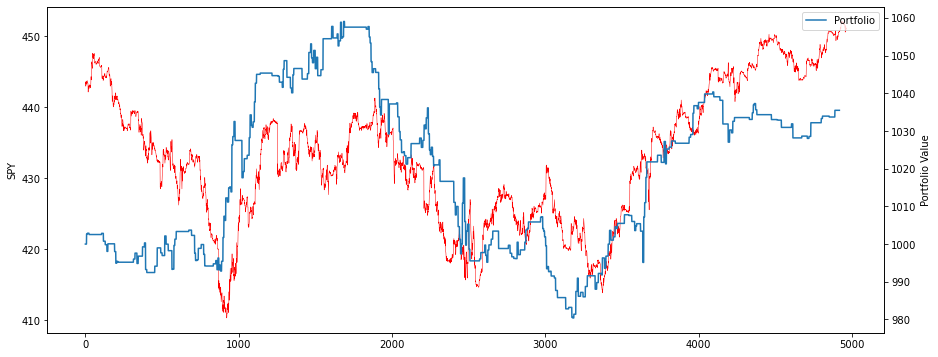

In [219]:
fig,axes = plt.subplots(1,1,figsize=[15,6])

file_loc = 'SPY_5min_2022-01-03T09.00.00_2022-03-25T14.10.00.csv'
df = pd.read_csv(os.path.join('data',file_loc),parse_dates=['datetime'])
df[6000:]['close'].reset_index(drop=True).plot(ax=axes,c='red',label='SPY movements',lw=0.5)

axes2 = axes.twinx()
axes2.plot(results,label='portfolio value')
# axes.set_xlabel('iteration')
# axes.set_ylabel('portfolio')
# axes[1].plot(probabilities,c='orange',lw=0.2)
# axes[1].set_xlabel('iteration')
# axes[1].set_ylabel('Probability of 0.5% growth in next 30min')
axes.set_ylabel('SPY')
axes2.set_ylabel('Portfolio Value')
plt.legend(['Portfolio','SPY'])
plt.show()

Market Made 1.7% gains, whereas the model got 3.5%.

In [229]:
df[6000:]['close'].iloc[-1]/df[6000:]['close'].iloc[0]

1.0174370079628252

In [230]:
results[-1]/results[0]

1.0266780843682863

In [223]:
# More refined simulation
import tqdm
from collections import defaultdict
portfolio = 1000
countdown_timer = 0
no_intervals = len(img_test)
results = []
probabilities = list()

# Realistically this will be more like 0.00003
spread_cost = 0.00006

records = list()

for n in tqdm.tqdm(range(no_intervals)):
    
    interval_data = [np.expand_dims(img_test[n,:,:,:],axis=0),np.expand_dims(volume_test[n],axis=0)]
    prediction = model.predict(interval_data,verbose=0)
    probabilities.append(prediction.ravel()[0])
    if countdown_timer>0:
        countdown_timer = countdown_timer-1
        results.append(results[-1])
        continue
    
    results.append(portfolio)
    if (prediction>0.05)&(portfolio>0):
        # buy and hold for 30min
        print(f'Bought at iter {n}, result is:{growth_test[n][0]:0.3%}')
        portfolio = portfolio*(1+growth_test[n][0] - spread_cost) 
        countdown_timer = 5
        
        records.append({'prediction':prediction.ravel()[0],'results':growth_test[n][0]})

  0%|                                                                                 | 6/4920 [00:00<03:03, 26.80it/s]

Bought at iter 2, result is:0.271%


  0%|▏                                                                               | 12/4920 [00:00<03:06, 26.28it/s]

Bought at iter 8, result is:0.023%


  0%|▍                                                                               | 24/4920 [00:00<02:56, 27.79it/s]

Bought at iter 18, result is:-0.031%


  2%|█▋                                                                             | 105/4920 [00:03<02:59, 26.84it/s]

Bought at iter 100, result is:0.034%


  2%|█▉                                                                             | 117/4920 [00:04<02:58, 26.84it/s]

Bought at iter 112, result is:-0.204%


  3%|██                                                                             | 129/4920 [00:04<02:56, 27.17it/s]

Bought at iter 124, result is:-0.090%


  3%|██▎                                                                            | 141/4920 [00:05<02:54, 27.42it/s]

Bought at iter 135, result is:-0.174%


  3%|██▎                                                                            | 144/4920 [00:05<02:55, 27.17it/s]

Bought at iter 141, result is:0.204%


  4%|███                                                                            | 189/4920 [00:07<02:50, 27.72it/s]

Bought at iter 185, result is:-0.204%


  4%|███▏                                                                           | 198/4920 [00:07<02:48, 27.96it/s]

Bought at iter 193, result is:-0.306%


  4%|███▎                                                                           | 204/4920 [00:07<02:46, 28.26it/s]

Bought at iter 199, result is:0.053%


  4%|███▎                                                                           | 210/4920 [00:07<02:47, 28.14it/s]

Bought at iter 206, result is:-0.020%


  6%|█████                                                                          | 312/4920 [00:11<02:50, 27.04it/s]

Bought at iter 308, result is:0.087%


  7%|█████▏                                                                         | 324/4920 [00:12<02:49, 27.16it/s]

Bought at iter 318, result is:0.161%


  7%|█████▍                                                                         | 336/4920 [00:12<02:46, 27.51it/s]

Bought at iter 331, result is:-0.272%


  7%|█████▌                                                                         | 345/4920 [00:12<02:48, 27.11it/s]

Bought at iter 339, result is:0.198%


  8%|█████▉                                                                         | 372/4920 [00:13<02:45, 27.42it/s]

Bought at iter 367, result is:0.251%


  8%|██████▏                                                                        | 384/4920 [00:14<02:43, 27.68it/s]

Bought at iter 380, result is:0.107%


  8%|██████▎                                                                        | 390/4920 [00:14<02:44, 27.55it/s]

Bought at iter 387, result is:-0.703%


  8%|██████▍                                                                        | 399/4920 [00:14<02:46, 27.17it/s]

Bought at iter 395, result is:-0.077%


  9%|███████▎                                                                       | 453/4920 [00:16<02:43, 27.27it/s]

Bought at iter 447, result is:0.173%


 10%|███████▌                                                                       | 468/4920 [00:17<02:40, 27.82it/s]

Bought at iter 463, result is:0.491%


 10%|███████▉                                                                       | 492/4920 [00:18<02:41, 27.40it/s]

Bought at iter 486, result is:-0.129%


 10%|████████                                                                       | 501/4920 [00:18<02:48, 26.22it/s]

Bought at iter 495, result is:-0.069%


 11%|████████▎                                                                      | 519/4920 [00:19<02:39, 27.63it/s]

Bought at iter 512, result is:0.524%


 11%|████████▍                                                                      | 525/4920 [00:19<02:37, 27.85it/s]

Bought at iter 521, result is:-0.213%


 11%|████████▋                                                                      | 540/4920 [00:20<02:42, 27.00it/s]

Bought at iter 535, result is:-0.170%


 11%|█████████                                                                      | 564/4920 [00:20<02:44, 26.56it/s]

Bought at iter 559, result is:-0.494%


 12%|█████████▏                                                                     | 570/4920 [00:21<02:44, 26.49it/s]

Bought at iter 565, result is:0.010%


 12%|█████████▏                                                                     | 576/4920 [00:21<02:41, 26.86it/s]

Bought at iter 572, result is:0.637%


 12%|█████████▎                                                                     | 582/4920 [00:21<02:43, 26.52it/s]

Bought at iter 578, result is:0.168%


 12%|█████████▍                                                                     | 591/4920 [00:21<02:41, 26.80it/s]

Bought at iter 587, result is:0.205%


 14%|██████████▊                                                                    | 672/4920 [00:24<02:35, 27.26it/s]

Bought at iter 669, result is:0.039%


 14%|███████████▏                                                                   | 693/4920 [00:25<02:34, 27.27it/s]

Bought at iter 687, result is:-0.136%


 14%|███████████▍                                                                   | 711/4920 [00:26<02:43, 25.68it/s]

Bought at iter 707, result is:-0.469%


 15%|███████████▌                                                                   | 717/4920 [00:26<02:43, 25.77it/s]

Bought at iter 713, result is:-0.191%


 15%|███████████▋                                                                   | 729/4920 [00:27<02:39, 26.27it/s]

Bought at iter 723, result is:0.024%


 15%|███████████▊                                                                   | 735/4920 [00:27<02:38, 26.43it/s]

Bought at iter 731, result is:0.307%


 15%|████████████                                                                   | 753/4920 [00:27<02:32, 27.28it/s]

Bought at iter 750, result is:0.104%


 16%|████████████▍                                                                  | 771/4920 [00:28<02:30, 27.61it/s]

Bought at iter 766, result is:-0.259%


 16%|████████████▍                                                                  | 777/4920 [00:28<02:28, 27.89it/s]

Bought at iter 773, result is:-0.303%


 16%|████████████▌                                                                  | 786/4920 [00:29<02:31, 27.32it/s]

Bought at iter 780, result is:0.000%


 17%|█████████████▍                                                                 | 834/4920 [00:30<02:27, 27.69it/s]

Bought at iter 829, result is:0.061%


 17%|█████████████▋                                                                 | 849/4920 [00:31<02:24, 28.20it/s]

Bought at iter 845, result is:0.090%


 17%|█████████████▊                                                                 | 858/4920 [00:31<02:24, 28.04it/s]

Bought at iter 853, result is:-0.240%


 18%|█████████████▊                                                                 | 864/4920 [00:31<02:25, 27.93it/s]

Bought at iter 859, result is:0.315%


 18%|█████████████▉                                                                 | 870/4920 [00:32<02:24, 27.93it/s]

Bought at iter 865, result is:-0.313%


 18%|██████████████                                                                 | 876/4920 [00:32<02:24, 27.90it/s]

Bought at iter 871, result is:0.129%
Bought at iter 877, result is:-0.155%


 18%|██████████████▎                                                                | 888/4920 [00:32<02:23, 28.18it/s]

Bought at iter 883, result is:0.266%


 18%|██████████████▍                                                                | 897/4920 [00:33<02:22, 28.17it/s]

Bought at iter 892, result is:0.639%
Bought at iter 898, result is:0.563%


 18%|██████████████▌                                                                | 909/4920 [00:33<02:25, 27.58it/s]

Bought at iter 904, result is:-0.107%


 19%|██████████████▋                                                                | 915/4920 [00:33<02:23, 28.00it/s]

Bought at iter 910, result is:0.596%


 19%|██████████████▉                                                                | 927/4920 [00:34<02:23, 27.75it/s]

Bought at iter 921, result is:-0.104%


 19%|██████████████▉                                                                | 933/4920 [00:34<02:22, 27.94it/s]

Bought at iter 929, result is:0.376%


 19%|███████████████▏                                                               | 942/4920 [00:34<02:21, 28.19it/s]

Bought at iter 936, result is:0.025%


 19%|███████████████▏                                                               | 948/4920 [00:34<02:21, 28.10it/s]

Bought at iter 944, result is:-0.126%


 19%|███████████████▎                                                               | 954/4920 [00:35<02:23, 27.55it/s]

Bought at iter 950, result is:1.236%


 20%|███████████████▍                                                               | 960/4920 [00:35<02:24, 27.39it/s]

Bought at iter 956, result is:0.216%


 20%|███████████████▌                                                               | 969/4920 [00:35<02:23, 27.45it/s]

Bought at iter 964, result is:0.392%


 20%|███████████████▋                                                               | 975/4920 [00:35<02:22, 27.75it/s]

Bought at iter 971, result is:-0.484%


 21%|████████████████▏                                                             | 1020/4920 [00:37<02:20, 27.67it/s]

Bought at iter 1016, result is:-0.960%


 21%|████████████████▎                                                             | 1029/4920 [00:37<02:20, 27.79it/s]

Bought at iter 1024, result is:0.163%


 21%|████████████████▍                                                             | 1035/4920 [00:38<02:18, 27.95it/s]

Bought at iter 1031, result is:0.339%


 21%|████████████████▋                                                             | 1056/4920 [00:38<02:19, 27.75it/s]

Bought at iter 1050, result is:0.092%


 22%|████████████████▉                                                             | 1068/4920 [00:39<02:18, 27.79it/s]

Bought at iter 1063, result is:0.458%


 22%|█████████████████                                                             | 1074/4920 [00:39<02:19, 27.61it/s]

Bought at iter 1069, result is:0.592%


 22%|█████████████████                                                             | 1080/4920 [00:39<02:17, 27.94it/s]

Bought at iter 1077, result is:-0.267%


 22%|█████████████████▎                                                            | 1089/4920 [00:40<02:47, 22.87it/s]

Bought at iter 1083, result is:-0.046%


 22%|█████████████████▎                                                            | 1095/4920 [00:40<02:30, 25.36it/s]

Bought at iter 1089, result is:0.144%


 22%|█████████████████▍                                                            | 1101/4920 [00:40<02:22, 26.77it/s]

Bought at iter 1097, result is:0.514%


 22%|█████████████████▌                                                            | 1107/4920 [00:40<02:18, 27.61it/s]

Bought at iter 1103, result is:0.483%


 23%|█████████████████▋                                                            | 1116/4920 [00:41<02:16, 27.85it/s]

Bought at iter 1111, result is:0.227%


 23%|██████████████████                                                            | 1140/4920 [00:42<02:13, 28.24it/s]

Bought at iter 1135, result is:0.035%


 25%|███████████████████▎                                                          | 1218/4920 [00:44<02:12, 27.95it/s]

Bought at iter 1212, result is:-0.062%


 26%|███████████████████▉                                                          | 1257/4920 [00:46<02:10, 28.12it/s]

Bought at iter 1252, result is:-0.014%


 26%|████████████████████                                                          | 1266/4920 [00:46<02:09, 28.13it/s]

Bought at iter 1260, result is:-0.146%


 26%|████████████████████▎                                                         | 1284/4920 [00:47<02:10, 27.85it/s]

Bought at iter 1279, result is:-0.129%
Bought at iter 1285, result is:0.459%


 26%|████████████████████▌                                                         | 1296/4920 [00:47<02:09, 28.08it/s]

Bought at iter 1291, result is:0.225%


 27%|████████████████████▊                                                         | 1314/4920 [00:48<02:08, 28.13it/s]

Bought at iter 1309, result is:-0.418%


 27%|█████████████████████▏                                                        | 1338/4920 [00:49<02:07, 28.06it/s]

Bought at iter 1332, result is:-0.268%


 27%|█████████████████████▎                                                        | 1344/4920 [00:49<02:08, 27.93it/s]

Bought at iter 1340, result is:-0.120%


 28%|█████████████████████▍                                                        | 1353/4920 [00:49<02:07, 28.01it/s]

Bought at iter 1348, result is:0.462%


 28%|█████████████████████▌                                                        | 1359/4920 [00:49<02:07, 27.95it/s]

Bought at iter 1354, result is:0.163%


 29%|██████████████████████▍                                                       | 1413/4920 [00:51<02:05, 27.99it/s]

Bought at iter 1408, result is:-0.264%


 29%|██████████████████████▉                                                       | 1449/4920 [00:53<02:03, 28.12it/s]

Bought at iter 1443, result is:0.141%


 30%|███████████████████████                                                       | 1458/4920 [00:53<02:03, 27.99it/s]

Bought at iter 1452, result is:0.540%


 30%|███████████████████████▎                                                      | 1470/4920 [00:53<02:03, 27.92it/s]

Bought at iter 1464, result is:0.221%
Bought at iter 1470, result is:-0.349%


 30%|███████████████████████▍                                                      | 1482/4920 [00:54<02:03, 27.87it/s]

Bought at iter 1476, result is:-0.121%


 30%|███████████████████████▌                                                      | 1488/4920 [00:54<02:02, 28.12it/s]

Bought at iter 1484, result is:0.315%


 30%|███████████████████████▊                                                      | 1500/4920 [00:54<02:02, 27.90it/s]

Bought at iter 1494, result is:-0.457%


 31%|███████████████████████▉                                                      | 1506/4920 [00:55<02:02, 27.95it/s]

Bought at iter 1502, result is:0.292%


 31%|████████████████████████                                                      | 1515/4920 [00:55<02:00, 28.16it/s]

Bought at iter 1510, result is:-0.461%


 31%|████████████████████████▎                                                     | 1536/4920 [00:56<02:01, 27.90it/s]

Bought at iter 1531, result is:0.154%


 32%|████████████████████████▌                                                     | 1551/4920 [00:56<02:02, 27.43it/s]

Bought at iter 1545, result is:0.788%


 33%|█████████████████████████▍                                                    | 1605/4920 [00:58<02:05, 26.40it/s]

Bought at iter 1601, result is:0.313%


 33%|█████████████████████████▌                                                    | 1614/4920 [00:59<02:07, 25.99it/s]

Bought at iter 1610, result is:-0.286%


 33%|██████████████████████████                                                    | 1641/4920 [01:00<02:03, 26.51it/s]

Bought at iter 1637, result is:0.104%


 33%|██████████████████████████                                                    | 1647/4920 [01:00<02:02, 26.77it/s]

Bought at iter 1643, result is:-0.299%


 34%|██████████████████████████▏                                                   | 1653/4920 [01:00<02:02, 26.75it/s]

Bought at iter 1649, result is:0.130%


 34%|██████████████████████████▎                                                   | 1662/4920 [01:00<02:02, 26.67it/s]

Bought at iter 1659, result is:0.472%


 34%|██████████████████████████▍                                                   | 1671/4920 [01:01<02:04, 26.05it/s]

Bought at iter 1665, result is:-0.393%


 34%|██████████████████████████▌                                                   | 1677/4920 [01:01<02:02, 26.58it/s]

Bought at iter 1672, result is:0.036%


 34%|██████████████████████████▋                                                   | 1683/4920 [01:01<02:01, 26.58it/s]

Bought at iter 1679, result is:0.387%


 34%|██████████████████████████▊                                                   | 1689/4920 [01:01<02:01, 26.57it/s]

Bought at iter 1685, result is:-0.139%


 37%|█████████████████████████████                                                 | 1830/4920 [01:07<02:12, 23.29it/s]

Bought at iter 1827, result is:-0.048%


 37%|█████████████████████████████▏                                                | 1842/4920 [01:07<02:00, 25.50it/s]

Bought at iter 1838, result is:0.068%


 38%|█████████████████████████████▎                                                | 1851/4920 [01:08<02:09, 23.67it/s]

Bought at iter 1846, result is:-0.256%


 38%|█████████████████████████████▍                                                | 1857/4920 [01:08<02:06, 24.17it/s]

Bought at iter 1852, result is:-0.150%


 38%|█████████████████████████████▌                                                | 1863/4920 [01:08<02:01, 25.19it/s]

Bought at iter 1858, result is:-0.467%


 38%|█████████████████████████████▋                                                | 1869/4920 [01:08<02:03, 24.73it/s]

Bought at iter 1865, result is:-0.273%


 38%|█████████████████████████████▊                                                | 1878/4920 [01:09<01:59, 25.53it/s]

Bought at iter 1874, result is:0.100%


 38%|██████████████████████████████                                                | 1893/4920 [01:09<01:57, 25.75it/s]

Bought at iter 1888, result is:-0.091%


 39%|██████████████████████████████▎                                               | 1914/4920 [01:10<01:58, 25.32it/s]

Bought at iter 1908, result is:-0.415%


 39%|██████████████████████████████▍                                               | 1920/4920 [01:10<01:54, 26.14it/s]

Bought at iter 1914, result is:-0.460%


 39%|██████████████████████████████▌                                               | 1926/4920 [01:11<01:54, 26.15it/s]

Bought at iter 1920, result is:-0.201%


 39%|██████████████████████████████▌                                               | 1929/4920 [01:11<01:53, 26.29it/s]

Bought at iter 1926, result is:0.402%


 40%|███████████████████████████████▎                                              | 1977/4920 [01:13<01:48, 27.12it/s]

Bought at iter 1971, result is:-0.878%


 40%|███████████████████████████████▍                                              | 1983/4920 [01:13<01:48, 26.96it/s]

Bought at iter 1977, result is:0.776%


 41%|████████████████████████████████▏                                             | 2028/4920 [01:15<02:02, 23.69it/s]

Bought at iter 2024, result is:0.030%


 41%|████████████████████████████████▎                                             | 2037/4920 [01:15<01:52, 25.68it/s]

Bought at iter 2032, result is:-0.354%


 42%|████████████████████████████████▍                                             | 2046/4920 [01:15<01:51, 25.84it/s]

Bought at iter 2042, result is:-0.373%


 42%|████████████████████████████████▌                                             | 2052/4920 [01:16<01:49, 26.27it/s]

Bought at iter 2048, result is:-0.213%


 42%|████████████████████████████████▋                                             | 2061/4920 [01:16<01:47, 26.72it/s]

Bought at iter 2057, result is:-0.326%


 42%|████████████████████████████████▊                                             | 2073/4920 [01:16<01:44, 27.33it/s]

Bought at iter 2069, result is:0.026%


 42%|█████████████████████████████████                                             | 2082/4920 [01:17<01:44, 27.06it/s]

Bought at iter 2076, result is:-0.098%


 42%|█████████████████████████████████▏                                            | 2091/4920 [01:17<01:46, 26.63it/s]

Bought at iter 2086, result is:-0.217%


 43%|█████████████████████████████████▎                                            | 2103/4920 [01:17<01:43, 27.32it/s]

Bought at iter 2097, result is:0.171%


 43%|█████████████████████████████████▋                                            | 2124/4920 [01:18<01:42, 27.27it/s]

Bought at iter 2119, result is:0.368%


 44%|██████████████████████████████████▌                                           | 2181/4920 [01:20<01:45, 25.93it/s]

Bought at iter 2175, result is:0.146%


 45%|██████████████████████████████████▋                                           | 2190/4920 [01:21<01:45, 25.81it/s]

Bought at iter 2186, result is:-0.237%


 45%|██████████████████████████████████▉                                           | 2202/4920 [01:21<01:42, 26.61it/s]

Bought at iter 2196, result is:0.186%


 45%|███████████████████████████████████                                           | 2208/4920 [01:21<01:42, 26.38it/s]

Bought at iter 2204, result is:0.397%


 45%|███████████████████████████████████▏                                          | 2217/4920 [01:22<01:43, 26.02it/s]

Bought at iter 2212, result is:-0.093%


 45%|███████████████████████████████████▏                                          | 2223/4920 [01:22<01:42, 26.22it/s]

Bought at iter 2218, result is:0.286%


 45%|███████████████████████████████████▍                                          | 2232/4920 [01:22<01:39, 26.95it/s]

Bought at iter 2226, result is:0.258%
Bought at iter 2232, result is:-0.661%


 46%|███████████████████████████████████▌                                          | 2244/4920 [01:23<01:40, 26.69it/s]

Bought at iter 2239, result is:-0.413%


 46%|███████████████████████████████████▋                                          | 2250/4920 [01:23<01:40, 26.59it/s]

Bought at iter 2245, result is:-0.120%


 46%|███████████████████████████████████▊                                          | 2256/4920 [01:23<01:39, 26.76it/s]

Bought at iter 2251, result is:0.195%


 46%|███████████████████████████████████▊                                          | 2262/4920 [01:23<01:39, 26.60it/s]

Bought at iter 2259, result is:-0.233%


 46%|████████████████████████████████████                                          | 2271/4920 [01:24<01:41, 26.13it/s]

Bought at iter 2266, result is:-0.243%


 46%|████████████████████████████████████                                          | 2277/4920 [01:24<01:37, 27.01it/s]

Bought at iter 2272, result is:0.029%


 47%|████████████████████████████████████▌                                         | 2307/4920 [01:25<01:39, 26.39it/s]

Bought at iter 2302, result is:0.132%


 47%|████████████████████████████████████▋                                         | 2313/4920 [01:25<01:38, 26.48it/s]

Bought at iter 2308, result is:-0.554%


 48%|█████████████████████████████████████▍                                        | 2364/4920 [01:27<01:36, 26.61it/s]

Bought at iter 2360, result is:0.003%


 49%|██████████████████████████████████████                                        | 2403/4920 [01:29<01:34, 26.71it/s]

Bought at iter 2398, result is:-0.545%


 49%|██████████████████████████████████████▏                                       | 2412/4920 [01:29<01:34, 26.51it/s]

Bought at iter 2408, result is:-0.328%


 49%|██████████████████████████████████████▎                                       | 2418/4920 [01:29<01:37, 25.78it/s]

Bought at iter 2414, result is:0.227%


 49%|██████████████████████████████████████▌                                       | 2430/4920 [01:30<01:34, 26.35it/s]

Bought at iter 2426, result is:-0.526%


 50%|██████████████████████████████████████▋                                       | 2439/4920 [01:30<01:33, 26.53it/s]

Bought at iter 2435, result is:-0.336%


 50%|██████████████████████████████████████▊                                       | 2448/4920 [01:30<01:31, 27.08it/s]

Bought at iter 2442, result is:-0.379%


 50%|██████████████████████████████████████▉                                       | 2454/4920 [01:31<01:36, 25.59it/s]

Bought at iter 2448, result is:0.267%


 50%|███████████████████████████████████████                                       | 2460/4920 [01:31<01:36, 25.43it/s]

Bought at iter 2454, result is:1.082%


 50%|███████████████████████████████████████                                       | 2466/4920 [01:31<01:35, 25.83it/s]

Bought at iter 2460, result is:0.667%


 50%|███████████████████████████████████████▏                                      | 2472/4920 [01:31<01:32, 26.37it/s]

Bought at iter 2469, result is:-1.134%


 50%|███████████████████████████████████████▎                                      | 2481/4920 [01:32<01:30, 26.84it/s]

Bought at iter 2475, result is:-0.619%


 51%|███████████████████████████████████████▍                                      | 2487/4920 [01:32<01:29, 27.23it/s]

Bought at iter 2481, result is:0.370%


 51%|███████████████████████████████████████▌                                      | 2493/4920 [01:32<01:29, 27.09it/s]

Bought at iter 2488, result is:0.191%


 51%|███████████████████████████████████████▋                                      | 2502/4920 [01:32<01:31, 26.42it/s]

Bought at iter 2497, result is:-0.661%


 51%|███████████████████████████████████████▊                                      | 2508/4920 [01:33<01:32, 26.01it/s]

Bought at iter 2503, result is:-0.303%


 52%|████████████████████████████████████████▊                                     | 2571/4920 [01:35<01:29, 26.25it/s]

Bought at iter 2566, result is:0.054%


 52%|████████████████████████████████████████▉                                     | 2580/4920 [01:35<01:30, 25.95it/s]

Bought at iter 2574, result is:0.173%


 53%|█████████████████████████████████████████▎                                    | 2604/4920 [01:36<01:30, 25.64it/s]

Bought at iter 2600, result is:0.203%


 53%|█████████████████████████████████████████▍                                    | 2610/4920 [01:37<01:30, 25.43it/s]

Bought at iter 2606, result is:-0.273%


 53%|█████████████████████████████████████████▌                                    | 2619/4920 [01:37<01:29, 25.57it/s]

Bought at iter 2613, result is:-0.178%


 53%|█████████████████████████████████████████▌                                    | 2625/4920 [01:37<01:30, 25.37it/s]

Bought at iter 2620, result is:0.331%


 53%|█████████████████████████████████████████▋                                    | 2631/4920 [01:37<01:27, 26.09it/s]

Bought at iter 2627, result is:0.139%


 54%|█████████████████████████████████████████▊                                    | 2637/4920 [01:38<01:30, 25.28it/s]

Bought at iter 2634, result is:0.001%


 54%|█████████████████████████████████████████▉                                    | 2646/4920 [01:38<01:37, 23.42it/s]

Bought at iter 2642, result is:0.157%


 54%|██████████████████████████████████████████▏                                   | 2658/4920 [01:39<01:32, 24.49it/s]

Bought at iter 2652, result is:0.217%


 55%|██████████████████████████████████████████▋                                   | 2694/4920 [01:40<01:30, 24.62it/s]

Bought at iter 2690, result is:-0.457%


 56%|███████████████████████████████████████████▊                                  | 2760/4920 [01:43<01:22, 26.13it/s]

Bought at iter 2754, result is:0.090%


 56%|███████████████████████████████████████████▉                                  | 2769/4920 [01:43<01:19, 26.93it/s]

Bought at iter 2765, result is:-0.210%


 57%|████████████████████████████████████████████                                  | 2781/4920 [01:43<01:20, 26.68it/s]

Bought at iter 2776, result is:-0.092%


 57%|████████████████████████████████████████████▎                                 | 2793/4920 [01:44<01:23, 25.50it/s]

Bought at iter 2789, result is:-0.040%


 57%|████████████████████████████████████████████▍                                 | 2805/4920 [01:44<01:22, 25.56it/s]

Bought at iter 2801, result is:-0.002%


 57%|████████████████████████████████████████████▌                                 | 2814/4920 [01:45<01:18, 26.72it/s]

Bought at iter 2811, result is:0.441%


 57%|████████████████████████████████████████████▊                                 | 2823/4920 [01:45<01:17, 27.12it/s]

Bought at iter 2818, result is:-0.327%


 58%|████████████████████████████████████████████▉                                 | 2838/4920 [01:46<01:16, 27.04it/s]

Bought at iter 2832, result is:0.128%


 58%|█████████████████████████████████████████████▍                                | 2865/4920 [01:47<01:18, 26.30it/s]

Bought at iter 2861, result is:0.211%


 58%|█████████████████████████████████████████████▌                                | 2874/4920 [01:47<01:16, 26.59it/s]

Bought at iter 2868, result is:0.325%


 59%|█████████████████████████████████████████████▋                                | 2880/4920 [01:47<01:16, 26.60it/s]

Bought at iter 2876, result is:0.033%


 59%|█████████████████████████████████████████████▊                                | 2889/4920 [01:48<01:15, 26.88it/s]

Bought at iter 2885, result is:0.184%


 60%|███████████████████████████████████████████████                               | 2970/4920 [01:51<01:19, 24.39it/s]

Bought at iter 2964, result is:0.131%


 60%|███████████████████████████████████████████████▏                              | 2976/4920 [01:51<01:16, 25.56it/s]

Bought at iter 2972, result is:0.012%


 61%|███████████████████████████████████████████████▎                              | 2982/4920 [01:51<01:13, 26.49it/s]

Bought at iter 2978, result is:-0.309%


 61%|███████████████████████████████████████████████▎                              | 2988/4920 [01:51<01:11, 26.99it/s]

Bought at iter 2984, result is:-0.063%


 61%|███████████████████████████████████████████████▍                              | 2994/4920 [01:52<01:14, 25.91it/s]

Bought at iter 2990, result is:-0.149%


 61%|███████████████████████████████████████████████▌                              | 3003/4920 [01:52<01:13, 26.25it/s]

Bought at iter 2997, result is:-0.233%


 61%|███████████████████████████████████████████████▋                              | 3009/4920 [01:52<01:10, 26.99it/s]

Bought at iter 3003, result is:-0.606%


 61%|███████████████████████████████████████████████▊                              | 3015/4920 [01:52<01:09, 27.32it/s]

Bought at iter 3010, result is:0.061%


 61%|███████████████████████████████████████████████▉                              | 3021/4920 [01:53<01:09, 27.26it/s]

Bought at iter 3016, result is:-0.134%


 62%|████████████████████████████████████████████████                              | 3030/4920 [01:53<01:10, 26.68it/s]

Bought at iter 3026, result is:0.014%


 62%|████████████████████████████████████████████████▏                             | 3036/4920 [01:53<01:10, 26.89it/s]

Bought at iter 3033, result is:-0.125%


 62%|████████████████████████████████████████████████▌                             | 3060/4920 [01:54<01:11, 26.14it/s]

Bought at iter 3054, result is:-0.049%


 62%|████████████████████████████████████████████████▌                             | 3066/4920 [01:54<01:12, 25.56it/s]

Bought at iter 3062, result is:-0.331%


 63%|████████████████████████████████████████████████▊                             | 3078/4920 [01:55<01:10, 26.25it/s]

Bought at iter 3074, result is:-0.189%


 64%|█████████████████████████████████████████████████▋                            | 3132/4920 [01:57<01:11, 25.00it/s]

Bought at iter 3128, result is:-0.300%


 64%|█████████████████████████████████████████████████▉                            | 3150/4920 [01:58<01:09, 25.64it/s]

Bought at iter 3147, result is:0.043%


 65%|██████████████████████████████████████████████████▎                           | 3174/4920 [01:59<01:07, 25.83it/s]

Bought at iter 3168, result is:-0.268%


 65%|██████████████████████████████████████████████████▍                           | 3180/4920 [01:59<01:05, 26.70it/s]

Bought at iter 3175, result is:-0.012%


 65%|██████████████████████████████████████████████████▌                           | 3186/4920 [01:59<01:05, 26.42it/s]

Bought at iter 3181, result is:0.105%


 65%|██████████████████████████████████████████████████▋                           | 3198/4920 [02:00<01:05, 26.43it/s]

Bought at iter 3194, result is:0.619%


 65%|██████████████████████████████████████████████████▊                           | 3207/4920 [02:00<01:05, 26.25it/s]

Bought at iter 3204, result is:0.360%


 65%|██████████████████████████████████████████████████▉                           | 3213/4920 [02:00<01:06, 25.85it/s]

Bought at iter 3210, result is:-0.483%


 66%|███████████████████████████████████████████████████▏                          | 3231/4920 [02:01<01:03, 26.52it/s]

Bought at iter 3225, result is:0.108%


 66%|███████████████████████████████████████████████████▍                          | 3246/4920 [02:01<01:04, 26.13it/s]

Bought at iter 3241, result is:-0.117%


 66%|███████████████████████████████████████████████████▋                          | 3261/4920 [02:02<01:04, 25.81it/s]

Bought at iter 3256, result is:0.281%


 67%|███████████████████████████████████████████████████▉                          | 3273/4920 [02:02<01:05, 25.20it/s]

Bought at iter 3269, result is:0.290%


 68%|████████████████████████████████████████████████████▋                         | 3324/4920 [02:04<01:06, 24.11it/s]

Bought at iter 3320, result is:-0.356%


 68%|████████████████████████████████████████████████████▉                         | 3336/4920 [02:05<01:07, 23.49it/s]

Bought at iter 3330, result is:0.181%


 68%|█████████████████████████████████████████████████████                         | 3345/4920 [02:05<01:04, 24.34it/s]

Bought at iter 3341, result is:0.248%


 68%|█████████████████████████████████████████████████████▎                        | 3366/4920 [02:06<01:02, 24.71it/s]

Bought at iter 3361, result is:-0.036%


 69%|█████████████████████████████████████████████████████▍                        | 3372/4920 [02:06<01:04, 24.16it/s]

Bought at iter 3367, result is:0.457%


 69%|█████████████████████████████████████████████████████▌                        | 3378/4920 [02:07<01:01, 25.00it/s]

Bought at iter 3373, result is:0.000%


 69%|█████████████████████████████████████████████████████▋                        | 3384/4920 [02:07<01:03, 24.10it/s]

Bought at iter 3381, result is:-0.271%


 69%|█████████████████████████████████████████████████████▊                        | 3396/4920 [02:07<01:00, 25.28it/s]

Bought at iter 3390, result is:0.326%


 69%|█████████████████████████████████████████████████████▉                        | 3399/4920 [02:08<01:01, 24.90it/s]

Bought at iter 3396, result is:0.007%


 69%|██████████████████████████████████████████████████████                        | 3408/4920 [02:08<01:00, 24.87it/s]

Bought at iter 3405, result is:0.321%


 70%|██████████████████████████████████████████████████████▏                       | 3420/4920 [02:08<00:58, 25.52it/s]

Bought at iter 3414, result is:0.367%


 70%|██████████████████████████████████████████████████████▎                       | 3429/4920 [02:09<00:57, 26.04it/s]

Bought at iter 3423, result is:-0.255%


 70%|██████████████████████████████████████████████████████▌                       | 3444/4920 [02:09<00:58, 25.35it/s]

Bought at iter 3439, result is:0.090%


 70%|██████████████████████████████████████████████████████▊                       | 3456/4920 [02:10<00:58, 25.17it/s]

Bought at iter 3450, result is:0.271%


 70%|██████████████████████████████████████████████████████▉                       | 3462/4920 [02:10<00:56, 25.77it/s]

Bought at iter 3457, result is:-0.042%


 71%|███████████████████████████████████████████████████████                       | 3471/4920 [02:10<00:55, 25.91it/s]

Bought at iter 3466, result is:0.136%


 71%|███████████████████████████████████████████████████████▋                      | 3516/4920 [02:12<00:54, 25.87it/s]

Bought at iter 3511, result is:0.231%


 72%|████████████████████████████████████████████████████████▏                     | 3546/4920 [02:13<00:54, 25.02it/s]

Bought at iter 3540, result is:-0.016%


 72%|████████████████████████████████████████████████████████▌                     | 3564/4920 [02:14<00:58, 23.15it/s]

Bought at iter 3559, result is:-0.155%


 73%|████████████████████████████████████████████████████████▊                     | 3582/4920 [02:15<00:57, 23.30it/s]

Bought at iter 3578, result is:-0.236%


 73%|████████████████████████████████████████████████████████▉                     | 3591/4920 [02:15<00:55, 23.84it/s]

Bought at iter 3585, result is:0.123%


 73%|████████████████████████████████████████████████████████▉                     | 3594/4920 [02:15<00:53, 24.61it/s]

Bought at iter 3591, result is:0.065%


 74%|█████████████████████████████████████████████████████████▍                    | 3621/4920 [02:16<00:50, 25.76it/s]

Bought at iter 3616, result is:-0.195%


 74%|█████████████████████████████████████████████████████████▋                    | 3636/4920 [02:17<00:50, 25.32it/s]

Bought at iter 3631, result is:-0.824%


 74%|█████████████████████████████████████████████████████████▋                    | 3642/4920 [02:17<00:50, 25.54it/s]

Bought at iter 3637, result is:1.216%


 74%|█████████████████████████████████████████████████████████▊                    | 3648/4920 [02:17<00:49, 25.91it/s]

Bought at iter 3643, result is:0.380%


 74%|█████████████████████████████████████████████████████████▉                    | 3657/4920 [02:18<00:47, 26.42it/s]

Bought at iter 3651, result is:0.667%


 74%|██████████████████████████████████████████████████████████                    | 3663/4920 [02:18<00:46, 27.06it/s]

Bought at iter 3657, result is:0.406%


 76%|███████████████████████████████████████████████████████████▏                  | 3732/4920 [02:21<00:43, 27.08it/s]

Bought at iter 3727, result is:0.175%


 76%|███████████████████████████████████████████████████████████▌                  | 3756/4920 [02:21<00:44, 26.32it/s]

Bought at iter 3751, result is:-0.182%


 77%|███████████████████████████████████████████████████████████▊                  | 3774/4920 [02:22<00:43, 26.13it/s]

Bought at iter 3770, result is:0.545%


 77%|███████████████████████████████████████████████████████████▉                  | 3783/4920 [02:22<00:42, 26.81it/s]

Bought at iter 3779, result is:-0.574%


 77%|████████████████████████████████████████████████████████████                  | 3789/4920 [02:23<00:42, 26.91it/s]

Bought at iter 3785, result is:0.387%


 77%|████████████████████████████████████████████████████████████▎                 | 3807/4920 [02:23<00:41, 26.57it/s]

Bought at iter 3803, result is:0.053%


 78%|████████████████████████████████████████████████████████████▌                 | 3822/4920 [02:24<00:42, 25.92it/s]

Bought at iter 3818, result is:0.162%


 78%|█████████████████████████████████████████████████████████████                 | 3849/4920 [02:25<00:39, 27.04it/s]

Bought at iter 3843, result is:-0.054%


 80%|██████████████████████████████████████████████████████████████▍               | 3939/4920 [02:28<00:36, 26.57it/s]

Bought at iter 3933, result is:0.158%


 80%|██████████████████████████████████████████████████████████████▌               | 3948/4920 [02:29<00:37, 25.94it/s]

Bought at iter 3943, result is:0.073%


 81%|██████████████████████████████████████████████████████████████▊               | 3963/4920 [02:29<00:35, 26.68it/s]

Bought at iter 3958, result is:0.552%


 81%|██████████████████████████████████████████████████████████████▉               | 3969/4920 [02:30<00:35, 27.03it/s]

Bought at iter 3964, result is:0.196%


 81%|███████████████████████████████████████████████████████████████▎              | 3990/4920 [02:30<00:34, 27.09it/s]

Bought at iter 3986, result is:-0.076%


 81%|███████████████████████████████████████████████████████████████▍              | 3999/4920 [02:31<00:34, 26.83it/s]

Bought at iter 3994, result is:0.165%


 82%|████████████████████████████████████████████████████████████████              | 4038/4920 [02:32<00:32, 26.97it/s]

Bought at iter 4034, result is:0.220%


 83%|████████████████████████████████████████████████████████████████▊             | 4092/4920 [02:34<00:31, 26.67it/s]

Bought at iter 4087, result is:0.054%


 83%|████████████████████████████████████████████████████████████████▉             | 4098/4920 [02:34<00:30, 27.23it/s]

Bought at iter 4094, result is:-0.119%


 84%|█████████████████████████████████████████████████████████████████▋            | 4140/4920 [02:36<00:29, 26.50it/s]

Bought at iter 4134, result is:-0.088%


 85%|█████████████████████████████████████████████████████████████████▉            | 4158/4920 [02:37<00:28, 26.80it/s]

Bought at iter 4153, result is:-0.602%


 85%|██████████████████████████████████████████████████████████████████▍           | 4191/4920 [02:38<00:27, 26.30it/s]

Bought at iter 4188, result is:-0.464%


 85%|██████████████████████████████████████████████████████████████████▋           | 4203/4920 [02:38<00:27, 26.28it/s]

Bought at iter 4197, result is:0.318%


 86%|██████████████████████████████████████████████████████████████████▊           | 4215/4920 [02:39<00:26, 26.72it/s]

Bought at iter 4210, result is:-0.070%


 86%|██████████████████████████████████████████████████████████████████▉           | 4224/4920 [02:39<00:25, 27.30it/s]

Bought at iter 4218, result is:0.300%


 86%|███████████████████████████████████████████████████████████████████           | 4233/4920 [02:39<00:25, 27.27it/s]

Bought at iter 4229, result is:0.099%


 88%|████████████████████████████████████████████████████████████████████▋         | 4332/4920 [02:43<00:22, 26.48it/s]

Bought at iter 4326, result is:-0.045%


 88%|████████████████████████████████████████████████████████████████████▉         | 4350/4920 [02:44<00:21, 26.61it/s]

Bought at iter 4345, result is:0.173%


 89%|█████████████████████████████████████████████████████████████████████         | 4356/4920 [02:44<00:21, 26.62it/s]

Bought at iter 4352, result is:0.205%


 89%|█████████████████████████████████████████████████████████████████████▏        | 4362/4920 [02:44<00:20, 26.94it/s]

Bought at iter 4358, result is:0.038%


 89%|█████████████████████████████████████████████████████████████████████▎        | 4371/4920 [02:45<00:20, 26.52it/s]

Bought at iter 4367, result is:-0.156%


 89%|█████████████████████████████████████████████████████████████████████▍        | 4380/4920 [02:45<00:20, 26.37it/s]

Bought at iter 4375, result is:-0.123%


 91%|██████████████████████████████████████████████████████████████████████▉       | 4476/4920 [02:49<00:16, 26.51it/s]

Bought at iter 4470, result is:-0.122%


 92%|███████████████████████████████████████████████████████████████████████▌      | 4512/4920 [02:50<00:15, 25.95it/s]

Bought at iter 4507, result is:-0.007%


 92%|███████████████████████████████████████████████████████████████████████▋      | 4518/4920 [02:50<00:15, 26.12it/s]

Bought at iter 4513, result is:-0.002%


 92%|███████████████████████████████████████████████████████████████████████▉      | 4539/4920 [02:51<00:14, 26.74it/s]

Bought at iter 4535, result is:-0.183%


 94%|█████████████████████████████████████████████████████████████████████████     | 4605/4920 [02:54<00:11, 26.71it/s]

Bought at iter 4601, result is:0.094%


 94%|█████████████████████████████████████████████████████████████████████████▏    | 4614/4920 [02:54<00:11, 26.96it/s]

Bought at iter 4610, result is:-0.358%


 95%|██████████████████████████████████████████████████████████████████████████    | 4674/4920 [02:56<00:09, 26.80it/s]

Bought at iter 4668, result is:0.049%


 96%|██████████████████████████████████████████████████████████████████████████▋   | 4710/4920 [02:58<00:08, 26.25it/s]

Bought at iter 4704, result is:-0.056%


 96%|██████████████████████████████████████████████████████████████████████████▊   | 4719/4920 [02:58<00:07, 26.32it/s]

Bought at iter 4715, result is:0.054%


 96%|███████████████████████████████████████████████████████████████████████████   | 4731/4920 [02:58<00:07, 25.99it/s]

Bought at iter 4727, result is:0.356%


 98%|████████████████████████████████████████████████████████████████████████████  | 4800/4920 [03:01<00:04, 26.71it/s]

Bought at iter 4795, result is:0.112%


 98%|████████████████████████████████████████████████████████████████████████████▏ | 4809/4920 [03:01<00:04, 26.01it/s]

Bought at iter 4803, result is:0.064%


 99%|████████████████████████████████████████████████████████████████████████████▉ | 4851/4920 [03:03<00:03, 22.98it/s]

Bought at iter 4847, result is:-0.020%


 99%|█████████████████████████████████████████████████████████████████████████████▌| 4890/4920 [03:05<00:01, 26.77it/s]

Bought at iter 4884, result is:0.175%


100%|██████████████████████████████████████████████████████████████████████████████| 4920/4920 [03:06<00:00, 26.41it/s]

Bought at iter 4916, result is:0.134%


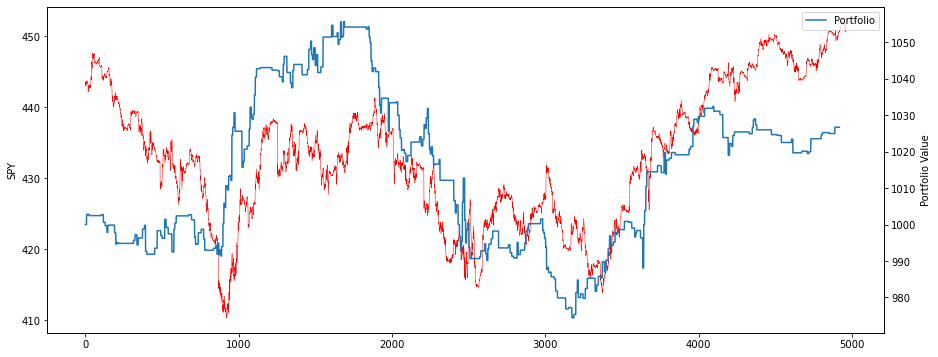

In [231]:
fig,axes = plt.subplots(1,1,figsize=[15,6])

file_loc = 'SPY_5min_2022-01-03T09.00.00_2022-03-25T14.10.00.csv'
df = pd.read_csv(os.path.join('data',file_loc),parse_dates=['datetime'])
df[6000:]['close'].reset_index(drop=True).plot(ax=axes,c='red',label='SPY movements',lw=0.5)

axes2 = axes.twinx()
axes2.plot(results,label='portfolio value')
# axes.set_xlabel('iteration')
# axes.set_ylabel('portfolio')
# axes[1].plot(probabilities,c='orange',lw=0.2)
# axes[1].set_xlabel('iteration')
# axes[1].set_ylabel('Probability of 0.5% growth in next 30min')
axes.set_ylabel('SPY')
axes2.set_ylabel('Portfolio Value')
plt.legend(['Portfolio','SPY'])
plt.show()

Market Made 1.7% gains, whereas the model got 2.6%

In [226]:
df[6000:]['close'].iloc[-1]/df[6000:]['close'].iloc[0]

1.0174370079628252

In [227]:
results[-1]/results[0]

1.0266780843682863

In [1]:
import tensorflow as tf
from tensorflow import keras

import pandas as pd
import numpy as np
import os
from matplotlib import pyplot as plt
from StockPredictionTools import plot_roc_curve, gini

In [2]:
file_loc = 'SPY_5min_2022-01-03T09.00.00_2022-03-25T14.10.00.csv'
df = pd.read_csv(os.path.join('data',file_loc),parse_dates=['datetime'])
df['date'] = df['datetime'].dt.date
df['time-delta'] = df['datetime'].diff().dt.seconds
for col in ['close']:
    df[f'{col}_diff'] = df[col].pct_change()

# Window of data we're working with
N = df.shape[0]
print(f'{N} ticks found')

# 2 hour lookback period
LOOKBACK = 2*(60/5)

# Growth requirement
GROWTH_LIMIT = 0.005

# outcome period 30min
HORIZON = 6

X = list()
y = list()
growth = list()

t =1
finish = False
counter = 0
while finish is False:
    
    counter+=1
    print(f'Counter:{counter}',end='\r')
    
    # check we have enough lookback data
    if t<41:
        t+=1
        continue
    
    # check we don't have enough data left then end the cycle
    if (N - t)<5:
        finish = True
        t+=1
        continue
        
    lookback_data = df.loc[t-40:t,['volume','close','open','high','low']].values
    lookback_data = lookback_data/lookback_data[-1]
    outcome_data = df.loc[t+1:t+6,'close_diff'].sum()>GROWTH_LIMIT
    growth_data = df.loc[t+1:t+6,'close_diff'].sum()
    
    X.append(lookback_data)
    y.append(outcome_data)
    growth.append(growth_data)
    
    t+=1
    
y = np.array(y).reshape(-1,1)
growth = np.array(growth).reshape(-1,1)
X = np.stack(X)

X_train = X[:6000].astype('float32')
X_test = X[6000:].astype('float32')

y_train = y[:6000].astype('float32')
y_test = y[6000:].astype('float32')

growth_train = growth[:6000].astype('float32')
growth_test = growth[6000:].astype('float32')

10965 ticks found


In [3]:
X_train.shape

(6000, 41, 5)

In [4]:
def convert_time_series_img(series,lower_bound,upper_bound,resolution):
    
    volume_series = series[:,0].ravel()
    close_series = series[:,1].ravel()
    open_series = series[:,2].ravel()
    high_series = series[:,3].ravel()
    low_series = series[:,4].ravel()

    levels = np.arange(lower_bound,upper_bound,resolution)
    levels = [-np.inf]+levels.tolist()+[np.inf]
    n_levels = len(levels)
    labels = np.arange(n_levels-1)

    #Y_volume = pd.cut(volume_series,levels,labels=labels[::-1])
    Y_close = pd.cut(close_series,levels,labels=labels[::-1])
    Y_open = pd.cut(open_series,levels,labels=labels[::-1])
    Y_high = pd.cut(high_series,levels,labels=labels[::-1])
    Y_low = pd.cut(low_series,levels,labels=labels[::-1])

    blank = np.full( (n_levels,41,3),0)
    X = np.arange(0,len(close_series))
    for x,c,o,h,l in zip(X,Y_close,Y_open,Y_high,Y_low):
        if o>=c:
            for y in range(c,o):
                # plotting the open close candle
                blank[y,x,0] = 60
                blank[y,x,1] = 240
                blank[y,x,2] = 60
            
            if h>o:
                for n,y in enumerate(range(o,h)):
                    # plotting the high candle
                    if n==0:
                        pass
                    else:
                        blank[y,x,0] = 255
                        blank[y,x,1] = 100
                        blank[y,x,2] = 255
                        
            if l<c:
                for n,y in enumerate(range(l,c)):
                    # plotting the high candle
                    if n==0:
                        pass
                    else:
                        blank[y,x,0] = 100
                        blank[y,x,1] = 255
                        blank[y,x,2] = 100
                        
                
        else:
            for y in range(o,c):
                blank[y,x,0] = 255
                blank[y,x,1] = 25
                blank[y,x,2] = 25
                
            if h>c:
                for n,y in enumerate(range(c,h)):
                    # plotting the high candle
                    if n==0:
                        pass
                    else:
                        blank[y,x,0] = 255
                        blank[y,x,1] = 100
                        blank[y,x,2] = 255
                        
            if l<o:
                for n,y in enumerate(range(l,o)):
                    # plotting the high candle
                    if n==0:
                        pass
                    else:
                        blank[y,x,0] = 100
                        blank[y,x,1] = 255
                        blank[y,x,2] = 100
        
    return blank

def plot_time_series(series):
    np_img = convert_time_series_img(series,0.99,1.01,0.0001)
    fig, axes = plt.subplots(figsize=(10,5))
    axes.imshow(np_img)
    plt.show()

In [5]:
img_train = np.stack([convert_time_series_img(X_train[x,:,:],0.99,1.01,0.0001) for x in range(len(X_train))]).astype('float32')
img_test = np.stack([convert_time_series_img(X_test[x,:,:],0.99,1.01,0.0001) for x in range(len(X_test))]).astype('float32')

In [6]:
volume_train = X_train[:,:,0]
volume_test = X_test[:,:,0]

In [7]:
class StonkModel(tf.keras.Model):
    
    def __init__(self):
        super().__init__()
        # activate all the layers
        self.conv0 = keras.layers.Conv2D(16, kernel_size=(3, 3), activation="relu")
        self.maxpool2D_0 = keras.layers.MaxPooling2D(pool_size=(3, 2))
#        self.batchnorm0 = keras.layers.BatchNormalization()
        
        self.conv1 = keras.layers.Conv2D(32, kernel_size=(3, 3), activation="relu")
        self.maxpool2D_1 = keras.layers.MaxPooling2D(pool_size=(3, 2))
#        self.batchnorm1 = keras.layers.BatchNormalization()
        
#         self.conv2 =  keras.layers.Conv2D(32, kernel_size=(3, 3), activation="relu")
#         self.maxpool2D_2 = keras.layers.MaxPooling2D(pool_size=(3, 2))
#         self.batchnorm2 = keras.layers.BatchNormalization()
        
        
        self.flatten = keras.layers.Flatten()
        self.dropout = keras.layers.Dropout(0.9)
        self.dense = keras.layers.Dense(1, activation="sigmoid")
        
        self.concat =  tf.keras.layers.Concatenate()
        
        

    def call(self, inputs, training=False):
        
        x,v = inputs[0],inputs[1]
        
        # Put the chart through the cnn
        x = self.conv0(x)
        x = self.maxpool2D_0(x)
#         x = self.batchnorm0(x)
        
        x = self.conv1(x)
        x = self.maxpool2D_1(x)
#         x = self.batchnorm1(x)
        
#         x = self.conv2(x)
#         x = self.maxpool2D_2(x)
#         x = self.batchnorm2(x)
        
        x = self.flatten(x)
        if training:
            x = self.dropout(x, training=training)
            
        # concatenate with the volume info
        x = self.concat([x,v])
        
        return self.dense(x)

In [29]:
model = StonkModel()
_ = model([img_train,volume_train])

In [30]:
img_train.shape

(6000, 203, 41, 3)

In [31]:
batch_size = 200
epochs = 20

lr_schedule = keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=0.1,
    decay_steps=30,
    decay_rate=0.90)

optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)

model.compile(loss="binary_crossentropy", optimizer=optimizer, metrics=[tf.metrics.AUC(name='auc')])
my_callbacks = [keras.callbacks.EarlyStopping(patience=5,restore_best_weights=True)]

history = model.fit([img_train,volume_train],y_train,
                    batch_size=batch_size, 
                    epochs=epochs, 
                    verbose=1,
                    validation_data=([img_test,volume_test],y_test),callbacks=my_callbacks)

Epoch 1/20
30/30 [==============================] - 9s 288ms/step - loss: 5.6754 - auc: 0.5033 - val_loss: 1.9723 - val_auc: 0.5078
Epoch 2/20
30/30 [==============================] - 8s 263ms/step - loss: 0.9381 - auc: 0.5565 - val_loss: 0.5415 - val_auc: 0.5063
Epoch 3/20
30/30 [==============================] - 8s 261ms/step - loss: 0.5569 - auc: 0.5645 - val_loss: 0.4161 - val_auc: 0.5252
Epoch 4/20
30/30 [==============================] - 8s 260ms/step - loss: 0.4092 - auc: 0.5809 - val_loss: 0.3290 - val_auc: 0.5499
Epoch 5/20
30/30 [==============================] - 8s 261ms/step - loss: 0.3168 - auc: 0.6275 - val_loss: 0.2940 - val_auc: 0.5736
Epoch 6/20
30/30 [==============================] - 8s 260ms/step - loss: 0.2610 - auc: 0.6453 - val_loss: 0.2683 - val_auc: 0.5882
Epoch 7/20
30/30 [==============================] - 8s 261ms/step - loss: 0.2266 - auc: 0.6423 - val_loss: 0.2448 - val_auc: 0.5977
Epoch 8/20
30/30 [==============================] - 8s 261ms/step - loss: 0.

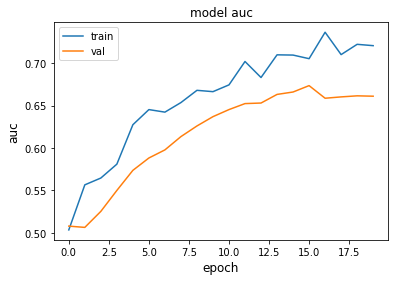

In [32]:
from matplotlib import pyplot as plt
metric = 'auc'
plt.figure()
plt.plot(history.history[metric])
plt.plot(history.history['val_'+metric])
plt.title('model '+metric)
plt.ylabel(metric,fontsize='large')
plt.xlabel('epoch',fontsize='large')
plt.legend(['train','val'],loc='best')
plt.show()

188/188 [==============================] - 2s 12ms/step


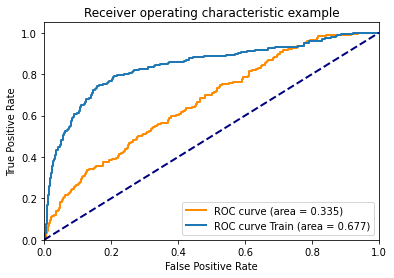

In [33]:
plot_roc_curve([img_train,volume_train],y_train,[img_test,volume_test],y_test,model)

In [34]:
input_series = X
train_predictions = model.predict([img_train,volume_train])
test_predictions = model.predict([img_test,volume_test])

# Cut the distribution up into percentiles
percentiles = np.percentile(train_predictions,[90])

# if in the top 10 percentiles then put a bet on of £100
bet_amount = np.where(train_predictions>percentiles[0],100,0)
results = bet_amount*growth_train
print(f'Results is:{results.sum()}')

154/154 [==============================] - 2s 11ms/step
Results is:37.871045118617985


In [35]:
# Cut the distribution up into percentiles
percentiles = np.percentile(train_predictions,[90])

# if in the top 10 percentiles then put a bet on of £100
bet_amount = np.where(test_predictions>percentiles[0],100,0)
results = bet_amount*growth_test
print(f'Test Results is:{results.sum()}')

Test Results is:20.285275696375038
